**Clone Github repo and set working directory path**

In [1]:
!git clone https://github.com/jamal94sm/TIHM.git
%cd /content/TIHM

Cloning into 'TIHM'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 111 (delta 40), reused 12 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (111/111), 28.08 MiB | 3.74 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (27/27), done.
/content/TIHM


In [ ]:
#!rm -r TIHM

**Load packages**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import cm
import matplotlib.patches as mpatches
from collections.abc import Iterable
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from matplotlib import cm
#from utils import *

%matplotlib inline
## Set colour palette
ibm_colorblind = ['#648FFF', '#FE6100', '#DC267F', '#785EF0', '#FFB000','#48A9A6']
sns.set_palette(ibm_colorblind)

**Functions**

In [3]:
def correct_col_type(df,col):
    raw_type = str(type(df[col].dtype)).split('.')[-1].split('\'')[0].lower()
    #print(col,raw_type)
    if 'object' in raw_type:
        if 'date' in col or 'timestamp' in col or 'datetime' in col:
            return pd.to_datetime(df[col])
        else:
            return df[col].astype('category')
    else:
        return df[col]


def gen_date_col(df, tcol):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df[tcol].dt.date
    return df

**Set Data and Fig folders paths**

In [4]:
## Please change the path with the path of your dataset
DPATH = './Dataset'
SAVE_PATH = './Figs/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)



**Import Files**

In [5]:
### Labels
f = 'Labels.csv'
fpth = os.path.join(DPATH,f)
labels_df = pd.read_csv(fpth)
for col in labels_df.columns:
    labels_df[col] = correct_col_type(labels_df,col)
if 'date' in labels_df.columns:
    labels_df = labels_df.rename(columns={'date':'timestamp'})
if 'type' in labels_df.columns:
    labels_df = labels_df.rename(columns={'type':'label'})
labels_df = gen_date_col(labels_df,tcol='timestamp')

labels_patients = np.unique(labels_df['patient_id'])


# **Activity**

In [6]:
### Activity

f = 'Activity.csv'
fpth = os.path.join(DPATH,f)
df = pd.read_csv(fpth)
for col in df.columns:
    df[col] = correct_col_type(df,col)
if 'date' in df.columns:
    activity_df = df.rename(columns={'date':'timestamp'})
    activity_df['timestamp'] = pd.to_datetime(activity_df['timestamp'])
    activity_df['date'] = activity_df['timestamp'].dt.date
    activity_df['time'] = activity_df['timestamp'].dt.time


activity_patients = np.unique(activity_df['patient_id'])

#activity_df

In [7]:
### patient id
id = '16f4b' # 11 agitation days, and 89 record day (78 normal days vs 11 agitation days)
id_activity_df = activity_df[activity_df['patient_id']==id]

# Patient Activity Types
id_activity_types = np.unique(id_activity_df['location_name'])

# Create a new column to identify if the patient is outside
id_activity_df['outside'] = id_activity_df['location_name'].isin(['Front Door', 'Back Door'])

# Initialize a list to store results
daily_time_outside = []

# Group by date
grouped = id_activity_df.groupby(id_activity_df['timestamp'].dt.date)

for date, group in grouped:
    total_time_outside = 0

    # Iterate through the group to calculate time spent outside (in minutes)
    for i in range(1, len(group)):
        if group['outside'].iloc[i] and group['outside'].iloc[i - 1]:
            time_diff = (group['timestamp'].iloc[i] - group['timestamp'].iloc[i - 1]).total_seconds() / 60
            total_time_outside += time_diff

    daily_time_outside.append({'date': date, 'time_spent_outside': total_time_outside})

# Convert results to DataFrame
results_df = pd.DataFrame(daily_time_outside)

# Print the results
#print(id_activity_df)

In [11]:
# Example patient ID and activity data (for demonstration purposes)
id = '16f4b'  # Replace with the actual patient ID
# activity_df and agitation_df should be defined or loaded with your data here

# Filter activity data for the specific patient
id_activity_df = activity_df[activity_df['patient_id'] == id]

# Activity days, normal_days, and agitation_days
activity_days = activity_df['date'][activity_df['patient_id'] == id].unique()
agitation_df = labels_df[labels_df['label']=='Agitation'].copy()
agitation_days = agitation_df['date'][agitation_df['patient_id'] == id].unique()
normal_days = activity_days[~np.isin(activity_days, agitation_days)]

# Step 1: Calculate mobility changes
mobility_data = id_activity_df.groupby('date')['location_name'].apply(lambda x: x.values)

# Calculate mobility changes
mobility_counts = mobility_data.apply(lambda each_day_activity_sequence: np.nansum(np.concatenate([[np.NaN], each_day_activity_sequence[1:] != each_day_activity_sequence[:-1]])))

# Create mobility_df with mobility counts
mobility_df = pd.DataFrame({
    'date': mobility_counts.index,
    'mobility': mobility_counts.values
})

# Add a new column to mobility_df to specify normal and agitation days
mobility_df['day_type'] = mobility_df['date'].apply(lambda x: 'agitation' if x in agitation_days else 'normal')

# Calculate time spent outside each day
id_activity_df['outside'] = id_activity_df['location_name'].isin(['Front Door', 'Back Door'])

# Initialize list for daily outside time calculations
daily_time_outside = []

# Group by date
grouped = id_activity_df.groupby(id_activity_df['timestamp'].dt.date)

for date, group in grouped:
    total_time_outside = 0

    # Iterate through the group to calculate time spent outside
    for i in range(1, len(group)):
        if group['outside'].iloc[i] and group['outside'].iloc[i - 1]:
            time_diff = (group['timestamp'].iloc[i] - group['timestamp'].iloc[i - 1]).total_seconds() / 60
            total_time_outside += time_diff

    daily_time_outside.append({'date': date, 'time_spent_outside': total_time_outside})

# Convert daily_time_outside to DataFrame
time_outside_df = pd.DataFrame(daily_time_outside)

# Merge time spent outside into mobility_df
mobility_df = mobility_df.merge(time_outside_df, on='date', how='left')

# Optionally, include patient_id if needed
mobility_df['patient_id'] = id  # Add the patient_id

# Save the output to a CSV file
mobility_df.to_csv('mobility_data_with_time_outside.csv', index=False)

# Display the new DataFrame
print(mobility_df)
#print(mobility_df[mobility_df['day_type'] == 'agitation'])

          date  mobility day_type  time_spent_outside patient_id
0   2019-04-01      28.0   normal            0.000000      16f4b
1   2019-04-03      94.0   normal            0.000000      16f4b
2   2019-04-04     308.0   normal            5.400000      16f4b
3   2019-04-05     384.0   normal            4.266667      16f4b
4   2019-04-06     305.0   normal            4.783333      16f4b
..         ...       ...      ...                 ...        ...
84  2019-06-26     135.0   normal            7.716667      16f4b
85  2019-06-27     185.0   normal           15.916667      16f4b
86  2019-06-28     194.0   normal           10.250000      16f4b
87  2019-06-29     128.0   normal          132.733333      16f4b
88  2019-06-30     151.0   normal            2.300000      16f4b

[89 rows x 5 columns]


# Nutrition

In [8]:
### patient id
id = '099bc'
id_activity_df = activity_df[activity_df['patient_id']==id]

#print(id_activity_df[:50])


# Convert timestamp to datetime if not already done
id_activity_df['timestamp'] = pd.to_datetime(id_activity_df['timestamp'])

# Create a new column to identify changes in location
id_activity_df['prev_location'] = id_activity_df['location_name'].shift(1)

# Create a column to mark when we have a "Fridge Door" entry that is not preceded by another "Fridge Door"
id_activity_df['is_fridge_visit'] = ((id_activity_df['location_name'] == 'Fridge Door') &
                                      (id_activity_df['prev_location'] != 'Fridge Door'))

# Create a new DataFrame that counts unique visits of 'Fridge Door' per patient per day
fridge_counts = (id_activity_df.groupby(['patient_id', 'date'])
                 .agg(fridge_door_count=('is_fridge_visit', 'sum'))
                 .reset_index())

# Merge the counts back into the original DataFrame
id_activity_df = id_activity_df.merge(fridge_counts, on=['patient_id', 'date'], how='left')

# Fill NaN values with 0 (in case there were no visits to the Fridge Door)
id_activity_df['fridge_door_count'].fillna(0, inplace=True)

# Convert the count to integer type
id_activity_df['fridge_door_count'] = id_activity_df['fridge_door_count'].astype(int)

# Drop the auxiliary columns if not needed
id_activity_df.drop(columns=['prev_location', 'is_fridge_visit'], inplace=True)

# Display the updated DataFrame
print(id_activity_df)

      patient_id location_name           timestamp        date      time  \
0          099bc       Kitchen 2019-05-15 12:19:32  2019-05-15  12:19:32   
1          099bc    Front Door 2019-05-15 12:20:20  2019-05-15  12:20:20   
2          099bc   Fridge Door 2019-05-15 12:20:21  2019-05-15  12:20:21   
3          099bc     Back Door 2019-05-15 12:20:24  2019-05-15  12:20:24   
4          099bc       Kitchen 2019-05-15 12:23:22  2019-05-15  12:23:22   
...          ...           ...                 ...         ...       ...   
11933      099bc       Bedroom 2019-06-30 22:47:31  2019-06-30  22:47:31   
11934      099bc       Bedroom 2019-06-30 23:24:04  2019-06-30  23:24:04   
11935      099bc      Bathroom 2019-06-30 23:24:25  2019-06-30  23:24:25   
11936      099bc      Bathroom 2019-06-30 23:26:43  2019-06-30  23:26:43   
11937      099bc       Bedroom 2019-06-30 23:26:56  2019-06-30  23:26:56   

       fridge_door_count  
0                     12  
1                     12  
2     

## Physiology Data Repairing

In [9]:
### Physiology
f = 'Physiology.csv'
fpth = os.path.join(DPATH,f)
df = pd.read_csv(fpth)
for col in df.columns:
    df[col] = correct_col_type(df,col)
if 'date' in df.columns:
    physiology_df = df.rename(columns={'date':'timestamp'})
physiology_df = gen_date_col(physiology_df,tcol='timestamp')

physiology_patients = np.unique(df['patient_id'])
physiology_parameters = np.unique(df['device_type']).tolist()

#physiology_df[:50]

In [10]:
# Get the unique patient IDs and device types
patients = physiology_df['patient_id'].unique()
device_types = physiology_df['device_type'].unique()

# Create a DataFrame that retains original study days for each patient
study_days = physiology_df[['patient_id', 'date']].drop_duplicates()

# Prepare a list to hold the filled results
filled_results_list = []

# Iterate over each patient
for patient in patients:
    # Get the patient's data
    patient_data = physiology_df[physiology_df['patient_id'] == patient]

    # For each study day, check measurements
    for date in study_days[study_days['patient_id'] == patient]['date']:
        for device in device_types:
            # Get all values for this patient, date, and device type
            values = patient_data.loc[(patient_data['date'] == date) & (patient_data['device_type'] == device), 'value']
            if not values.empty:
                # Compute the average value (considering repetitions)
                avg_value = values.mean()
                unit = patient_data.loc[(patient_data['date'] == date) & (patient_data['device_type'] == device), 'unit'].values[0]
                filled_results_list.append({
                    'patient_id': patient,
                    'date': date,
                    'device_type': device,
                    'value': avg_value,
                    'unit': unit
                })
            else:
                # If there are no measurements, append a None
                filled_results_list.append({
                    'patient_id': patient,
                    'date': date,
                    'device_type': device,
                    'value': None,  # To be filled later
                    'unit': None
                })

# Convert the list of dictionaries to a DataFrame
filled_results = pd.DataFrame(filled_results_list)

# Now, we can fill in the missing values
def fill_missing_values(group):
    for device in device_types:
        # Patient's specific values for this device
        patient_values = group[group['device_type'] == device]['value']

        # If any values exist, calculate the average to fill
        if patient_values.notnull().any():
            avg_patient_value = patient_values.mean()
            group.loc[(group['device_type'] == device) & (group['value'].isnull()), 'value'] = avg_patient_value
        else:
            # If no values exist at all, use the overall average for this device if applicable
            if physiology_df[physiology_df['device_type'] == device]['value'].notna().any():
                overall_avg = physiology_df[physiology_df['device_type'] == device]['value'].mean()
                group.loc[(group['device_type'] == device) & (group['value'].isnull()), 'value'] = overall_avg

    return group

# Apply filling logic to the filled_results DataFrame
filled_physiology_df = filled_results.groupby('patient_id', group_keys=False).apply(fill_missing_values)

# Sort by patient_id and date
filled_physiology_df.sort_values(by=['patient_id', 'date'], inplace=True)


# **Static Analysis**

In [21]:
import matplotlib.pyplot as plt

def plot_mobility_anomaly_agitation_days(mobility_df, col, label_dates,
                                         anomaly_flags,
                                         annotation='Agitation'):
    """
    Plots mobility trends with anomaly detection and agitation days.

    Parameters:
    mobility_df : DataFrame
        Input dataframe containing mobility data.
    col : str
        Column name of the mobility feature to be plotted.
    anomaly_flags : Series or array-like
        Boolean array indicating anomalous dates.
    label_dates : list
        List of dates with positive labels of interest.
    annotation : str, optional
        Annotation label for positive labels (default: 'Agitation').

    Returns:
    None
    """
    # Check the essential columns exist in the mobility_df
    if not 'date' in mobility_df.columns:
      raise ValueError(' date column does not exist.')

    # Plot setup
    plt.figure(figsize=(14, 7))
    plt.plot(mobility_df['date'], mobility_df[col], marker='o', label='Mobility', color='blue')
    plt.axhline(y=mobility_df[col].mean(), color='orange', linestyle='--', label='Mean Mobility')

    # Highlight anomal dates
    plt.scatter(mobility_df['date'][anomaly_flags], mobility_df[col][anomaly_flags],
                color='red', label='Anomalies', zorder=5)

    # Annotate agitation days
    for date in label_dates:

      mobility_value = mobility_df.loc[mobility_df['date'] == date, col].values[0]
      plt.annotate(annotation,
                    xy=(date, mobility_value),
                    xytext=(15, 15),  # Offset for readability
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                    fontsize=9, color='green')

    # Final plot formatting
    plt.title(f'Daily {col.capitalize()} Monitoring with Anomaly Detection')
    plt.xlabel('Date')
    plt.ylabel(col.capitalize())
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print dataframe (optional)
    print(mobility_df)


**Z-score Analysis based on mobility and time spent outside**

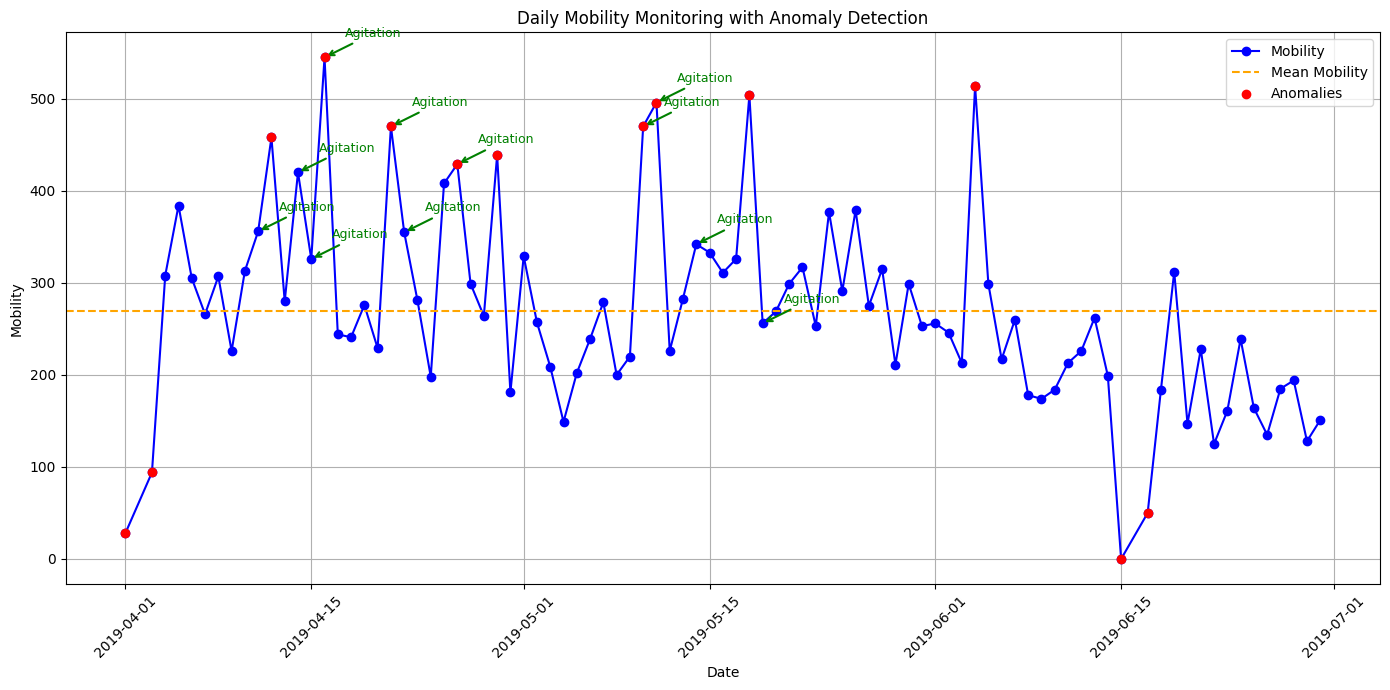

          date  mobility day_type  time_spent_outside patient_id   z_score  \
0   2019-04-01      28.0   normal            0.000000      16f4b -2.292828   
1   2019-04-03      94.0   normal            0.000000      16f4b -1.664975   
2   2019-04-04     308.0   normal            5.400000      16f4b  0.370790   
3   2019-04-05     384.0   normal            4.266667      16f4b  1.093772   
4   2019-04-06     305.0   normal            4.783333      16f4b  0.342251   
..         ...       ...      ...                 ...        ...       ...   
84  2019-06-26     135.0   normal            7.716667      16f4b -1.274946   
85  2019-06-27     185.0   normal           15.916667      16f4b -0.799299   
86  2019-06-28     194.0   normal           10.250000      16f4b -0.713683   
87  2019-06-29     128.0   normal          132.733333      16f4b -1.341536   
88  2019-06-30     151.0   normal            2.300000      16f4b -1.122739   

    anomaly  
0      True  
1      True  
2     False  
3     F

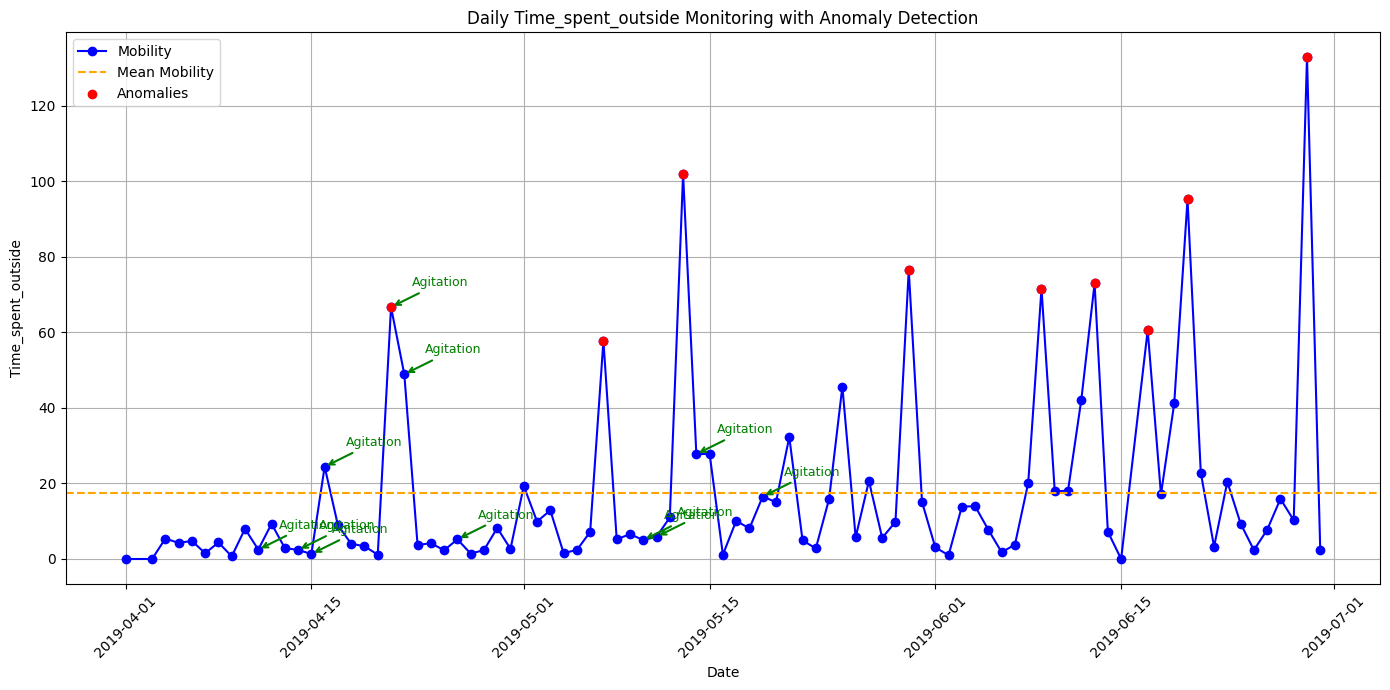

          date  mobility day_type  time_spent_outside patient_id   z_score  \
0   2019-04-01      28.0   normal            0.000000      16f4b -2.292828   
1   2019-04-03      94.0   normal            0.000000      16f4b -1.664975   
2   2019-04-04     308.0   normal            5.400000      16f4b  0.370790   
3   2019-04-05     384.0   normal            4.266667      16f4b  1.093772   
4   2019-04-06     305.0   normal            4.783333      16f4b  0.342251   
..         ...       ...      ...                 ...        ...       ...   
84  2019-06-26     135.0   normal            7.716667      16f4b -1.274946   
85  2019-06-27     185.0   normal           15.916667      16f4b -0.799299   
86  2019-06-28     194.0   normal           10.250000      16f4b -0.713683   
87  2019-06-29     128.0   normal          132.733333      16f4b -1.341536   
88  2019-06-30     151.0   normal            2.300000      16f4b -1.122739   

    anomaly  
0      True  
1      True  
2     False  
3     F

In [25]:
import matplotlib.pyplot as plt
from scipy import stats

# Define a threshold to identify anomalies beased on z_score values
threshold = 1.5

# Calculate the Z-score for mobility
mobility_z_score = stats.zscore(mobility_df['mobility'])

# Calculate the Z-score for outside
time_spent_outside_z_score = stats.zscore(mobility_df['time_spent_outside'])

# Identify anomalies based on Z-score for both features
mobility_anomaly = mobility_z_score.abs() > threshold
time_spent_outside_anomaly = time_spent_outside_z_score.abs() > threshold

# Mobility anomaly check
plot_mobility_anomaly_agitation_days(mobility_df, col='mobility',
                                     anomaly_flags=mobility_anomaly,
                                     label_dates=agitation_days,
                                     annotation='Agitation'
)

# Mobility anomaly check
plot_mobility_anomaly_agitation_days(mobility_df, col='time_spent_outside',
                                     anomaly_flags=time_spent_outside_anomaly,
                                     label_dates=agitation_days,
                                     annotation='Agitation'
)

**Z-score based on mobility and ouside time**

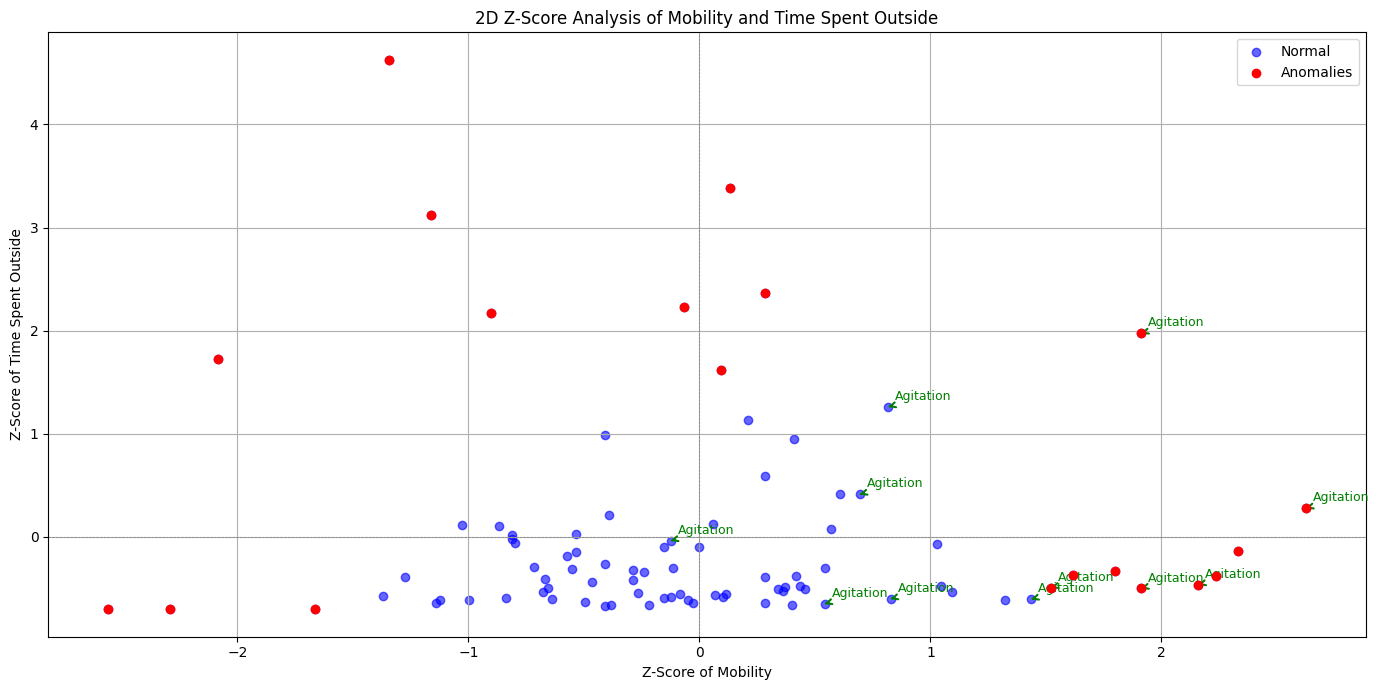

          date  mobility  time_spent_outside  z_score_mobility  \
0   2019-04-01      28.0            0.000000         -2.292828   
1   2019-04-03      94.0            0.000000         -1.664975   
2   2019-04-04     308.0            5.400000          0.370790   
3   2019-04-05     384.0            4.266667          1.093772   
4   2019-04-06     305.0            4.783333          0.342251   
..         ...       ...                 ...               ...   
84  2019-06-26     135.0            7.716667         -1.274946   
85  2019-06-27     185.0           15.916667         -0.799299   
86  2019-06-28     194.0           10.250000         -0.713683   
87  2019-06-29     128.0          132.733333         -1.341536   
88  2019-06-30     151.0            2.300000         -1.122739   

    z_score_outside  anomaly_mobility  anomaly_outside  
0         -0.703600              True            False  
1         -0.703600              True            False  
2         -0.486716             Fals

In [26]:
# Calculate the Z-scores for both mobility and time spent outside
mobility_df['z_score_mobility'] = stats.zscore(mobility_df['mobility'])  # Fill NaNs if necessary
mobility_df['z_score_outside'] = stats.zscore(mobility_df['time_spent_outside'])  # Fill NaNs if necessary

# Define a threshold to identify anomalies for both features
threshold = 1.5

# Identify anomalies based on Z-scores
mobility_df['anomaly_mobility'] = mobility_df['z_score_mobility'].abs() > threshold
mobility_df['anomaly_outside'] = mobility_df['z_score_outside'].abs() > threshold

# Plotting the 2D Z-score analysis
plt.figure(figsize=(14, 7))
plt.scatter(mobility_df['z_score_mobility'], mobility_df['z_score_outside'],
            c='blue', label='Normal', alpha=0.6)

# Highlight anomalies
plt.scatter(mobility_df['z_score_mobility'][mobility_df['anomaly_mobility'] | mobility_df['anomaly_outside']],
            mobility_df['z_score_outside'][mobility_df['anomaly_mobility'] | mobility_df['anomaly_outside']],
            color='red', label='Anomalies', zorder=5)

# Adding labels and title
plt.title('2D Z-Score Analysis of Mobility and Time Spent Outside')
plt.xlabel('Z-Score of Mobility')
plt.ylabel('Z-Score of Time Spent Outside')
plt.axhline(0, color='grey', lw=0.5, linestyle='--')
plt.axvline(0, color='grey', lw=0.5, linestyle='--')
plt.legend()
plt.grid()

# Annotate agitation days
for index, row in mobility_df[mobility_df['day_type'] == 'agitation'].iterrows():
    plt.annotate('Agitation',
                 xy=(row['z_score_mobility'], row['z_score_outside']),
                 xytext=(5, 5),  # Offset the text position
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                 fontsize=9,
                 color='green')

plt.tight_layout()

# Show the plot
plt.show()

# Display the mobility_df with Z-scores and anomalies
print(mobility_df[['date', 'mobility', 'time_spent_outside', 'z_score_mobility', 'z_score_outside', 'anomaly_mobility', 'anomaly_outside']])


**K-means based on mobility**

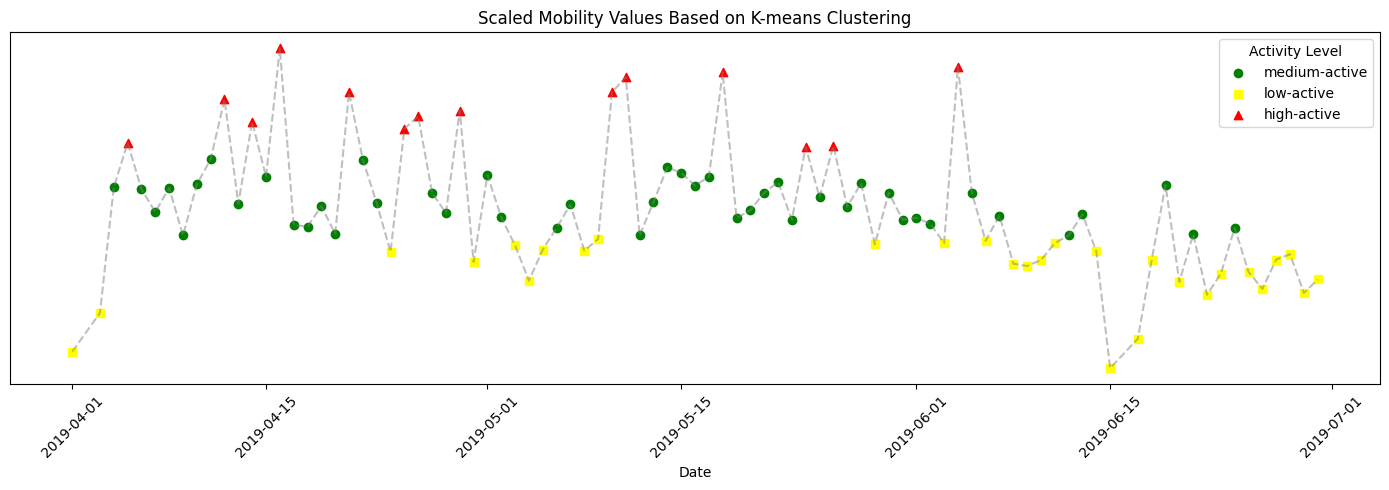

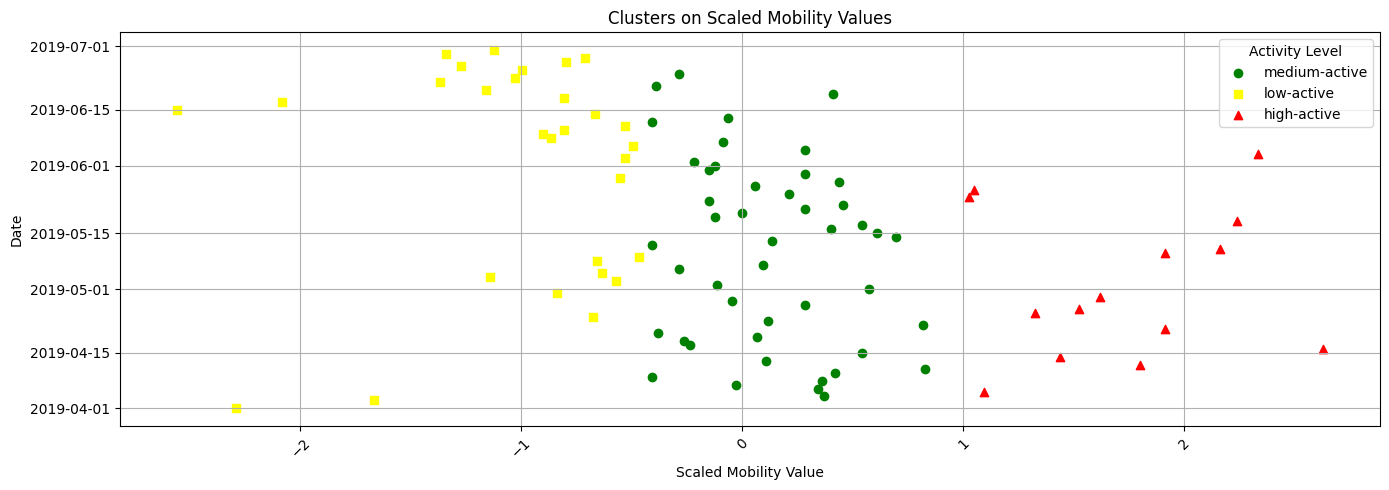

          date  mobility activity_level
0   2019-04-01      28.0     low-active
1   2019-04-03      94.0     low-active
2   2019-04-04     308.0  medium-active
3   2019-04-05     384.0    high-active
4   2019-04-06     305.0  medium-active
..         ...       ...            ...
84  2019-06-26     135.0     low-active
85  2019-06-27     185.0     low-active
86  2019-06-28     194.0     low-active
87  2019-06-29     128.0     low-active
88  2019-06-30     151.0     low-active

[89 rows x 3 columns]


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalize the mobility data
scaler = StandardScaler()
mobility_scaled = scaler.fit_transform(mobility_df[['mobility']])

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
mobility_df['cluster'] = kmeans.fit_predict(mobility_scaled)

# Map cluster numbers to activity labels (change the labels as requested)
activity_labels = ['medium-active', 'low-active', 'high-active']  # Adjusted so the lowest value is medium-active
mobility_df['activity_level'] = mobility_df['cluster'].map(lambda x: activity_labels[x])

# Adding activity_type column for clarity
mobility_df['activity_type'] = mobility_df['activity_level']

# Plotting clusters on a 1-D axis with different colors
plt.figure(figsize=(14, 5))
colors = ['green', 'yellow', 'red']  # Define colors for each activity level
markers = ['o', 's', '^']  # Different markers for better differentiation

# Create a scatter plot for the scaled mobility values
for i, label in enumerate(activity_labels):
    plt.scatter(mobility_df['date'][mobility_df['activity_level'] == label],
                mobility_scaled[mobility_df['activity_level'] == label],  # Using scaled mobility values
                color=colors[i], label=label, marker=markers[i])

# Adding dashed lines to connect the points
plt.plot(mobility_df['date'], mobility_scaled, linestyle='--', color='gray', alpha=0.5)

# Customizing the plot for scaled mobility values
plt.yticks([])
plt.title('Scaled Mobility Values Based on K-means Clustering')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(title='Activity Level')
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()

# Create another figure for scaled mobility values with clusters
plt.figure(figsize=(14, 5))

# Create a scatter plot with scaled mobility values on the x-axis
for i, label in enumerate(activity_labels):
    plt.scatter(mobility_scaled[mobility_df['activity_level'] == label],
                mobility_df['date'][mobility_df['activity_level'] == label],
                color=colors[i], label=label, marker=markers[i])

# Customizing the second plot
plt.title('Clusters on Scaled Mobility Values')
plt.xlabel('Scaled Mobility Value')
plt.ylabel('Date')
plt.xticks(rotation=45)
plt.legend(title='Activity Level')
plt.grid(True)
plt.tight_layout()

# Show the second plot
plt.show()

# Display the mobility_df with clusters and activity levels
print(mobility_df[['date', 'mobility', 'activity_level']])


**K-means based on mobility and ouside time**

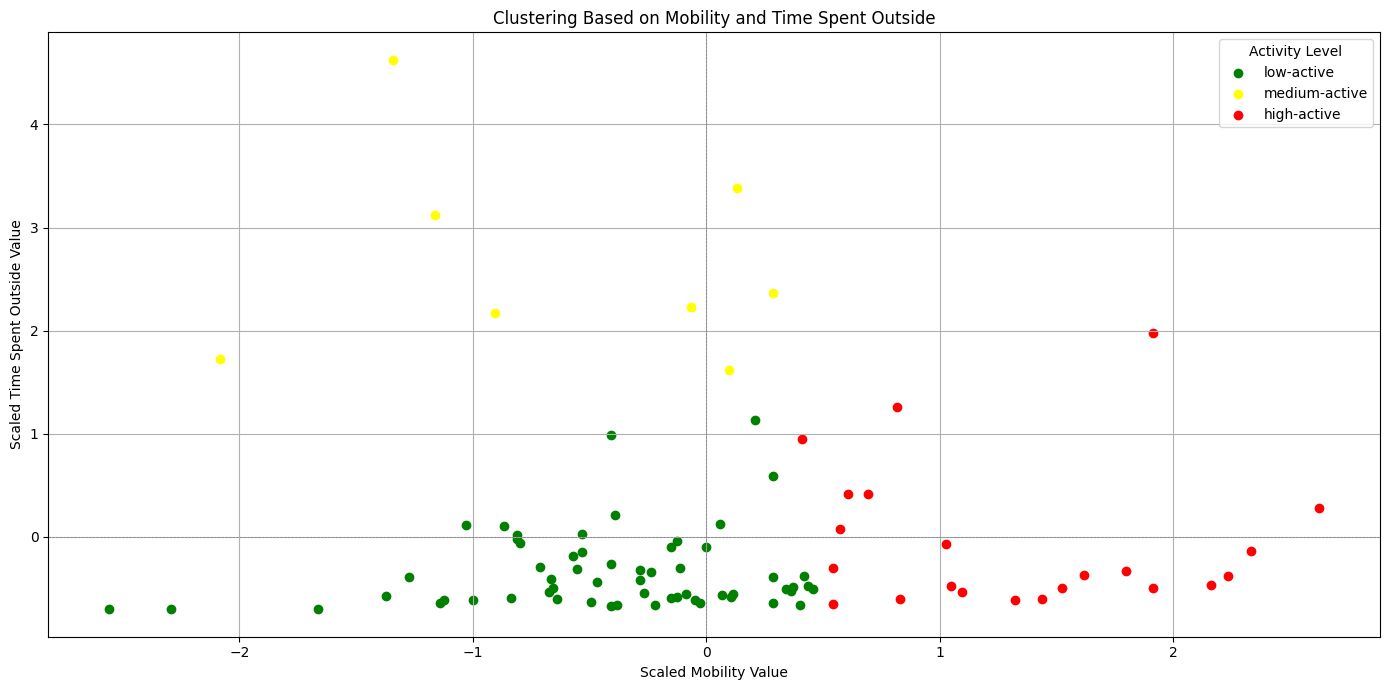

          date  mobility  time_spent_outside activity_level
0   2019-04-01      28.0            0.000000     low-active
1   2019-04-03      94.0            0.000000     low-active
2   2019-04-04     308.0            5.400000     low-active
3   2019-04-05     384.0            4.266667    high-active
4   2019-04-06     305.0            4.783333     low-active
..         ...       ...                 ...            ...
84  2019-06-26     135.0            7.716667     low-active
85  2019-06-27     185.0           15.916667     low-active
86  2019-06-28     194.0           10.250000     low-active
87  2019-06-29     128.0          132.733333  medium-active
88  2019-06-30     151.0            2.300000     low-active

[89 rows x 4 columns]


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Normalize the mobility and time spent outside data
scaler = StandardScaler()
mobility_scaled = scaler.fit_transform(mobility_df[['mobility', 'time_spent_outside']])

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
mobility_df['cluster'] = kmeans.fit_predict(mobility_scaled)

# Map cluster numbers to activity labels
activity_labels = ['low-active', 'medium-active', 'high-active']  # Adjusted so the lowest value is medium-active
mobility_df['activity_level'] = mobility_df['cluster'].map(lambda x: activity_labels[x])

# Adding activity_type column for clarity
mobility_df['activity_type'] = mobility_df['activity_level']

# Plotting clusters on a 2D feature space
plt.figure(figsize=(14, 7))
colors = ['green', 'yellow', 'red']  # Define colors for each activity level

# Create a scatter plot for the scaled mobility and time spent outside values
for i, label in enumerate(activity_labels):
    plt.scatter(mobility_scaled[mobility_df['activity_level'] == label, 0],  # Scaled mobility values
                mobility_scaled[mobility_df['activity_level'] == label, 1],  # Scaled time spent outside values
                color=colors[i], label=label)

# Customize the plot
plt.title('Clustering Based on Mobility and Time Spent Outside')
plt.xlabel('Scaled Mobility Value')
plt.ylabel('Scaled Time Spent Outside Value')
plt.axhline(0, color='grey', lw=0.5, linestyle='--')
plt.axvline(0, color='grey', lw=0.5, linestyle='--')
plt.legend(title='Activity Level')
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

# Display the mobility_df with clusters and activity levels
print(mobility_df[['date', 'mobility', 'time_spent_outside', 'activity_level']])

**Gaussian Mixture Model based on mobility**

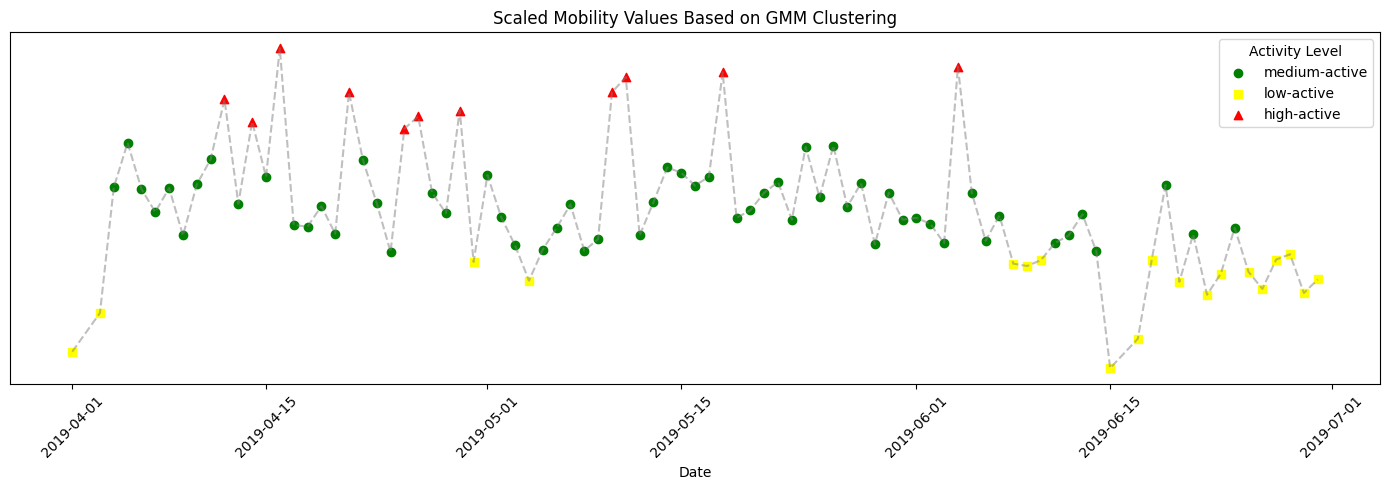

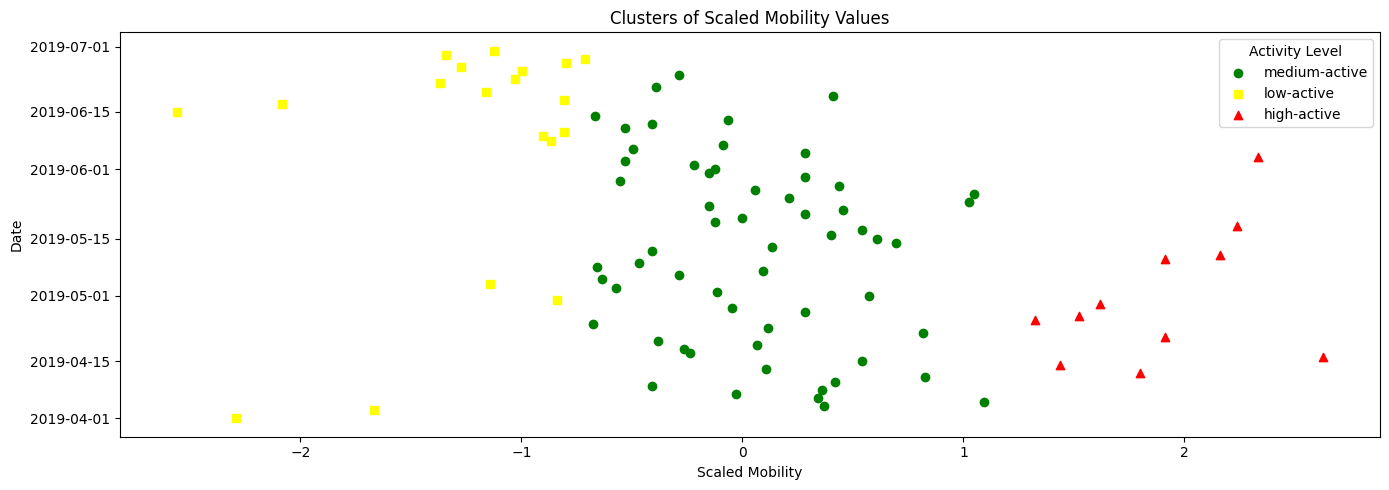

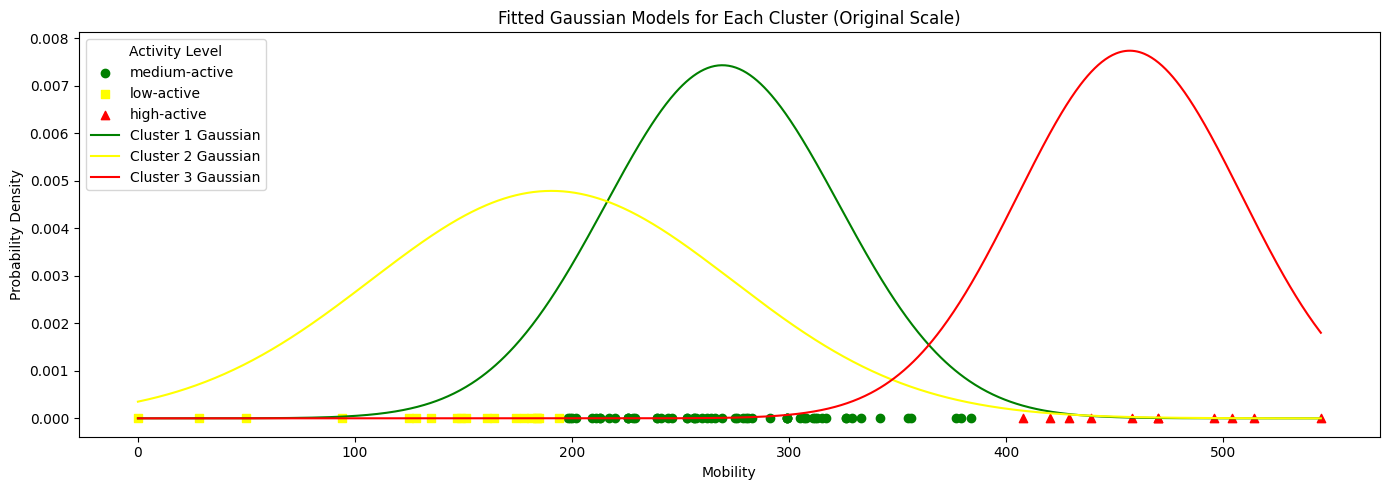

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import numpy as np

# Normalize the mobility data
scaler = StandardScaler()
mobility_scaled = scaler.fit_transform(mobility_df[['mobility']])

# Apply GMM clustering
gmm = GaussianMixture(n_components=3, random_state=0)
mobility_df['cluster'] = gmm.fit_predict(mobility_scaled)

# Map cluster numbers to activity labels (change the labels as requested)
activity_labels = ['medium-active', 'low-active', 'high-active']  # Adjusted so the lowest value is medium-active
mobility_df['activity_level'] = mobility_df['cluster'].map(lambda x: activity_labels[x])

# Adding activity_type column for clarity
mobility_df['activity_type'] = mobility_df['activity_level']

# Plotting clusters on a 1-D axis with different colors
plt.figure(figsize=(14, 5))
colors = ['green', 'yellow', 'red']  # Define colors for each activity level
markers = ['o', 's', '^']  # Different markers for better differentiation

# Create a scatter plot for the scaled mobility values
for i, label in enumerate(activity_labels):
    plt.scatter(mobility_df['date'][mobility_df['activity_level'] == label],
                mobility_scaled[mobility_df['activity_level'] == label],  # Using scaled mobility values
                color=colors[i], label=label, marker=markers[i])

# Adding dashed lines to connect the points
plt.plot(mobility_df['date'], mobility_scaled, linestyle='--', color='gray', alpha=0.5)

# Customizing the plot for scaled mobility values
plt.yticks([])
plt.title('Scaled Mobility Values Based on GMM Clustering')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(title='Activity Level')
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()

# Create another figure for scaled mobility values with clusters
plt.figure(figsize=(14, 5))

# Create a scatter plot with scaled mobility values on the x-axis
for i, label in enumerate(activity_labels):
    plt.scatter(mobility_scaled[mobility_df['activity_level'] == label],
                mobility_df['date'][mobility_df['activity_level'] == label],
                color=colors[i], label=label, marker=markers[i])

plt.xlabel('Scaled Mobility')
plt.ylabel('Date')
plt.title('Clusters of Scaled Mobility Values')
plt.legend(title='Activity Level')
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()

# Create a new figure with mobility values on the x-axis and fitted Gaussian models on the y-axis
plt.figure(figsize=(14, 5))

# Plot the data samples with different colors based on clusters
for i, label in enumerate(activity_labels):
    plt.scatter(mobility_df['mobility'][mobility_df['activity_level'] == label],
                np.zeros(sum(mobility_df['activity_level'] == label)),  # y values are 0 for scatter plot
                color=colors[i], label=label, marker=markers[i])

# Plot the fitted Gaussian models for each cluster based on the original mean and std
x = np.linspace(min(mobility_df['mobility']), max(mobility_df['mobility']), 1000)
for i, (mean, covar, color) in enumerate(zip(gmm.means_, gmm.covariances_, colors)):
    # Scale back the mean and std to the original values
    original_mean = scaler.inverse_transform(mean.reshape(1, -1)).flatten()
    original_std = np.sqrt(covar[0][0]) * scaler.scale_[0]
    y = np.exp(-0.5 * ((x - original_mean[0]) ** 2) / original_std ** 2) / np.sqrt(2 * np.pi * original_std ** 2)
    plt.plot(x, y, color=color, label=f'Cluster {i+1} Gaussian')

plt.xlabel('Mobility')
plt.ylabel('Probability Density')
plt.title('Fitted Gaussian Models for Each Cluster (Original Scale)')
plt.legend(title='Activity Level')
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.show()


**Gaussian Mixture Model based on mobility and outside time**

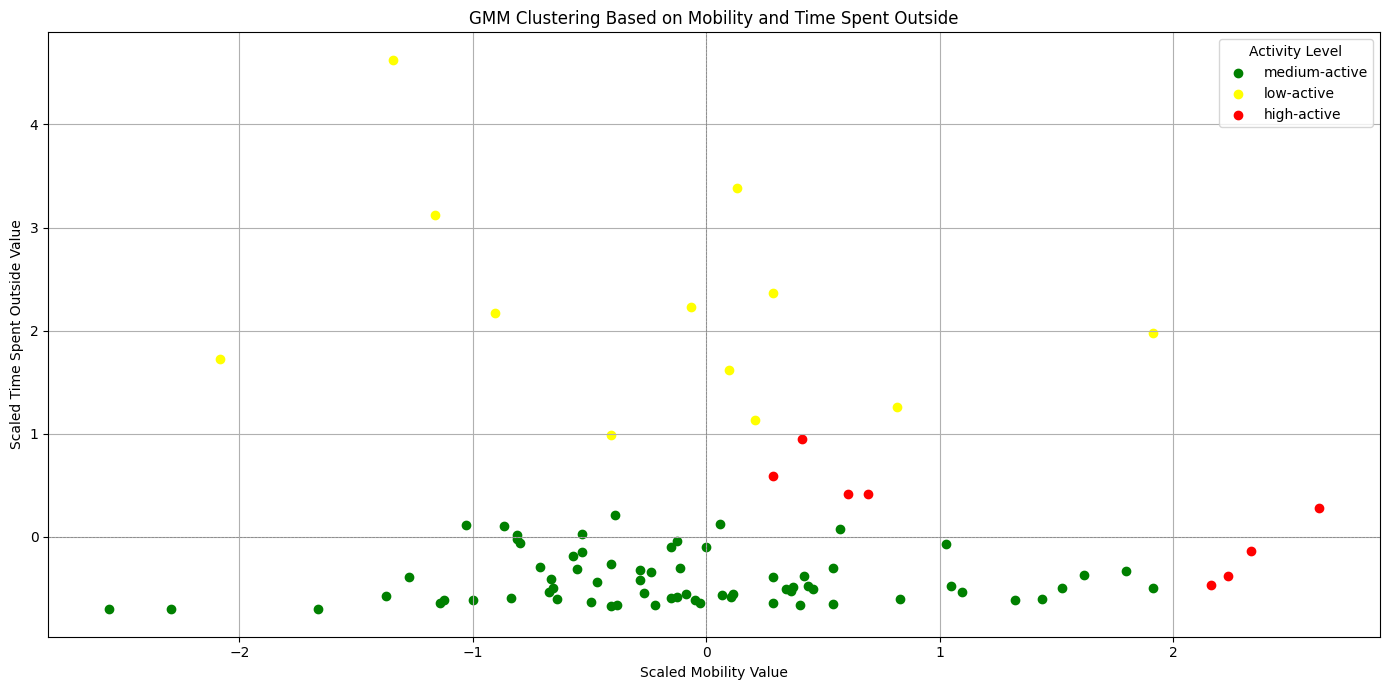

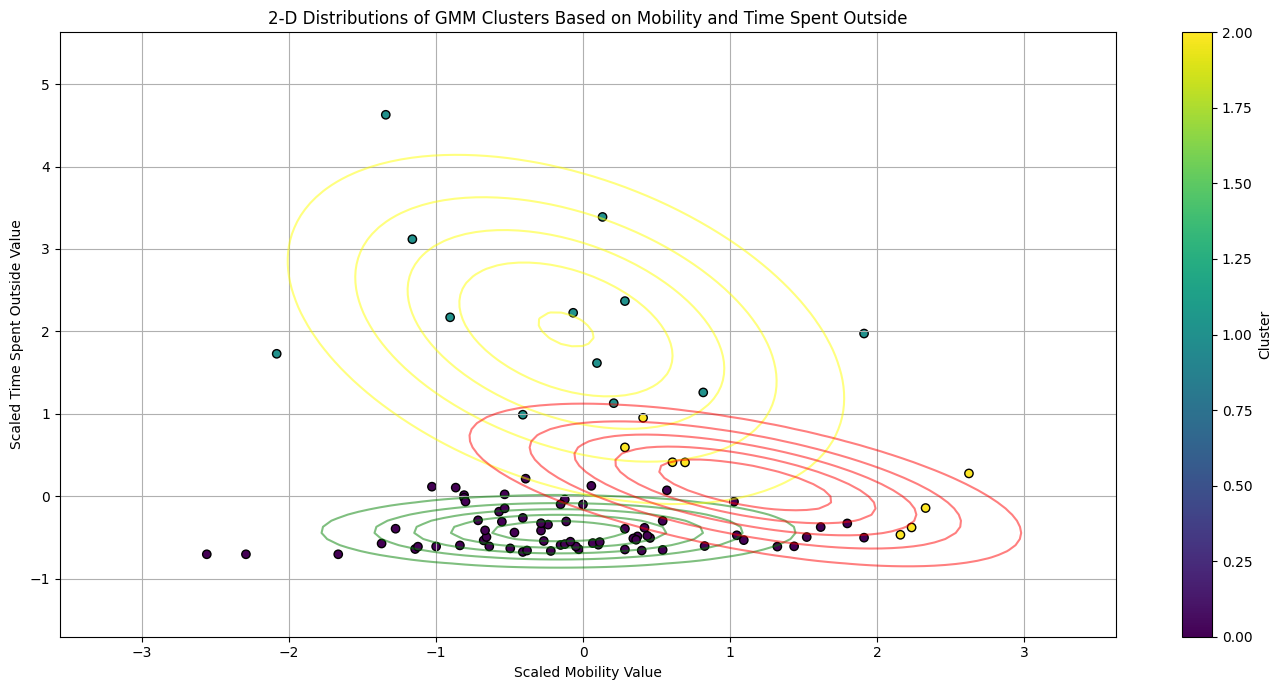

          date  mobility  time_spent_outside activity_level
0   2019-04-01      28.0            0.000000  medium-active
1   2019-04-03      94.0            0.000000  medium-active
2   2019-04-04     308.0            5.400000  medium-active
3   2019-04-05     384.0            4.266667  medium-active
4   2019-04-06     305.0            4.783333  medium-active
..         ...       ...                 ...            ...
84  2019-06-26     135.0            7.716667  medium-active
85  2019-06-27     185.0           15.916667  medium-active
86  2019-06-28     194.0           10.250000  medium-active
87  2019-06-29     128.0          132.733333     low-active
88  2019-06-30     151.0            2.300000  medium-active

[89 rows x 4 columns]


In [30]:
from scipy.stats import multivariate_normal

# Normalize the mobility and time spent outside data
scaler = StandardScaler()
mobility_scaled = scaler.fit_transform(mobility_df[['mobility', 'time_spent_outside']])

# Apply GMM clustering
gmm = GaussianMixture(n_components=3, random_state=0)
mobility_df['cluster'] = gmm.fit_predict(mobility_scaled)

# Map cluster numbers to activity labels
activity_labels = ['medium-active', 'low-active', 'high-active']  # Adjusted so the lowest value is medium-active
mobility_df['activity_level'] = mobility_df['cluster'].map(lambda x: activity_labels[x])

# Adding activity_type column for clarity
mobility_df['activity_type'] = mobility_df['activity_level']

# Plotting clusters in a 2D feature space
plt.figure(figsize=(14, 7))
colors = ['green', 'yellow', 'red']  # Define colors for each activity level

# Create a scatter plot for the scaled mobility and time spent outside values
for i, label in enumerate(activity_labels):
    plt.scatter(mobility_scaled[mobility_df['activity_level'] == label, 0],  # Scaled mobility values
                mobility_scaled[mobility_df['activity_level'] == label, 1],  # Scaled time spent outside values
                color=colors[i], label=label)

# Customize the plot
plt.title('GMM Clustering Based on Mobility and Time Spent Outside')
plt.xlabel('Scaled Mobility Value')
plt.ylabel('Scaled Time Spent Outside Value')
plt.axhline(0, color='grey', lw=0.5, linestyle='--')
plt.axvline(0, color='grey', lw=0.5, linestyle='--')
plt.legend(title='Activity Level')
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

# Create a grid for the contour plot
x = np.linspace(mobility_scaled[:, 0].min() - 1, mobility_scaled[:, 0].max() + 1, 100)
y = np.linspace(mobility_scaled[:, 1].min() - 1, mobility_scaled[:, 1].max() + 1, 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))  # Create a 2D mesh for plotting

# Calculate the probability density for each cluster
Z = np.zeros(pos.shape[:2] + (gmm.n_components,))
for i in range(gmm.n_components):
    Z[:, :, i] = gmm.weights_[i] * multivariate_normal.pdf(pos, mean=gmm.means_[i], cov=gmm.covariances_[i])

# Sum the densities to get the total density
total_density = Z.sum(axis=2)

# Plot the contours for each cluster
plt.figure(figsize=(14, 7))
for i in range(gmm.n_components):
    plt.contour(X, Y, Z[:, :, i], levels=5, colors=colors[i], alpha=0.5)

# Scatter plot of the data points colored by cluster
plt.scatter(mobility_scaled[:, 0], mobility_scaled[:, 1], c=mobility_df['cluster'], cmap='viridis', marker='o', edgecolor='k')

# Customize the plot
plt.title('2-D Distributions of GMM Clusters Based on Mobility and Time Spent Outside')
plt.xlabel('Scaled Mobility Value')
plt.ylabel('Scaled Time Spent Outside Value')
plt.grid()
plt.colorbar(label='Cluster')
plt.tight_layout()

# Show the plot
plt.show()

# Display the mobility_df with clusters and activity levels
print(mobility_df[['date', 'mobility', 'time_spent_outside', 'activity_level']])

# **Dynamic Analysis**

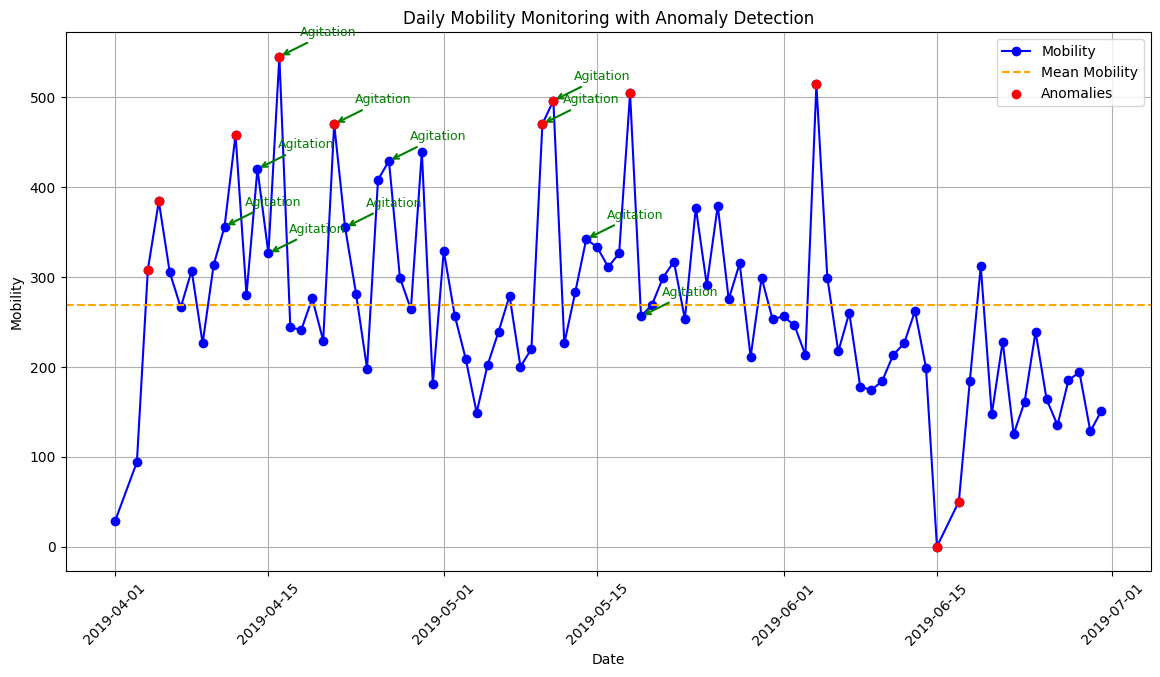

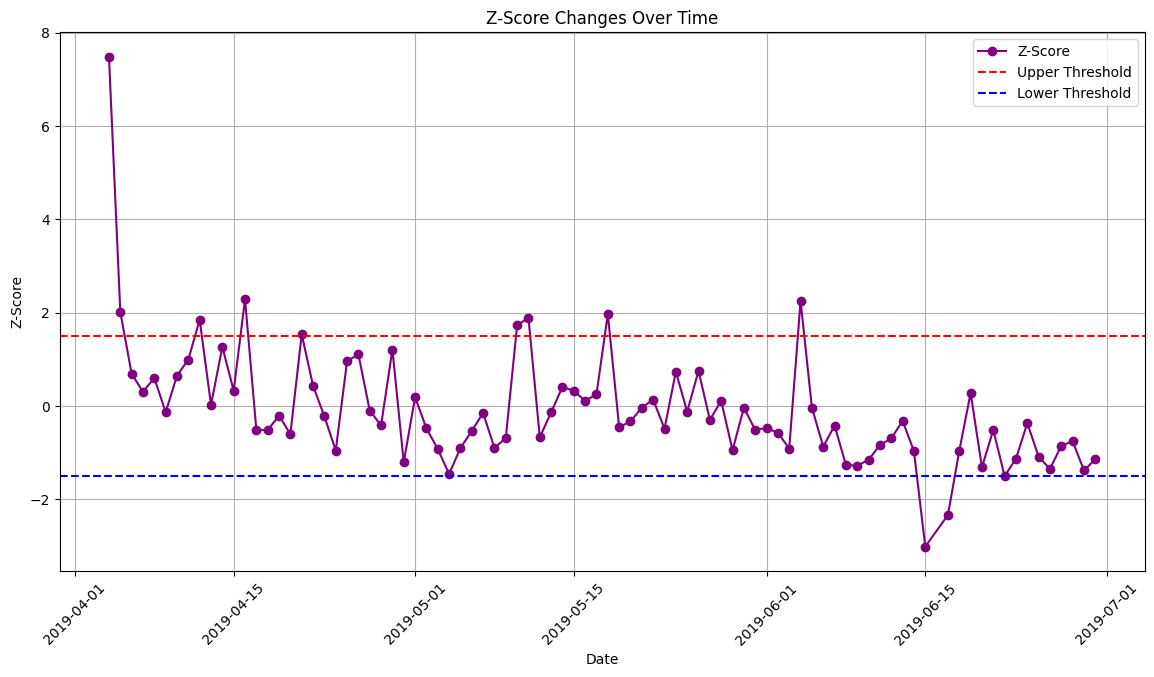

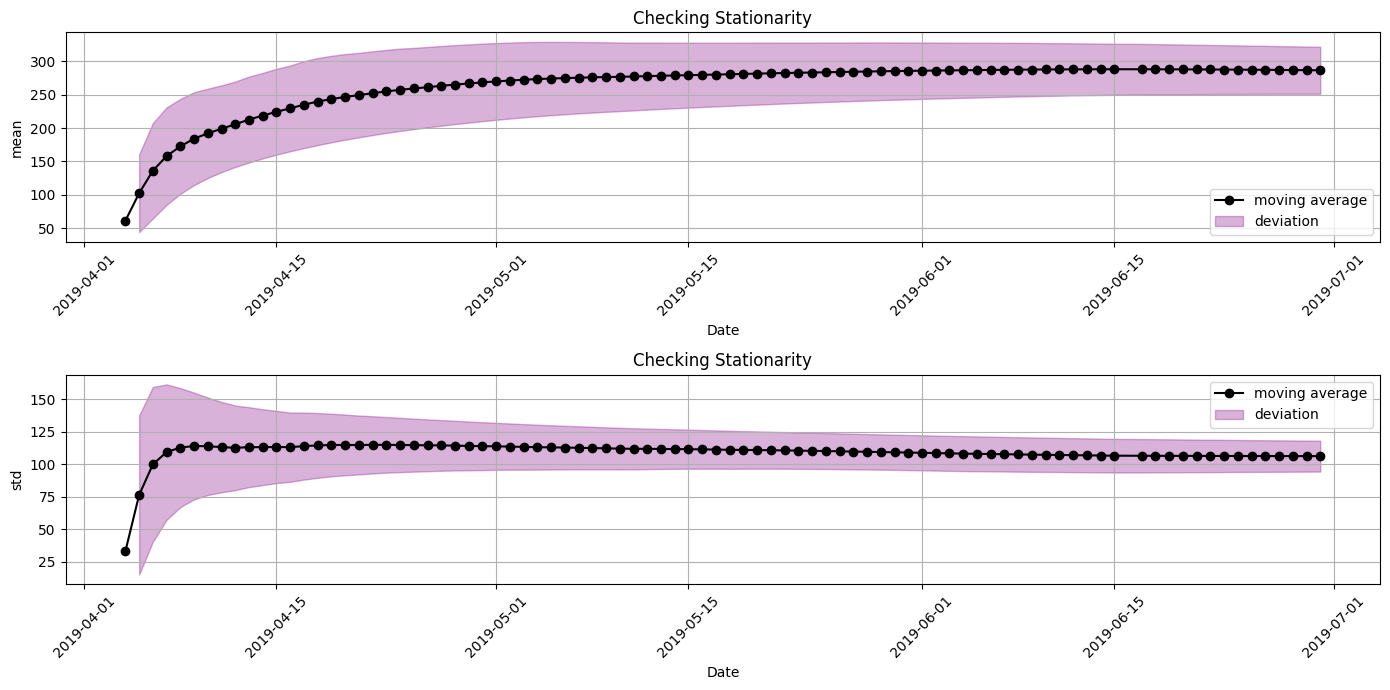

          date  mobility day_type  time_spent_outside patient_id   z_score  \
0   2019-04-01      28.0   normal            0.000000      16f4b       NaN   
1   2019-04-03      94.0   normal            0.000000      16f4b       NaN   
2   2019-04-04     308.0   normal            5.400000      16f4b  7.484848   
3   2019-04-05     384.0   normal            4.266667      16f4b  2.013714   
4   2019-04-06     305.0   normal            4.783333      16f4b  0.691056   
..         ...       ...      ...                 ...        ...       ...   
84  2019-06-26     135.0   normal            7.716667      16f4b -1.346823   
85  2019-06-27     185.0   normal           15.916667      16f4b -0.848061   
86  2019-06-28     194.0   normal           10.250000      16f4b -0.753652   
87  2019-06-29     128.0   normal          132.733333      16f4b -1.378845   
88  2019-06-30     151.0   normal            2.300000      16f4b -1.137275   

    anomaly  z_score_mobility  z_score_outside  anomaly_mobilit

In [35]:
# Initialize columns for z_score and anomaly detection
mobility_df['z_score'] = np.nan
mobility_df['mean'] = np.nan
mobility_df['std'] = np.nan
mobility_df['anomaly'] = False

# Loop through the DataFrame to compute z_scores based on previous data only
for i in range(1, len(mobility_df)):
    # Calculate mean and std for mobility data up to the current day (excluding today)
    previous_mobility = mobility_df['mobility'][:i]

    # Calculate z_score for the current day
    if len(previous_mobility) > 1:
        mean = previous_mobility.mean()
        std = previous_mobility.std(ddof=0)  # Population standard deviation
        current_mobility = mobility_df['mobility'].iloc[i]

        # Calculate z_score
        z_score = (current_mobility - mean) / std if std > 0 else 0

        # Store in DataFrame
        mobility_df.at[i, 'mean'] = mean
        mobility_df.at[i, 'std'] = std
        mobility_df.at[i, 'z_score'] = z_score

        # Define the threshold for anomaly detection
        threshold = 1.5  # Adjust as needed
        # Update anomaly column based on z_score
        mobility_df.at[i, 'anomaly'] = abs(z_score) > threshold


# Mean and std of sample mean and sample standard deviations (std) over time
mobility_df['mean_mean'] = np.nan  # moving average of sample means
mobility_df['mean_std'] = np.nan # moving average of sample stds
mobility_df['std_mean'] = np.nan  # moving std of sample means
mobility_df['std_std'] = np.nan # moving std of sample stds

# Performing rolling mean and std over sample means and stds
mobility_df['mean_mean'] = mobility_df['mean'].expanding().mean()
mobility_df['mean_std'] = mobility_df['std'].expanding().mean()
mobility_df['std_mean'] = mobility_df['mean'].expanding().std()
mobility_df['std_std'] = mobility_df['std'].expanding().std()


# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['mobility'], marker='o', label='Mobility', color='blue')
plt.axhline(y=mobility_df['mobility'].mean(), color='orange', linestyle='--', label='Mean Mobility')

# Plot anomalies if they exist
if mobility_df['anomaly'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly']],
                mobility_df['mobility'][mobility_df['anomaly']],
                color='red', label='Anomalies', zorder=5)

# Adding labels and title
plt.title('Daily Mobility Monitoring with Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Mobility')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Annotate agitation days if needed
for date in agitation_days:
    mobility_value = mobility_df[mobility_df['date'] == date]['mobility'].values[0]  # Get the mobility value for the agitation date
    plt.annotate('Agitation',
                 xy=(date, mobility_value),
                 xytext=(15, 15),  # Offset the text position
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                 fontsize=9,
                 color='green')



# Plotting the z-score changes
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['z_score'], marker='o', label='Z-Score', color='purple')
plt.axhline(y=1.5, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(y=-1.5, color='blue', linestyle='--', label='Lower Threshold')

# Adding labels and title for z-score plot
plt.title('Z-Score Changes Over Time')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid()






fig, axes = plt.subplots(2, 1, figsize=(14, 7))

# Plot mean and std changes over time
# mean change plot
axes[0].plot(mobility_df['date'], mobility_df['mean_mean'], marker='o', label='moving average', color='black')
axes[0].fill_between(mobility_df['date'],
                     mobility_df['mean_mean'] - mobility_df['std_mean'],  # Lower bound (mean - sd)
                     mobility_df['mean_mean'] + mobility_df['std_mean'],  # Upper bound (mean + sd)
                     color='purple', alpha=0.3, label='deviation')
axes[0].set_title('Checking Stationarity')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('mean')
axes[0].tick_params(axis='x', rotation=45)  # Correct way to rotate x-axis labels
axes[0].legend()
axes[0].grid()


# std change plot
axes[1].plot(mobility_df['date'], mobility_df['mean_std'], marker='o', label='moving average', color='black')
axes[1].fill_between(mobility_df['date'],
                     mobility_df['mean_std'] - mobility_df['std_std'],  # Lower bound (mean - sd)
                     mobility_df['mean_std'] + mobility_df['std_std'],  # Upper bound (mean + sd)
                     color='purple', alpha=0.3, label='deviation')
axes[1].set_title('Checking Stationarity')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('std')
axes[1].tick_params(axis='x', rotation=45)  # Correct way to rotate x-axis labels
axes[1].legend()
axes[1].grid()





plt.tight_layout()

# Show the plot
plt.show()

# Display the mobility_df with Z-scores and anomalies
print(mobility_df)

Definin a function to visually check a function to plot mean and variance of a random variable

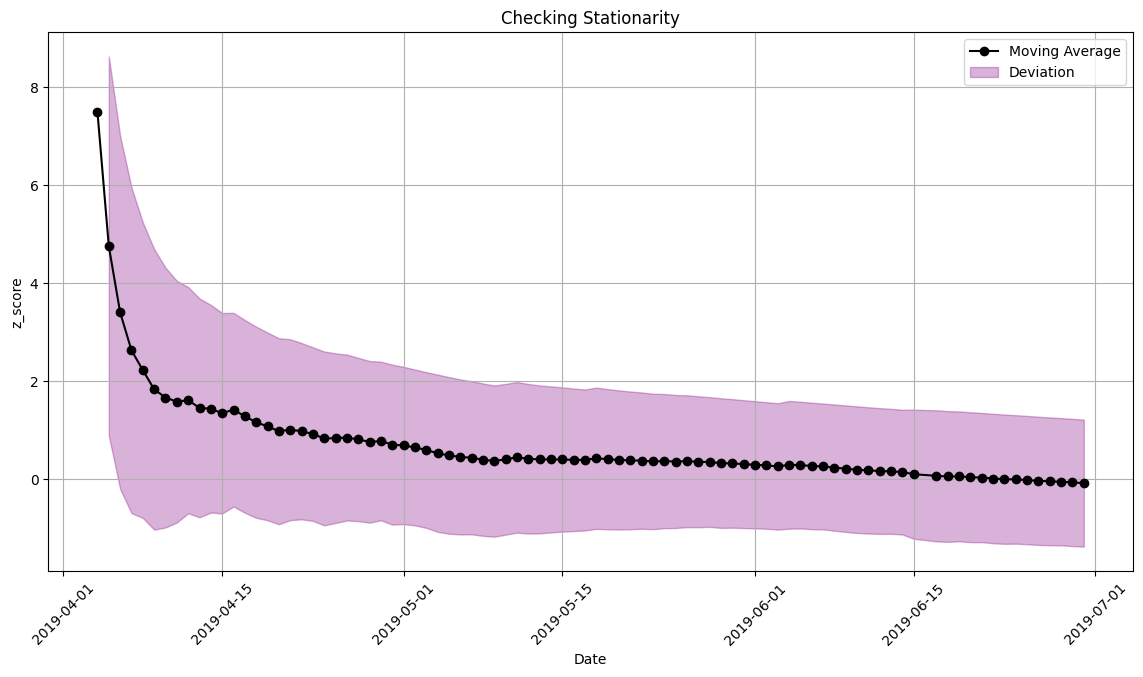

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt


def check_stationarity(mobility_df, col='mean', drop=True):
    mean_col = 'mean_' + col
    std_col = 'std_' + col

    # Mean and std of sample mean and sample standard deviations (std) over time
    mobility_df[mean_col] = np.nan  # moving average of sample means
    mobility_df[std_col] = np.nan  # moving std of sample means

    # Performing rolling mean and std over sample means and stds
    mobility_df[mean_col] = mobility_df[col].expanding().mean()
    mobility_df[std_col] = mobility_df[col].expanding().std()

    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot mean and std changes over time
    ax.plot(mobility_df['date'], mobility_df[mean_col], marker='o', label='Moving Average', color='black')
    ax.fill_between(mobility_df['date'],
                    mobility_df[mean_col] - mobility_df[std_col],  # Lower bound (mean - std)
                    mobility_df[mean_col] + mobility_df[std_col],  # Upper bound (mean + std)
                    color='purple', alpha=0.3, label='Deviation')

    ax.set_title('Checking Stationarity')
    ax.set_xlabel('Date')
    ax.set_ylabel(col)
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
    ax.legend()
    ax.grid()

    plt.show()

    # Drop the added columns if drop==True
    if drop:
        mobility_df.drop(columns=[mean_col, std_col], inplace=True)



# z_score based on mean stationarity check
check_stationarity(mobility_df,'z_score')


**Z-score Analysis based on only previous days for mobility**

**Modified Z-score for mobility**

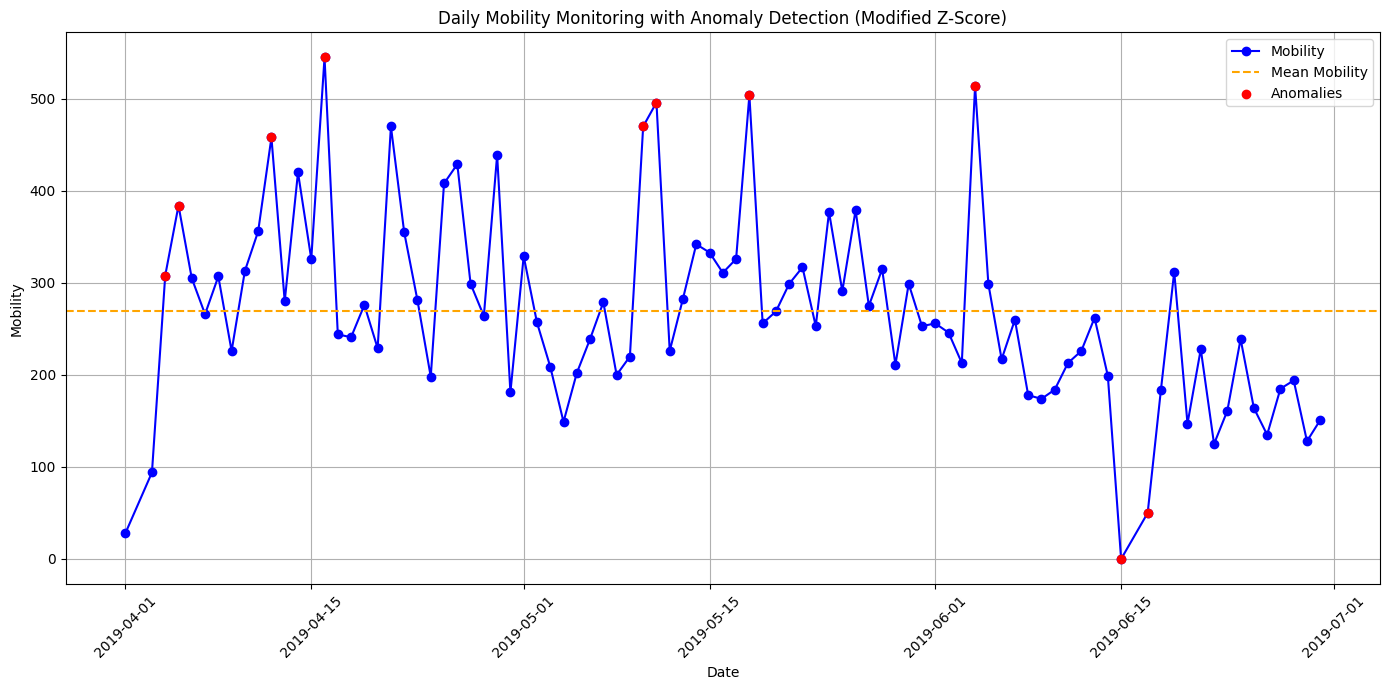

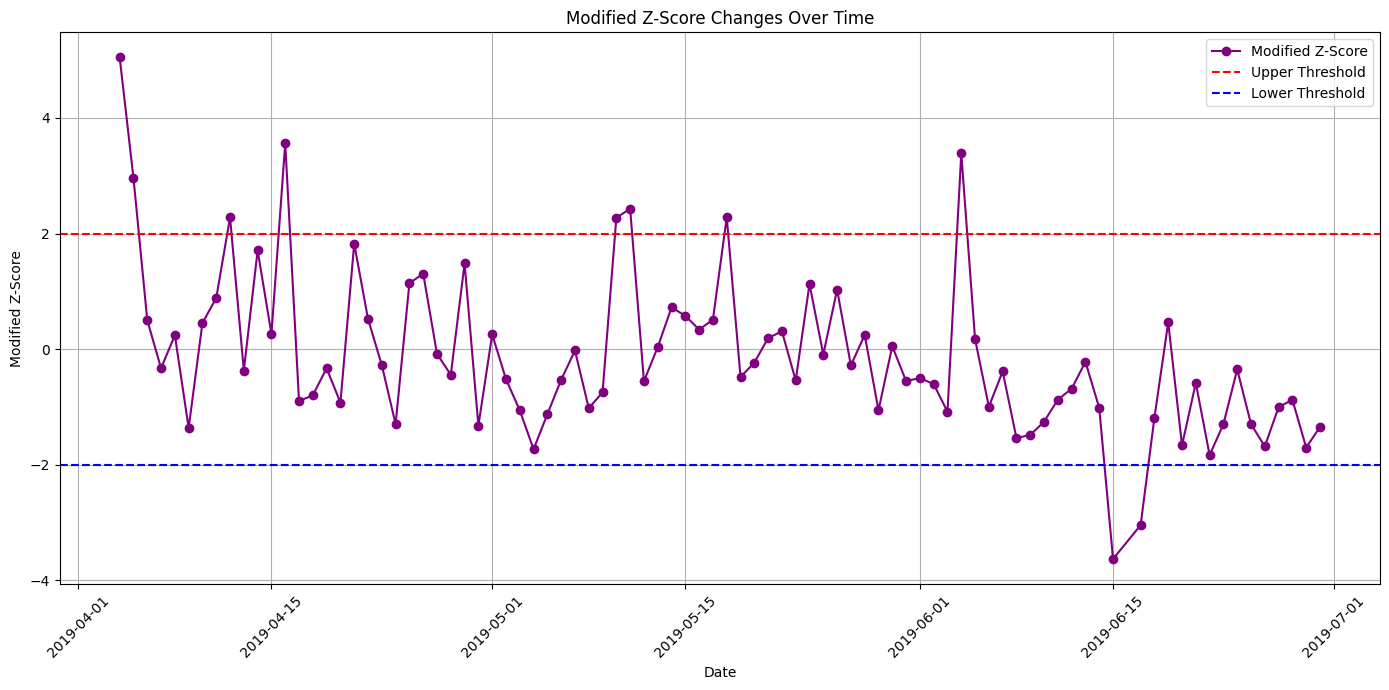

          date  mobility day_type  time_spent_outside patient_id   z_score  \
0   2019-04-01      28.0   normal            0.000000      16f4b       NaN   
1   2019-04-03      94.0   normal            0.000000      16f4b       NaN   
2   2019-04-04     308.0   normal            5.400000      16f4b  7.484848   
3   2019-04-05     384.0   normal            4.266667      16f4b  2.013714   
4   2019-04-06     305.0   normal            4.783333      16f4b  0.691056   
..         ...       ...      ...                 ...        ...       ...   
84  2019-06-26     135.0   normal            7.716667      16f4b -1.346823   
85  2019-06-27     185.0   normal           15.916667      16f4b -0.848061   
86  2019-06-28     194.0   normal           10.250000      16f4b -0.753652   
87  2019-06-29     128.0   normal          132.733333      16f4b -1.378845   
88  2019-06-30     151.0   normal            2.300000      16f4b -1.137275   

          mean         std  anomaly   mean_mean    mean_std   s

In [ ]:
# Initialize columns for modified z_score and anomaly detection
mobility_df['modified_z_score'] = np.nan
mobility_df['anomaly'] = False

# Loop through the DataFrame to compute modified z_scores based on previous data only
for i in range(1, len(mobility_df)):
    # Mobility data up to the current day (excluding today)
    previous_mobility = mobility_df['mobility'][:i]

    # Calculate modified z_score for the current day
    if len(previous_mobility) > 1:
        median = previous_mobility.median()
        mad = np.median(np.abs(previous_mobility - median))  # Calculate MAD

        current_mobility = mobility_df['mobility'].iloc[i]

        # Calculate modified z_score
        if mad > 0:  # Avoid division by zero
            modified_z_score = 0.6745 * (current_mobility - median) / mad
        else:
            modified_z_score = 0  # Assign 0 if MAD is 0

        # Store in DataFrame
        mobility_df.at[i, 'modified_z_score'] = modified_z_score

        # Define the threshold for anomaly detection
        threshold = 2  # Commonly used threshold for modified z-score detection
        # Update anomaly column based on modified_z_score
        mobility_df.at[i, 'anomaly'] = abs(modified_z_score) > threshold

# Plotting the results for mobility and anomalies
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['mobility'], marker='o', label='Mobility', color='blue')
plt.axhline(y=mobility_df['mobility'].mean(), color='orange', linestyle='--', label='Mean Mobility')

# Plot anomalies if they exist
if mobility_df['anomaly'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly']],
                mobility_df['mobility'][mobility_df['anomaly']],
                color='red', label='Anomalies', zorder=5)

# Adding labels and title
plt.title('Daily Mobility Monitoring with Anomaly Detection (Modified Z-Score)')
plt.xlabel('Date')
plt.ylabel('Mobility')
plt.xticks(rotation=45)
plt.legend()
plt.grid()



plt.tight_layout()
plt.show()  # Show the first plot

# Plotting the modified z-score changes
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['modified_z_score'], marker='o', label='Modified Z-Score', color='purple')
plt.axhline(y=threshold, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(y=-1*threshold, color='blue', linestyle='--', label='Lower Threshold')

# Adding labels and title for modified z-score plot
plt.title('Modified Z-Score Changes Over Time')
plt.xlabel('Date')
plt.ylabel('Modified Z-Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # Show the modified z-score plot

# Display the mobility_df with modified Z-scores and anomalies
print(mobility_df)

I-MR Control Chart (Individual Moving Range)

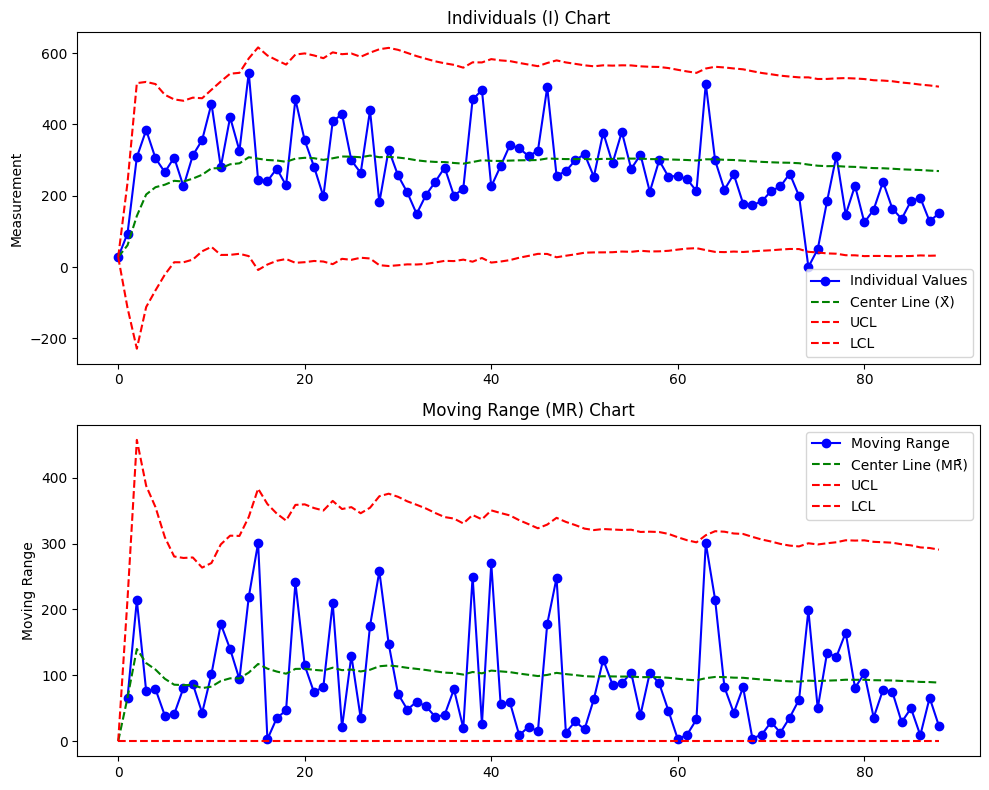

In [87]:
import numpy as np
import matplotlib.pyplot as plt

def imr_control_chart(data):
    # I-MR factors
    A2 = 1.88
    D4 = 3.268
    D3 = 0
    E2 = A2 * np.sqrt(2)

    X_BAR = []
    MR = []
    MR_BAR = []
    UCL_X = []
    LCL_X = []
    UCL_MR = []
    LCL_MR = []

    for i in range(len(data)):
        # Individual values
        x_bar = np.mean(data[:i+1])  # Include the i-th element

        if i == 0:
            mr = np.nan  # No moving range for first point
        else:
            mr = np.abs(data[i] - data[i-1])  # Absolute difference

        MR.append(mr)

        # Compute MR_BAR only for valid values (avoid NaN issues)
        valid_mr = [m for m in MR if not np.isnan(m)]
        mr_bar = np.mean(valid_mr) if valid_mr else 0  # Avoid division by zero

        # Control limits for Individual Chart
        ucl_x = x_bar + E2 * mr_bar
        lcl_x = x_bar - E2 * mr_bar

        # Control limits for Moving Range Chart
        ucl_mr = D4 * mr_bar
        lcl_mr = D3 * mr_bar  # Should be D3 * MR̄, not always 0

        # Append values to lists
        X_BAR.append(x_bar)
        MR_BAR.append(mr_bar)
        UCL_X.append(ucl_x)
        LCL_X.append(lcl_x)
        UCL_MR.append(ucl_mr)
        LCL_MR.append(lcl_mr)

    # Plot Individual Chart
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    ax[0].plot(data, marker='o', linestyle='-', color='b', label='Individual Values')
    ax[0].plot(X_BAR, color='g', linestyle='--', label='Center Line (X̄)')
    ax[0].plot(UCL_X, color='r', linestyle='--', label='UCL')
    ax[0].plot(LCL_X, color='r', linestyle='--', label='LCL')
    ax[0].set_title('Individuals (I) Chart')
    ax[0].set_ylabel('Measurement')
    ax[0].legend()

    # Plot Moving Range Chart
    ax[1].plot(MR, marker='o', linestyle='-', color='b', label='Moving Range')
    ax[1].plot(MR_BAR, color='g', linestyle='--', label='Center Line (MR̄)')
    ax[1].plot(UCL_MR, color='r', linestyle='--', label='UCL')
    ax[1].plot(LCL_MR, color='r', linestyle='--', label='LCL')
    ax[1].set_title('Moving Range (MR) Chart')
    ax[1].set_ylabel('Moving Range')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    return X_BAR, MR, fig, ax


# I-MR chart for mobility values
x_bar, mr, fig, ax = imr_control_chart(mobility_df['mobility'])

for i, date in enumerate(mobility_df['date'].values):  # Ensure full date coverage
    if date in agitation_days:
        ax[0].annotate('Agitation',
                      xy=(i, x_bar[i]),
                      xytext=(15, 15),  # Offset for readability
                      textcoords='offset points',
                      arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                      fontsize=9, color='green')

        ax[1].annotate('Agitation',
                      xy=(i, mr[i]),
                      xytext=(15, 15),  # Offset for readability
                      textcoords='offset points',
                      arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                      fontsize=9, color='green')

plt.show()





**Control Chart for mobility**

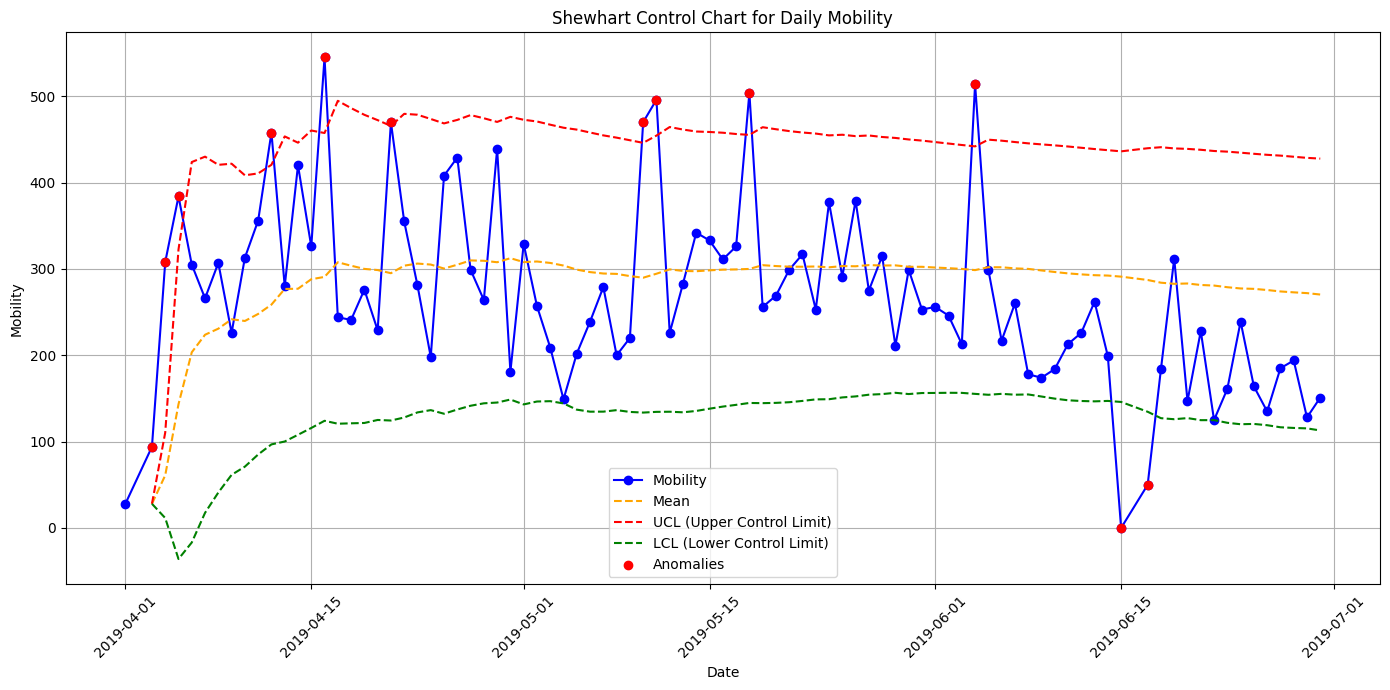

          date  mobility day_type  time_spent_outside patient_id   z_score  \
0   2019-04-01      28.0   normal            0.000000      16f4b       NaN   
1   2019-04-03      94.0   normal            0.000000      16f4b       NaN   
2   2019-04-04     308.0   normal            5.400000      16f4b  7.484848   
3   2019-04-05     384.0   normal            4.266667      16f4b  2.013714   
4   2019-04-06     305.0   normal            4.783333      16f4b  0.691056   
..         ...       ...      ...                 ...        ...       ...   
84  2019-06-26     135.0   normal            7.716667      16f4b -1.346823   
85  2019-06-27     185.0   normal           15.916667      16f4b -0.848061   
86  2019-06-28     194.0   normal           10.250000      16f4b -0.753652   
87  2019-06-29     128.0   normal          132.733333      16f4b -1.378845   
88  2019-06-30     151.0   normal            2.300000      16f4b -1.137275   

          mean         std  anomaly   mean_mean    mean_std   s

In [ ]:
# Initialize columns for mean and control limits
mobility_df['mean'] = np.nan
mobility_df['UCL'] = np.nan  # Upper Control Limit
mobility_df['LCL'] = np.nan  # Lower Control Limit
mobility_df['anomaly'] = False

# Loop through the DataFrame to compute mean and control limits based on previous data only
for i in range(1, len(mobility_df)):
    # Mobility data up to the current day (excluding today)
    previous_mobility = mobility_df['mobility'][:i]

    # Calculate mean and standard deviation for the previous days
    mean = previous_mobility.mean()
    std_dev = previous_mobility.std(ddof=0)  # Population standard deviation

    # Calculate control limits
    threshold = 1.5
    UCL = mean + threshold * std_dev  # Upper Control Limit
    LCL = mean - threshold * std_dev  # Lower Control Limit

    # Store in DataFrame
    mobility_df.at[i, 'mean'] = mean
    mobility_df.at[i, 'UCL'] = UCL
    mobility_df.at[i, 'LCL'] = LCL

    # Check for anomalies
    current_mobility = mobility_df['mobility'].iloc[i]
    if current_mobility > UCL or current_mobility < LCL:
        mobility_df.at[i, 'anomaly'] = True  # Mark as an anomaly

# Plotting the results for mobility and control limits
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['mobility'], marker='o', label='Mobility', color='blue')
plt.plot(mobility_df['date'], mobility_df['mean'], linestyle='--', color='orange', label='Mean')
plt.plot(mobility_df['date'], mobility_df['UCL'], linestyle='--', color='red', label='UCL (Upper Control Limit)')
plt.plot(mobility_df['date'], mobility_df['LCL'], linestyle='--', color='green', label='LCL (Lower Control Limit)')

# Highlight anomalies
if mobility_df['anomaly'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly']],
                mobility_df['mobility'][mobility_df['anomaly']],
                color='red', label='Anomalies', zorder=5)

# Adding labels and title
plt.title('Shewhart Control Chart for Daily Mobility')
plt.xlabel('Date')
plt.ylabel('Mobility')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # Show the control chart

# Display the mobility_df with mean, UCL, LCL, and anomalies
print(mobility_df)

Bayesian EWMA control chart under squared error loss function

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

class BayesianEWMAControlChart:
    def __init__(self, data, sigma=None, lambda_val=None, prior_mean=None, prior_sigma=None, L=None,
                 alpha=0.0027, target_in_control_arl=370, auto_optimize=False):
        """
        Initialize the Bayesian EWMA Control Chart with intelligent hyperparameter selection

        Parameters:
        -----------
        data : array-like
            Historical data used for parameter estimation
        sigma : float, optional (default=None)
            Known standard deviation of the process. If None, estimated from data.
        lambda_val : float, optional (default=None)
            Smoothing parameter for EWMA (between 0 and 1). If None, auto-selected.
        prior_mean : float, optional (default=None)
            Prior mean (μ₀). If None, estimated from data.
        prior_sigma : float, optional (default=None)
            Prior standard deviation (σ₀). If None, estimated based on data uncertainty.
        L : float, optional (default=None)
            Width of control limits in standard deviations. If None, based on false alarm rate.
        alpha : float, optional (default=0.0027)
            Target false alarm rate (Type I error). 0.0027 corresponds to 3 sigma limits.
        target_in_control_arl : int, optional (default=370)
            Target Average Run Length when process is in control.
        auto_optimize : bool, optional (default=False)
            Whether to automatically optimize lambda for the best shift detection.
        """
        self.data = np.array(data)
        self.n = len(self.data)
        self.sample_mean = np.mean(self.data)
        self.sample_std = np.std(self.data, ddof=1)
        self.alpha = alpha
        self.target_in_control_arl = target_in_control_arl

        # Set L (control limit width)
        if L is not None:
            self.L = L
        else:
            # Set L based on desired false alarm rate (alpha)
            self.L = abs(norm.ppf(alpha/2))  # Two-sided control limits


        # Set sigma (process standard deviation)
        self.none_sigma_flag = True
        if sigma is not None:
          self.sigma = sigma
          self.none_sigma_flag = False
        else:
           self.sigma = self.sample_std

        # Set prior_mean (μ₀)
        self.non_prior_mean_flag = True
        if prior_mean is not None:
            self.prior_mean = prior_mean
            self.non_prior_mean_flag = False
        else:
            # Use sample mean as prior mean for central tendency
            self.prior_mean = self.sample_mean

        # Set prior_sigma (σ₀)
        self.none_prior_sigma_flag = True
        if prior_sigma is not None:
            self.prior_sigma = prior_sigma
            self.none_prior_sigma_flag = False
        else:
            # Set prior sigma based on sample size and variation
            # With smaller sample sizes, use a more informative prior
            # With larger sample sizes, rely more on the data
            if self.n < 10:
                # For small samples, use a moderately informative prior
                self.prior_sigma = self.sigma * 2
            elif self.n < 30:
                # For medium samples, use a weakly informative prior
                self.prior_sigma = self.sigma * 5
            else:
                # For large samples, use a non-informative prior
                self.prior_sigma = self.sigma * 10

        # Set lambda_val
        self.lambda_val = lambda_val

        # Initialize EWMA statistic
        self.ewma_stats = []
        self.control_limits = []

        # Print selected hyperparameters
        print(f"Hyperparameters Selected:")
        print(f"  Prior Mean (μ₀): {self.prior_mean:.4f}")
        print(f"  Prior Sigma (σ₀): {self.prior_sigma:.4f}")
        print(f"  Lambda (λ): {self.lambda_val:.4f}")
        print(f"  Control Limit Width (L): {self.L:.4f}")
        print(f"  Process Sigma (σ): {self.sigma:.4f}")

    def _estimate_arl(self, lambda_val, shift_size=0.0):
        """Estimate ARL through simulation for given lambda and shift size"""
        # Simple Monte Carlo simulation for ARL estimation
        n_simulations = 1000
        run_lengths = []

        for _ in range(n_simulations):
            run_length = 0
            ewma = self.posterior_mean

            while True:
                # Generate data with shift
                x = np.random.normal(self.posterior_mean + shift_size * self.sigma, self.sigma)
                # Update EWMA
                ewma = lambda_val * x + (1 - lambda_val) * ewma
                run_length += 1

                # Check if out of control
                k = run_length
                factor = np.sqrt(lambda_val / (2 - lambda_val) * (1 - (1 - lambda_val)**(2*k)))
                ucl = self.posterior_mean + self.L * np.sqrt(self.posterior_var + self.sigma**2) * factor
                lcl = self.posterior_mean - self.L * np.sqrt(self.posterior_var + self.sigma**2) * factor

                if ewma > ucl or ewma < lcl:
                    break

                # Cap run length to avoid infinite loops
                if run_length > 10000:
                    break

            run_lengths.append(run_length)

        return np.mean(run_lengths)

    def _update_prior(self,new_observation):
        self.data = np.append(self.data,new_observation)
        self.n = len(self.data)
        self.sample_mean = np.mean(self.data)
        self.sample_std = np.std(self.data, ddof=1)

        # Set sigma (process standard deviation)
        if self.none_sigma_flag:
           self.sigma = self.sample_std

        # Set prior_mean (μ₀)
        if self.non_prior_mean_flag:
          # Use sample mean as prior mean for central tendency
          self.prior_mean = self.sample_mean

        # Set prior_sigma (σ₀)
        if self.none_prior_sigma_flag:
          # Set prior sigma based on sample size and variation
          # With smaller sample sizes, use a more informative prior
          # With larger sample sizes, rely more on the data
          if self.n < 10:
              # For small samples, use a moderately informative prior
              self.prior_sigma = self.sigma * 2
          elif self.n < 30:
              # For medium samples, use a weakly informative prior
              self.prior_sigma = self.sigma * 5
          else:
              # For large samples, use a non-informative prior
              self.prior_sigma = self.sigma * 10


    def _calculate_posterior_mean(self):
        """Calculate posterior mean using Equation 3.8"""
        numerator = self.n * self.x_bar * self.prior_sigma**2 + self.sigma**2 * self.prior_mean
        denominator = self.sigma**2 + self.n * self.prior_sigma**2
        return numerator / denominator

    def _calculate_posterior_variance(self):
        """Calculate posterior variance using Equation 3.8"""
        return (self.sigma**2 * self.prior_sigma**2) / (self.sigma**2 + self.n * self.prior_sigma**2)

    def _calculate_control_limits(self, k):
        """
        Calculate control limits for k steps ahead using Equations 3.10 and 3.11

        Parameters:
        -----------
        k : int
            Number of steps ahead

        Returns:
        --------
        tuple: (LCL, CL, UCL)
        """
        # EWMA variance factor
        factor = np.sqrt(self.lambda_val / (2 - self.lambda_val) * (1 - (1 - self.lambda_val)**(2*k)))

        # Control limits from Equations 3.10 and 3.11
        CL = self.posterior_mean
        w = np.sqrt(self.posterior_var + self.sigma**2)

        UCL = CL + self.L * w * factor
        LCL = CL - self.L * w * factor

        return LCL, CL, UCL

    def update(self, new_observation):
        """
        Update the EWMA statistic with a new observation

        Parameters:
        -----------
        new_observation : float
            New data point to monitor

        Returns:
        --------
        tuple: (ewma_stat, LCL, CL, UCL, is_out_of_control)
        """
        # Initialize EWMA if this is the first update
        if not self.ewma_stats:
            ewma_stat = self.lambda_val * new_observation + (1 - self.lambda_val) * self.prior_mean
        else:
            ewma_stat = self.lambda_val * new_observation + (1 - self.lambda_val) * self.ewma_stats[-1]

        self.ewma_stats.append(ewma_stat)
        k = len(self.ewma_stats)

        # Calculate x_bar, which is the sample mean with respect to the observed sample
        self.x_bar = np.mean(np.append(self.data,new_observation))

        # Calculate posterior parameters under squared error loss function - MOVED UP
        self.posterior_mean = self._calculate_posterior_mean()
        self.posterior_var = self._calculate_posterior_variance()
        self.predictive_var = self.sigma**2 + self.posterior_var

        # Calculate control limits for this step
        LCL, CL, UCL = self._calculate_control_limits(k)
        self.control_limits.append((LCL, CL, UCL))

        # Check if the point is out of control
        is_out_of_control = ewma_stat > UCL or ewma_stat < LCL

        # Update historical data, sigma, prior_mean, and prior_sigma if a fixed value was npt assigned to them
        self._update_prior(new_observation)
        return ewma_stat, LCL, CL, UCL, is_out_of_control

    def plot(self):
        """Plot the Bayesian EWMA control chart"""
        if not self.ewma_stats:
            raise ValueError("No data points have been processed yet. Use update() method first.")

        plt.figure(figsize=(12, 6))

        # Extract control limits
        lcls = [limits[0] for limits in self.control_limits]
        cls = [limits[1] for limits in self.control_limits]
        ucls = [limits[2] for limits in self.control_limits]

        # Plot EWMA statistic
        plt.plot(self.ewma_stats, marker='o', linestyle='-', color='blue', label='EWMA Statistic')

        # Plot control limits
        plt.plot(ucls, 'r--', label='UCL')
        plt.plot(cls, 'g-', label='CL')
        plt.plot(lcls, 'r--', label='LCL')

        # Highlight out-of-control points
        for i, (ewma, (lcl, _, ucl)) in enumerate(zip(self.ewma_stats, self.control_limits)):
            if ewma > ucl or ewma < lcl:
                plt.plot(i, ewma, 'ro', markersize=10)

        plt.title(f'Bayesian EWMA Control Chart (λ={self.lambda_val:.2f}, L={self.L:.2f})')
        plt.xlabel('Sample Number')
        plt.ylabel('EWMA Statistic')
        plt.legend()
        plt.grid(True)

        return plt.gcf()

    def sensitivity_analysis(self, lambdas=[0.05, 0.1, 0.2, 0.3, 0.4],
                            Ls=[2.0, 2.5, 3.0, 3.5],
                            prior_sigmas=None):
        """
        Perform sensitivity analysis on key hyperparameters

        Parameters:
        -----------
        lambdas : list of float
            Lambda values to test
        Ls : list of float
            Control limit widths to test
        prior_sigmas : list of float, optional
            Prior sigma values to test. If None, estimated based on sigma.

        Returns:
        --------
        dict: Sensitivity analysis results
        """
        if prior_sigmas is None:
            prior_sigmas = [self.sigma, self.sigma*2, self.sigma*5, self.sigma*10]

        results = {}

        # Function to estimate ARLs
        def estimate_arls(lambda_val, L, prior_sigma):
            # Create temporary chart with these parameters
            temp_chart = BayesianEWMAControlChart(
                data=self.data,
                sigma=self.sigma,
                lambda_val=lambda_val,
                prior_mean=self.prior_mean,
                prior_sigma=prior_sigma,
                L=L
            )

            # Estimate ARL for in-control and various shift sizes
            arls = {
                'in_control': temp_chart._estimate_arl(lambda_val, shift_size=0.0),
                'shift_0.5sigma': temp_chart._estimate_arl(lambda_val, shift_size=0.5),
                'shift_1sigma': temp_chart._estimate_arl(lambda_val, shift_size=1.0),
                'shift_2sigma': temp_chart._estimate_arl(lambda_val, shift_size=2.0)
            }
            return arls

        # Perform analysis on lambda and L combinations
        for lambda_val in lambdas:
            for L in Ls:
                for prior_sigma in prior_sigmas:
                    key = f"lambda={lambda_val:.2f}, L={L:.1f}, prior_sigma={prior_sigma:.2f}"
                    results[key] = estimate_arls(lambda_val, L, prior_sigma)

        # Print results
        print("\nSensitivity Analysis Results:")
        print("-----------------------------")
        print(f"{'Parameters':<40} {'In-Control ARL':<15} {'ARL at 0.5σ':<15} {'ARL at 1σ':<15} {'ARL at 2σ':<15}")
        print("-" * 100)

        for key, arls in results.items():
            print(f"{key:<40} {arls['in_control']:<15.1f} {arls['shift_0.5sigma']:<15.1f} {arls['shift_1sigma']:<15.1f} {arls['shift_2sigma']:<15.1f}")

        return results

Hyperparameters Selected:
  Prior Mean (μ₀): 0.0000
  Prior Sigma (σ₀): 0.0000
  Lambda (λ): 0.2000
  Control Limit Width (L): 2.6600
  Process Sigma (σ): 24.8982


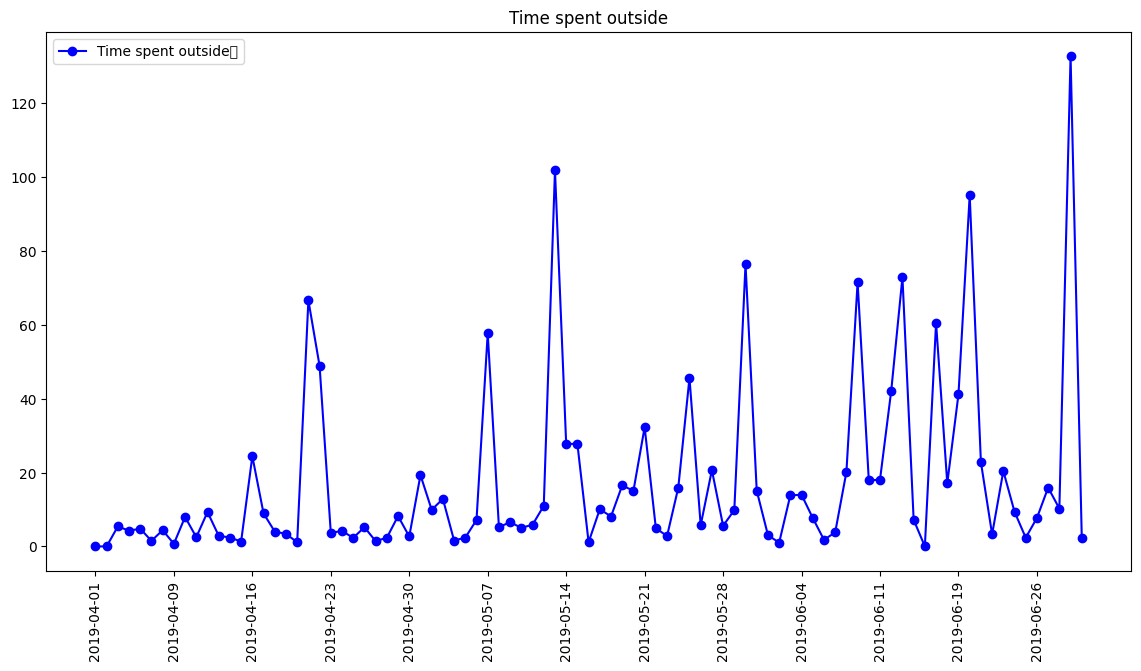

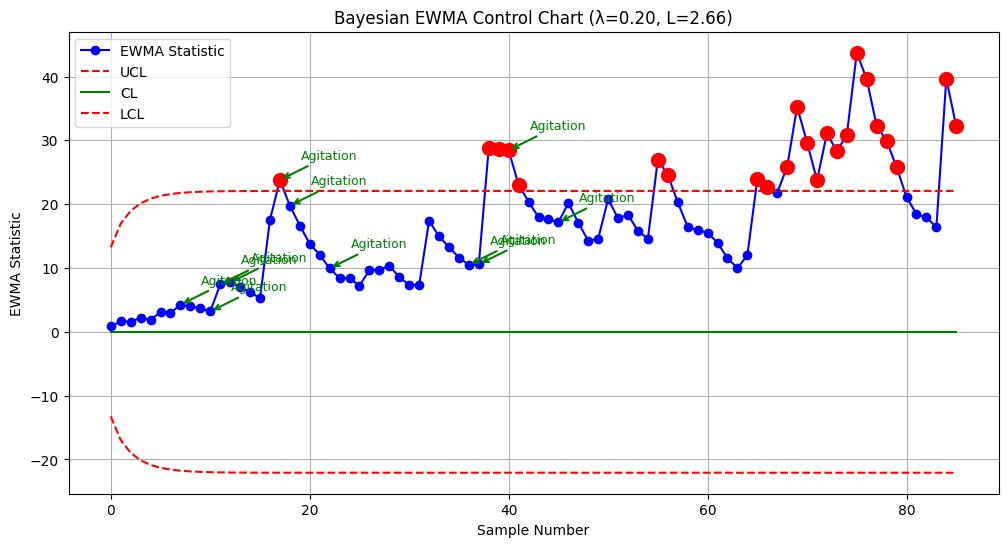


Monitoring Results:
  Number of out-of-control points: 23
  First detection at sample: 17


In [93]:
# Use N initial samples to obtain initial values for time_spent_outside
N = 2

# Assuming we know sigma
sigma = np.std(mobility_df['time_spent_outside'].values)

# Extracting historcata
historical_data = mobility_df.loc[:N,'time_spent_outside'].values
monitoring_data =mobility_df.loc[N+1:,'time_spent_outside'].values

# Initialize the Bayesian EWMA chart with automatic hyperparameter selection
chart = BayesianEWMAControlChart(
    data=historical_data,
    sigma = sigma,
    prior_sigma = 0,
    prior_mean=0,
    lambda_val=0.2, # Set Lambda to 0.2
    L=2.66
)

# Optionally run sensitivity analysis
# Uncomment to run (can be computationally intensive)
# chart.sensitivity_analysis()

# Update chart with new data
out_of_control_points = []
for i, obs in enumerate(monitoring_data):
    _, lcl, cl, ucl, is_out_of_control = chart.update(obs)
    if is_out_of_control:
        out_of_control_points.append(i)

# Define consistent x-ticks for both plots
tick_positions = range(0, len(mobility_df['date']), 7)
tick_labels = mobility_df['date'].iloc[tick_positions]  # Selecting corresponding dates

# Plot mobility data
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['time_spent_outside'], marker='o', label='Time spent outside	', color='blue')
plt.title('Time spent outside')
#plt.axvline(x=N+out_of_control_points[0] , color='green', label='Shift Point')
#plt.axvline(x=N, color='black', label='Border of historical and monitoring data')
plt.xticks(tick_positions, tick_labels, rotation=90)  # Apply consistent x-ticks

plt.legend()
plt.show()

# Plot the control chart
tick_positions = range(N, len(mobility_df['date']), 7)
tick_labels = mobility_df['date'].iloc[tick_positions]  # Selecting corresponding dates

fig = chart.plot()
#plt.axvline(x=out_of_control_points[0] , color='green', label='Shift Point')

monitoring_days = mobility_df.loc[N:,'date'].values
for i,date in enumerate(monitoring_days):

  if date in agitation_days:
    plt.annotate('Agitation',
                  xy=(i, chart.ewma_stats[i]),
                  xytext=(15, 15),  # Offset for readability
                  textcoords='offset points',
                  arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                  fontsize=9, color='green')
plt.legend()
plt.show()
# Print results
print(f"\nMonitoring Results:")
print(f"  Number of out-of-control points: {len(out_of_control_points)}")
print(f"  First detection at sample: {out_of_control_points[0] if out_of_control_points else 'None'}")

plt.show()

Hyperparameters Selected:
  Prior Mean (μ₀): 143.3333
  Prior Sigma (σ₀): 210.2403
  Lambda (λ): 0.1000
  Control Limit Width (L): 2.6600
  Process Sigma (σ): 105.1202


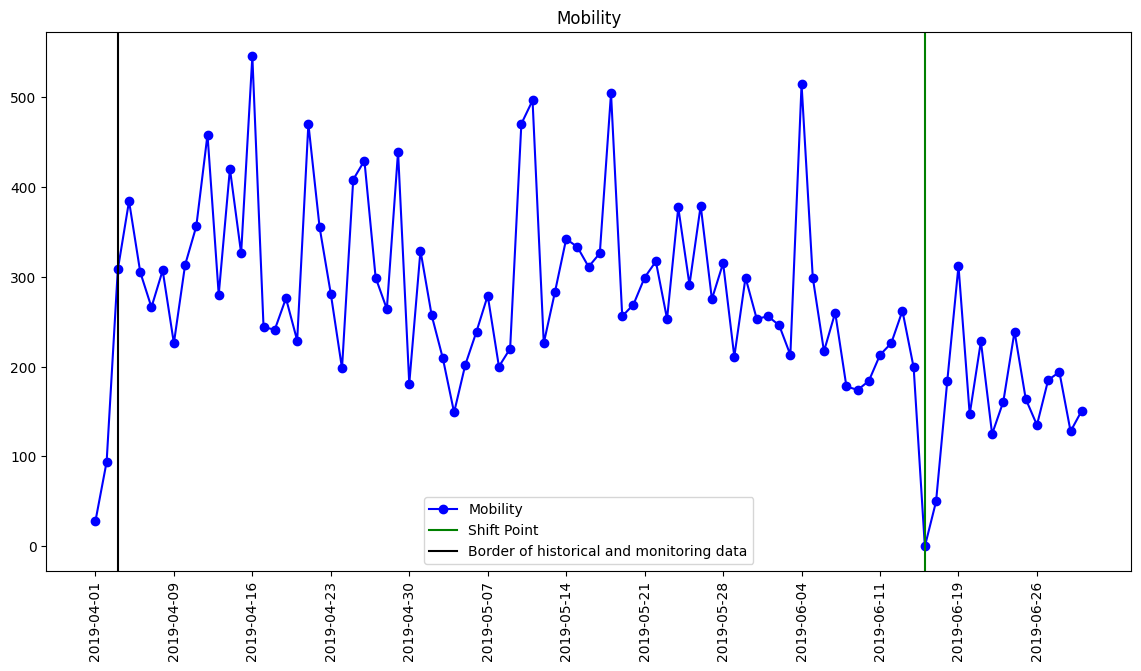

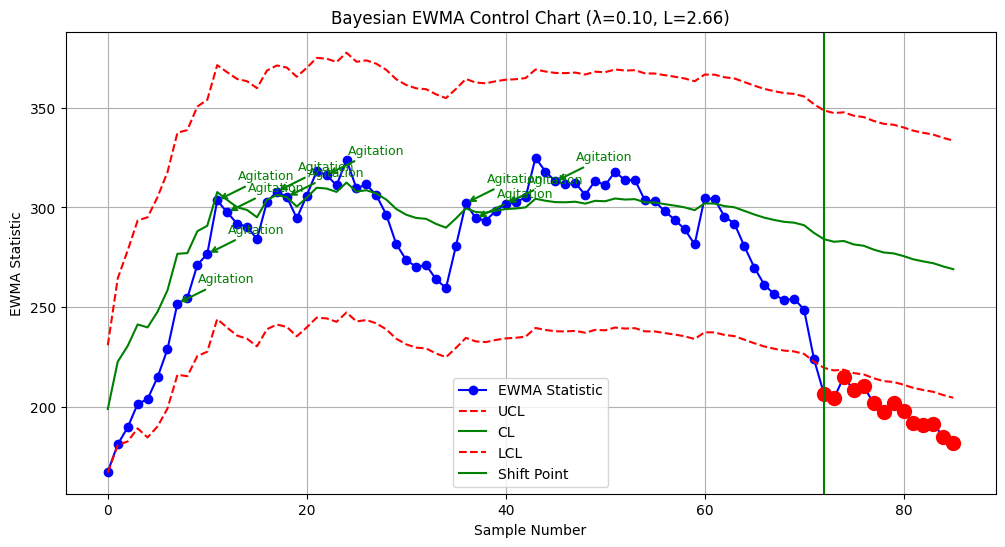


Monitoring Results:
  Number of out-of-control points: 14
  First detection at sample: 72


In [96]:
# Use N initial samples to obtain initial values
N = 2

# Assuming we know sigma
sigma = np.std(mobility_df['mobility'].values)

# Extracting historcata
historical_data = mobility_df.loc[:N,'mobility'].values
monitoring_data =mobility_df.loc[N+1:,'mobility'].values

# Initialize the Bayesian EWMA chart with automatic hyperparameter selection
chart = BayesianEWMAControlChart(
    data=historical_data,
    sigma=sigma,
    lambda_val=0.1, # Set Lambda to 0.2
    L=2.66
)

# Optionally run sensitivity analysis
# Uncomment to run (can be computationally intensive)
# chart.sensitivity_analysis()

# Update chart with new data
out_of_control_points = []
for i, obs in enumerate(monitoring_data):
    _, lcl, cl, ucl, is_out_of_control = chart.update(obs)
    if is_out_of_control:
        out_of_control_points.append(i)

# Define consistent x-ticks for both plots
tick_positions = range(0, len(mobility_df['date']), 7)
tick_labels = mobility_df['date'].iloc[tick_positions]  # Selecting corresponding dates

# Plot mobility data
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['mobility'], marker='o', label='Mobility', color='blue')
plt.title('Mobility')
plt.axvline(x=N+out_of_control_points[0] , color='green', label='Shift Point')
plt.axvline(x=N, color='black', label='Border of historical and monitoring data')
plt.xticks(tick_positions, tick_labels, rotation=90)  # Apply consistent x-ticks

plt.legend()
plt.show()

# Plot the control chart
tick_positions = range(N, len(mobility_df['date']), 7)
tick_labels = mobility_df['date'].iloc[tick_positions]  # Selecting corresponding dates

fig = chart.plot()
plt.axvline(x=out_of_control_points[0] , color='green', label='Shift Point')

monitoring_days = mobility_df.loc[N:,'date'].values
for i,date in enumerate(monitoring_days):

  if date in agitation_days:
    plt.annotate('Agitation',
                  xy=(i, chart.ewma_stats[i]),
                  xytext=(15, 15),  # Offset for readability
                  textcoords='offset points',
                  arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                  fontsize=9, color='green')
plt.legend()
plt.show()
# Print results
print(f"\nMonitoring Results:")
print(f"  Number of out-of-control points: {len(out_of_control_points)}")
print(f"  First detection at sample: {out_of_control_points[0] if out_of_control_points else 'None'}")

plt.show()

Hyperparameters Selected:
  Prior Mean (μ₀): 143.3333
  Prior Sigma (σ₀): 292.7479
  Lambda (λ): 0.1000
  Control Limit Width (L): 2.6600
  Process Sigma (σ): 146.3740


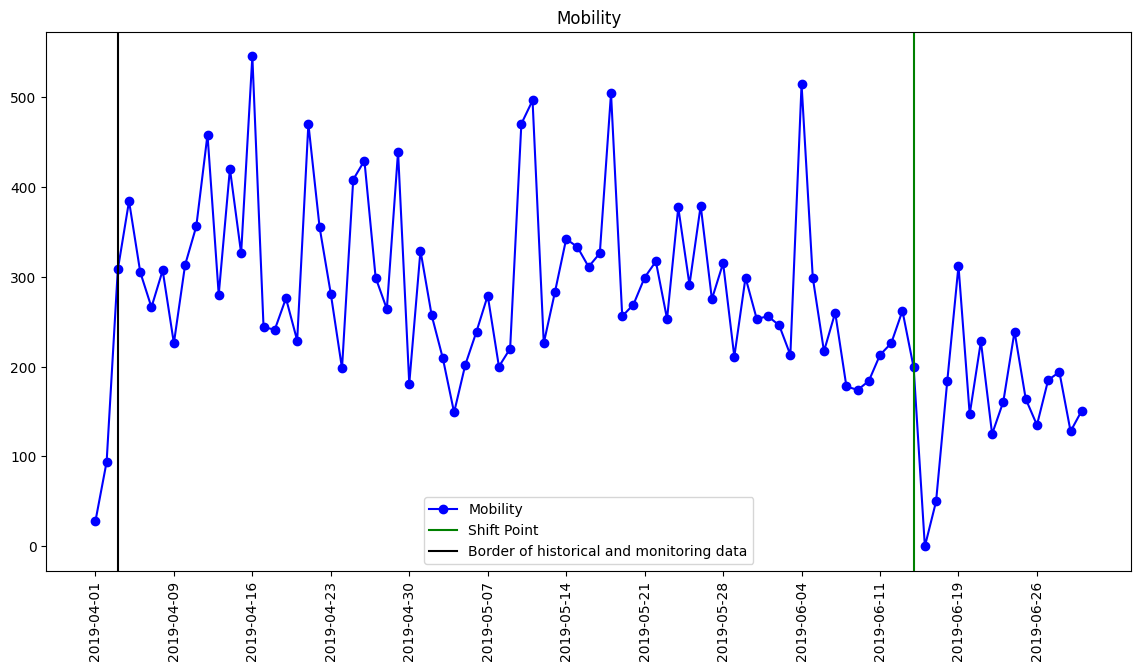

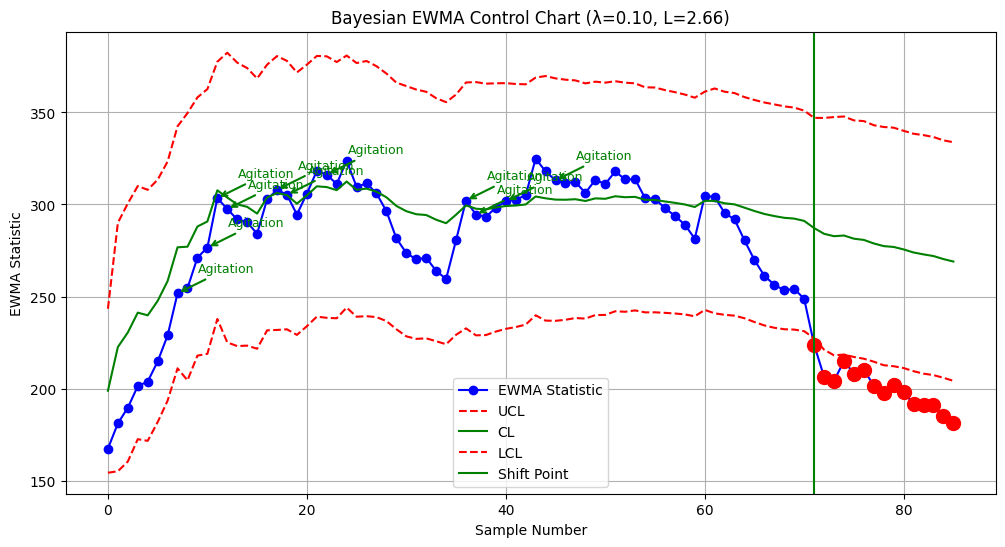


Monitoring Results:
  Number of out-of-control points: 15
  First detection at sample: 71


In [97]:
# Use N initial samples to obtain initial values (dynamically-calculated mu0 and sigma0 and sigma)
N = 2

# Extracting historcata
historical_data = mobility_df.loc[:N,'mobility'].values
monitoring_data =mobility_df.loc[N+1:,'mobility'].values

# Initialize the Bayesian EWMA chart with automatic hyperparameter selection
chart = BayesianEWMAControlChart(
    data=historical_data,
    lambda_val=0.1, # Set Lambda to 0.2
    L=2.66
)

# Optionally run sensitivity analysis
# Uncomment to run (can be computationally intensive)
# chart.sensitivity_analysis()

# Update chart with new data
out_of_control_points = []
for i, obs in enumerate(monitoring_data):
    _, lcl, cl, ucl, is_out_of_control = chart.update(obs)
    if is_out_of_control:
        out_of_control_points.append(i)

# Define consistent x-ticks for both plots
tick_positions = range(0, len(mobility_df['date']), 7)
tick_labels = mobility_df['date'].iloc[tick_positions]  # Selecting corresponding dates

# Plot mobility data
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['mobility'], marker='o', label='Mobility', color='blue')
plt.title('Mobility')
plt.axvline(x=N+out_of_control_points[0] , color='green', label='Shift Point')
plt.axvline(x=N, color='black', label='Border of historical and monitoring data')
plt.xticks(tick_positions, tick_labels, rotation=90)  # Apply consistent x-ticks

plt.legend()
plt.show()

# Plot the control chart
tick_positions = range(N, len(mobility_df['date']), 7)
tick_labels = mobility_df['date'].iloc[tick_positions]  # Selecting corresponding dates

fig = chart.plot()
plt.axvline(x=out_of_control_points[0] , color='green', label='Shift Point')

monitoring_days = mobility_df.loc[N:,'date'].values
for i,date in enumerate(monitoring_days):

  if date in agitation_days:
    plt.annotate('Agitation',
                  xy=(i, chart.ewma_stats[i]),
                  xytext=(15, 15),  # Offset for readability
                  textcoords='offset points',
                  arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                  fontsize=9, color='green')
plt.legend()
plt.show()
# Print results
print(f"\nMonitoring Results:")
print(f"  Number of out-of-control points: {len(out_of_control_points)}")
print(f"  First detection at sample: {out_of_control_points[0] if out_of_control_points else 'None'}")

plt.show()

Hyperparameters Selected:
  Prior Mean (μ₀): 1.8000
  Prior Sigma (σ₀): 6.2354
  Lambda (λ): 0.2000
  Control Limit Width (L): 2.6600
  Process Sigma (σ): 3.1177


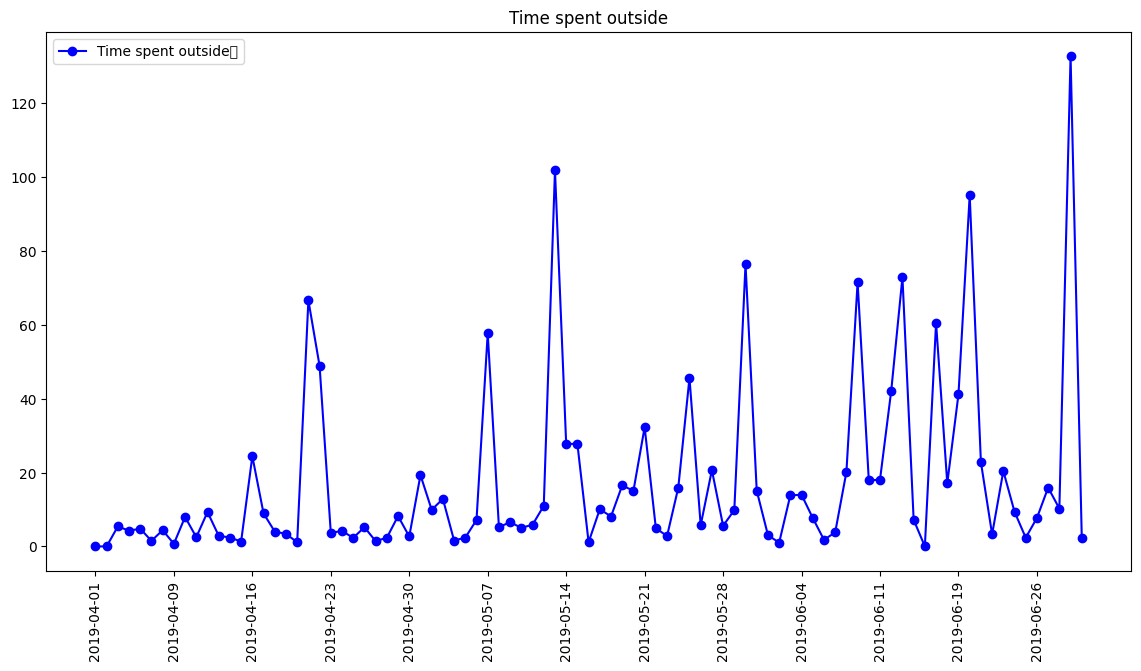

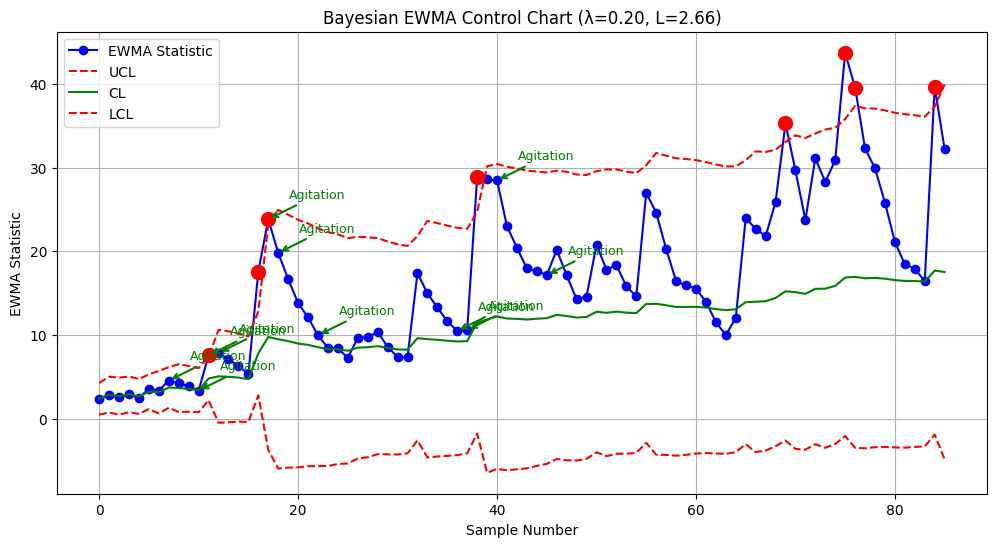


Monitoring Results:
  Number of out-of-control points: 8
  First detection at sample: 11


In [92]:
# Use N initial samples to obtain initial values for time_spent_outside	(dynamically-calculated mu0 and sigma0 and sigma)
N = 2

# Extracting historcata
historical_data = mobility_df.loc[:N,'time_spent_outside'].values
monitoring_data =mobility_df.loc[N+1:,'time_spent_outside'].values

# Initialize the Bayesian EWMA chart with automatic hyperparameter selection
chart = BayesianEWMAControlChart(
    data=historical_data,
    lambda_val=0.2, # Set Lambda to 0.2
    L=2.66
)

# Optionally run sensitivity analysis
# Uncomment to run (can be computationally intensive)
# chart.sensitivity_analysis()

# Update chart with new data
out_of_control_points = []
for i, obs in enumerate(monitoring_data):
    _, lcl, cl, ucl, is_out_of_control = chart.update(obs)
    if is_out_of_control:
        out_of_control_points.append(i)

# Define consistent x-ticks for both plots
tick_positions = range(0, len(mobility_df['date']), 7)
tick_labels = mobility_df['date'].iloc[tick_positions]  # Selecting corresponding dates

# Plot mobility data
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['time_spent_outside'], marker='o', label='Time spent outside	', color='blue')
plt.title('Time spent outside')
#plt.axvline(x=N+out_of_control_points[0] , color='green', label='Shift Point')
#plt.axvline(x=N, color='black', label='Border of historical and monitoring data')
plt.xticks(tick_positions, tick_labels, rotation=90)  # Apply consistent x-ticks

plt.legend()
plt.show()

# Plot the control chart
tick_positions = range(N, len(mobility_df['date']), 7)
tick_labels = mobility_df['date'].iloc[tick_positions]  # Selecting corresponding dates

fig = chart.plot()
#plt.axvline(x=out_of_control_points[0] , color='green', label='Shift Point')

monitoring_days = mobility_df.loc[N:,'date'].values
for i,date in enumerate(monitoring_days):

  if date in agitation_days:
    plt.annotate('Agitation',
                  xy=(i, chart.ewma_stats[i]),
                  xytext=(15, 15),  # Offset for readability
                  textcoords='offset points',
                  arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                  fontsize=9, color='green')
plt.legend()
plt.show()
# Print results
print(f"\nMonitoring Results:")
print(f"  Number of out-of-control points: {len(out_of_control_points)}")
print(f"  First detection at sample: {out_of_control_points[0] if out_of_control_points else 'None'}")

plt.show()

**Hotelling's T^2 Control Chart for mobility and outside time**

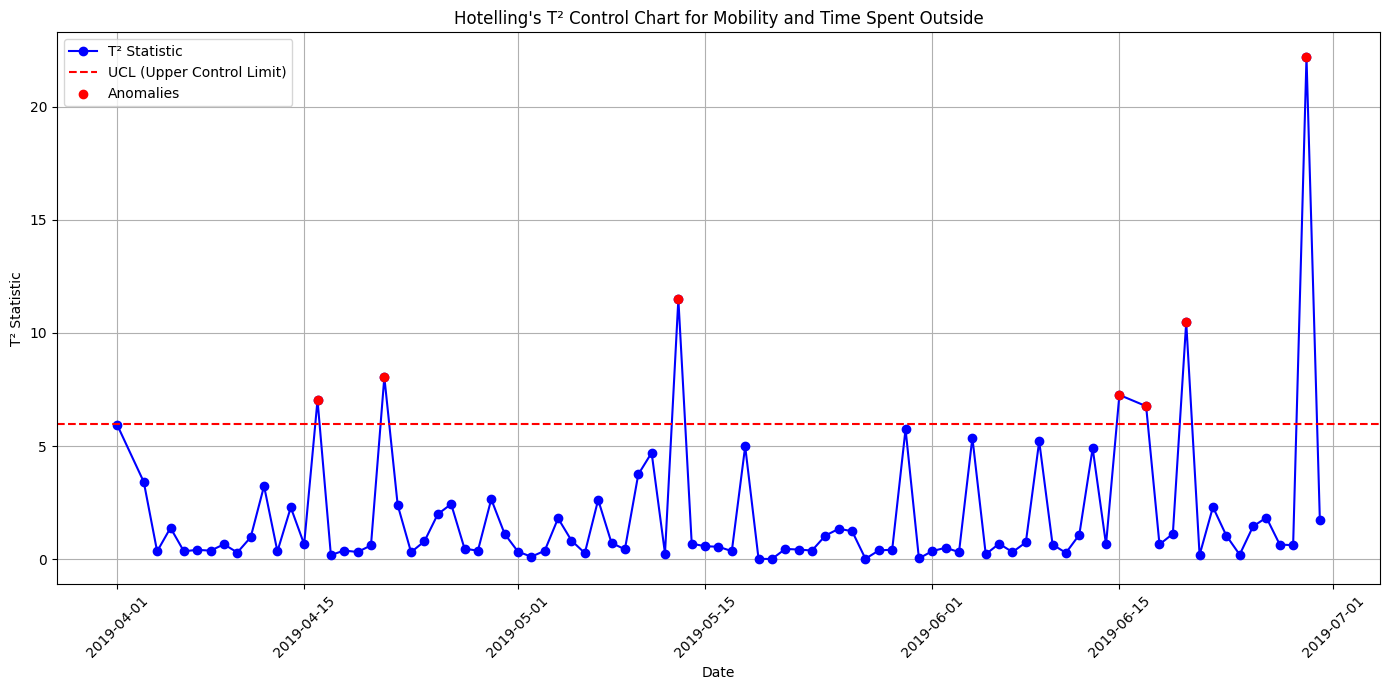

          date         T2  anomaly              anomaly_reason
0   2019-04-01   5.949989    False                            
1   2019-04-03   3.416357    False                            
2   2019-04-04   0.346122    False                            
3   2019-04-05   1.386829    False                            
4   2019-04-06   0.351249    False                            
..         ...        ...      ...                         ...
84  2019-06-26   1.842080    False                            
85  2019-06-27   0.646560    False                            
86  2019-06-28   0.621009    False                            
87  2019-06-29  22.178845     True  time_spent_outside is high
88  2019-06-30   1.723196    False                            

[89 rows x 4 columns]


In [ ]:
from scipy.stats import chi2

# regarding all days

# Standardize the features
mobility_df[['mobility', 'time_spent_outside']] = (mobility_df[['mobility', 'time_spent_outside']] - mobility_df[['mobility', 'time_spent_outside']].mean()) / mobility_df[['mobility', 'time_spent_outside']].std(ddof=0)

# Calculate mean vector and covariance matrix
mean_vector = mobility_df[['mobility', 'time_spent_outside']].mean().values
cov_matrix = mobility_df[['mobility', 'time_spent_outside']].cov().values
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Initialize columns for T² statistic and anomalies
mobility_df['T2'] = np.nan
mobility_df['anomaly'] = False
mobility_df['anomaly_reason'] = ''

# Calculate T² statistic for each observation
for i in range(len(mobility_df)):
    x = mobility_df[['mobility', 'time_spent_outside']].iloc[i].values
    T2 = (x - mean_vector).dot(inv_cov_matrix).dot((x - mean_vector).T)
    mobility_df.at[i, 'T2'] = T2

# Control limit for T² statistic (Chi-square distribution)
alpha = 0.05
p = 2  # Number of variables
UCL = chi2.ppf(1 - alpha, p)

# Check for anomalies and investigate reasons
for i in range(len(mobility_df)):
    if mobility_df.at[i, 'T2'] > UCL:
        mobility_df.at[i, 'anomaly'] = True
        anomalies = []
        for feature in ['mobility', 'time_spent_outside']:
            value = mobility_df.at[i, feature]
            mean = mean_vector[['mobility', 'time_spent_outside'].index(feature)]
            std_dev = np.sqrt(cov_matrix[['mobility', 'time_spent_outside'].index(feature), ['mobility', 'time_spent_outside'].index(feature)])
            if value > mean + 1.5 * std_dev:
                anomalies.append(f"{feature} is high")
            elif value < mean - 1.5 * std_dev:
                anomalies.append(f"{feature} is low")
        mobility_df.at[i, 'anomaly_reason'] = ', '.join(anomalies)

# Plotting the results for T² statistic
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['T2'], marker='o', label='T² Statistic', color='blue')
plt.axhline(y=UCL, color='red', linestyle='--', label='UCL (Upper Control Limit)')

# Highlight anomalies
if mobility_df['anomaly'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly']],
                mobility_df['T2'][mobility_df['anomaly']],
                color='red', label='Anomalies', zorder=5)

# Adding labels and title
plt.title("Hotelling's T² Control Chart for Mobility and Time Spent Outside")
plt.xlabel('Date')
plt.ylabel('T² Statistic')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # Show the control chart

# Display the mobility_df with T² statistic, anomalies, and reasons
print(mobility_df[['date', 'T2', 'anomaly', 'anomaly_reason']])

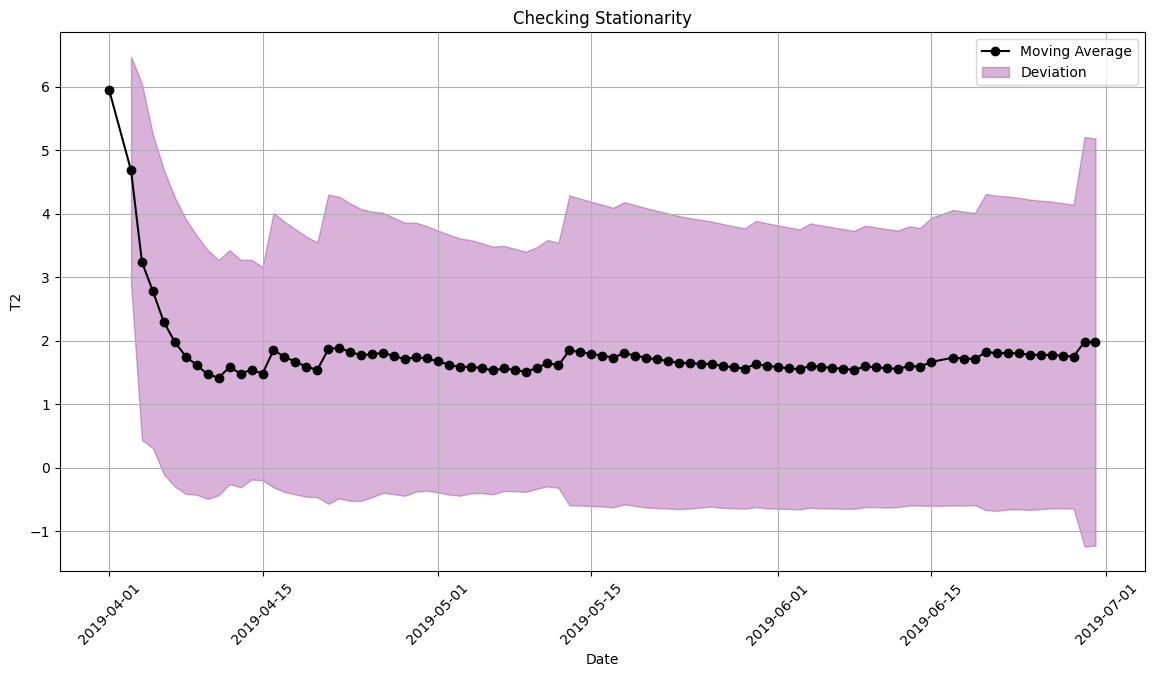

In [ ]:
# T2 values stationarity check regarding all-day scenario
check_stationarity(mobility_df,'T2')


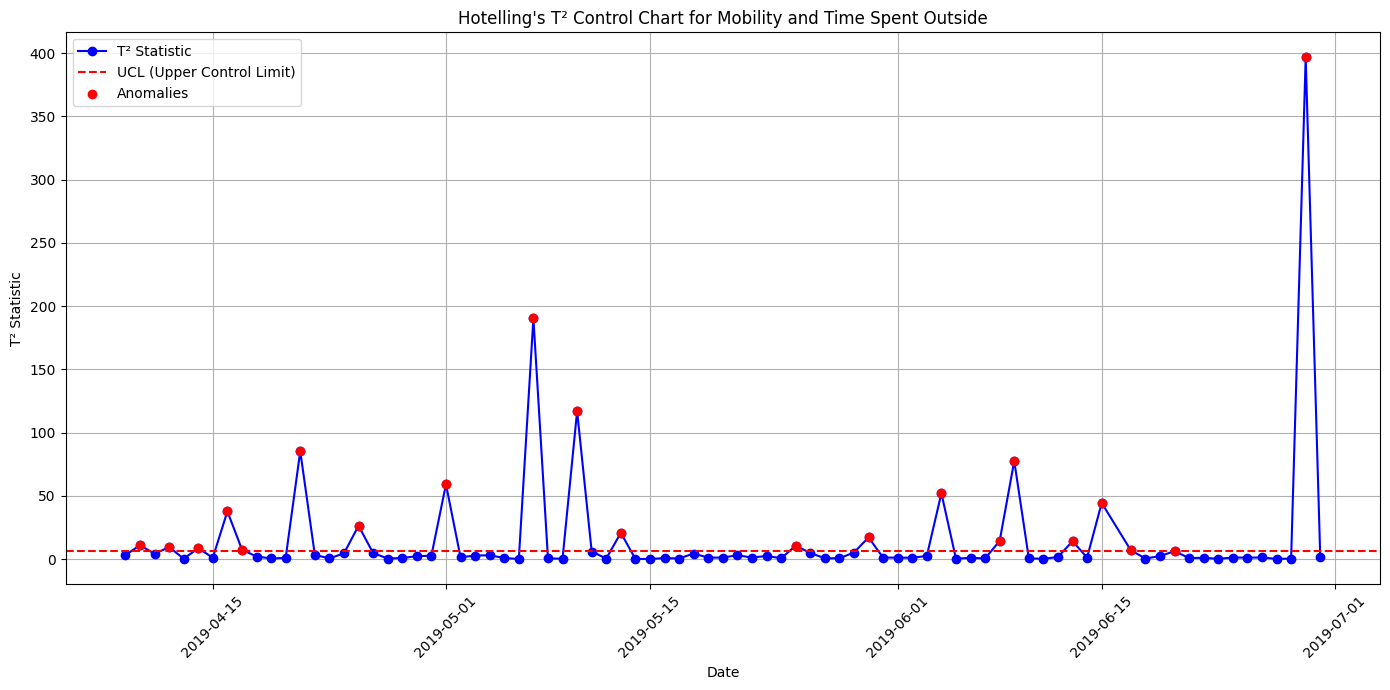

          date          T2  anomaly              anomaly_reason
0   2019-04-01         NaN    False                            
1   2019-04-03         NaN    False                            
2   2019-04-04         NaN    False                            
3   2019-04-05         NaN    False                            
4   2019-04-06         NaN    False                            
..         ...         ...      ...                         ...
84  2019-06-26    1.242576    False                            
85  2019-06-27    0.126953    False                            
86  2019-06-28    0.340088    False                            
87  2019-06-29  396.709738     True  time_spent_outside is high
88  2019-06-30    1.284743    False                            

[89 rows x 4 columns]


In [ ]:
# regarding last N previous days

# Set rolling window size
window_size = 7  # Adjust this value as needed

# Standardize the features
mobility_df[['mobility', 'time_spent_outside']] = (mobility_df[['mobility', 'time_spent_outside']] - mobility_df[['mobility', 'time_spent_outside']].mean()) / mobility_df[['mobility', 'time_spent_outside']].std(ddof=0)

# Initialize columns for T² statistic and anomalies
mobility_df['T2'] = np.nan
mobility_df['anomaly'] = False
mobility_df['anomaly_reason'] = ''

# Calculate T² statistic for each observation based on rolling window
for i in range(window_size, len(mobility_df)):
    window_df = mobility_df.iloc[i-window_size:i]  # Rolling window
    mean_vector = window_df[['mobility', 'time_spent_outside']].mean().values
    cov_matrix = window_df[['mobility', 'time_spent_outside']].cov().values
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    x = mobility_df[['mobility', 'time_spent_outside']].iloc[i].values
    T2 = (x - mean_vector).dot(inv_cov_matrix).dot((x - mean_vector).T)
    mobility_df.at[i, 'T2'] = T2

# Control limit for T² statistic (Chi-square distribution)
alpha = 0.05
p = 2  # Number of variables
UCL = chi2.ppf(1 - alpha, p)

# Check for anomalies and investigate reasons
for i in range(window_size, len(mobility_df)):
    if mobility_df.at[i, 'T2'] > UCL:
        mobility_df.at[i, 'anomaly'] = True
        anomalies = []
        for feature in ['mobility', 'time_spent_outside']:
            value = mobility_df.at[i, feature]
            mean = mobility_df.iloc[i-window_size:i][feature].mean()
            std_dev = mobility_df.iloc[i-window_size:i][feature].std()
            if value > mean + 1.5 * std_dev:
                anomalies.append(f"{feature} is high")
            elif value < mean - 1.5 * std_dev:
                anomalies.append(f"{feature} is low")
        mobility_df.at[i, 'anomaly_reason'] = ', '.join(anomalies)

# Plotting the results for T² statistic
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['T2'], marker='o', label='T² Statistic', color='blue')
plt.axhline(y=UCL, color='red', linestyle='--', label='UCL (Upper Control Limit)')

# Highlight anomalies
if mobility_df['anomaly'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly']],
                mobility_df['T2'][mobility_df['anomaly']],
                color='red', label='Anomalies', zorder=5)

# Adding labels and title
plt.title("Hotelling's T² Control Chart for Mobility and Time Spent Outside")
plt.xlabel('Date')
plt.ylabel('T² Statistic')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # Show the control chart

# Display the mobility_df with T² statistic, anomalies, and reasons
print(mobility_df[['date', 'T2', 'anomaly', 'anomaly_reason']])

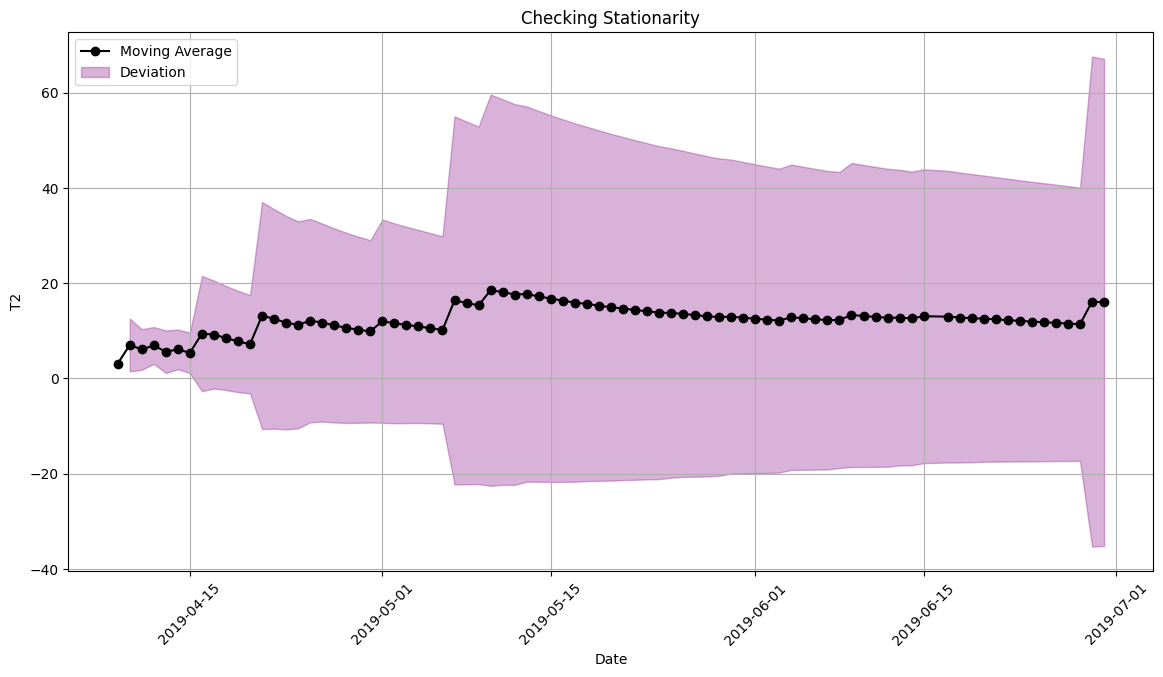

In [ ]:
# T2 values stationarity check regarding sliding window scenario
check_stationarity(mobility_df,'T2')


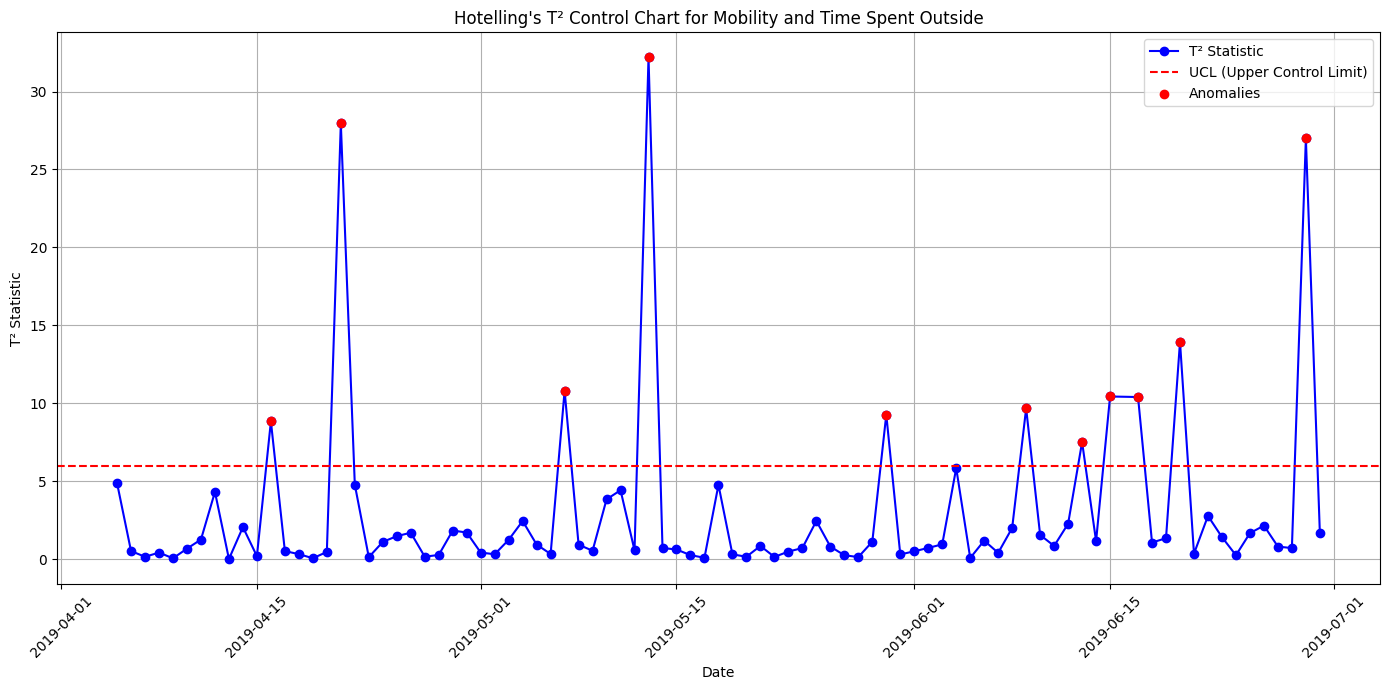

          date         T2  anomaly              anomaly_reason
0   2019-04-01        NaN    False                            
1   2019-04-03        NaN    False                            
2   2019-04-04        NaN    False                            
3   2019-04-05   4.876761    False                            
4   2019-04-06   0.516822    False                            
..         ...        ...      ...                         ...
84  2019-06-26   2.149061    False                            
85  2019-06-27   0.803414    False                            
86  2019-06-28   0.706238    False                            
87  2019-06-29  26.992772     True  time_spent_outside is high
88  2019-06-30   1.668195    False                            

[89 rows x 4 columns]


In [ ]:
# regarding all previous days
from sklearn.covariance import LedoitWolf

# Standardize the features
mobility_df[['mobility', 'time_spent_outside']] = (mobility_df[['mobility', 'time_spent_outside']] - mobility_df[['mobility', 'time_spent_outside']].mean()) / mobility_df[['mobility', 'time_spent_outside']].std(ddof=0)

# Initialize columns for T² statistic and anomalies
mobility_df['T2'] = np.nan
mobility_df['anomaly'] = False
mobility_df['anomaly_reason'] = ''

# Minimum number of observations required for analysis
min_obs = 3  # Adjust this value as needed

# Calculate T² statistic for each observation based on all previous days
for i in range(min_obs, len(mobility_df)):
    previous_days_df = mobility_df.iloc[:i]  # All previous days
    mean_vector = previous_days_df[['mobility', 'time_spent_outside']].mean().values
    lw = LedoitWolf()
    cov_matrix = lw.fit(previous_days_df[['mobility', 'time_spent_outside']]).covariance_
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    x = mobility_df[['mobility', 'time_spent_outside']].iloc[i].values
    T2 = (x - mean_vector).dot(inv_cov_matrix).dot((x - mean_vector).T)
    mobility_df.at[i, 'T2'] = T2

# Control limit for T² statistic (Chi-square distribution)
alpha = 0.05
p = 2  # Number of variables
UCL = chi2.ppf(1 - alpha, p)

# Check for anomalies and investigate reasons
for i in range(min_obs, len(mobility_df)):
    if mobility_df.at[i, 'T2'] > UCL:
        mobility_df.at[i, 'anomaly'] = True
        anomalies = []
        for feature in ['mobility', 'time_spent_outside']:
            value = mobility_df.at[i, feature]
            mean = mobility_df.iloc[:i][feature].mean()
            std_dev = mobility_df.iloc[:i][feature].std()
            if value > mean + 1.5 * std_dev:
                anomalies.append(f"{feature} is high")
            elif value < mean - 1.5 * std_dev:
                anomalies.append(f"{feature} is low")
        mobility_df.at[i, 'anomaly_reason'] = ', '.join(anomalies)

# Plotting the results for T² statistic
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['T2'], marker='o', label='T² Statistic', color='blue')
plt.axhline(y=UCL, color='red', linestyle='--', label='UCL (Upper Control Limit)')

# Highlight anomalies
if mobility_df['anomaly'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly']],
                mobility_df['T2'][mobility_df['anomaly']],
                color='red', label='Anomalies', zorder=5)

# Adding labels and title
plt.title("Hotelling's T² Control Chart for Mobility and Time Spent Outside")
plt.xlabel('Date')
plt.ylabel('T² Statistic')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # Show the control chart

# Display the mobility_df with T² statistic, anomalies, and reasons
print(mobility_df[['date', 'T2', 'anomaly', 'anomaly_reason']])

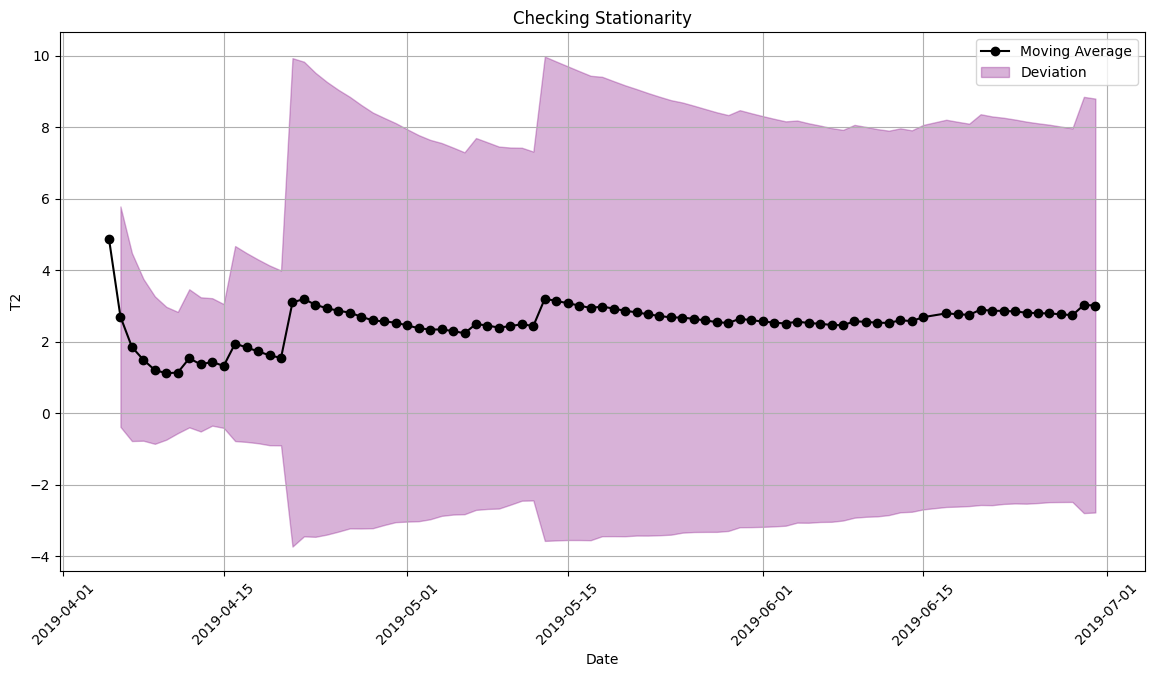

In [ ]:
# T2 values stationarity check regarding all-previous-days scenario
check_stationarity(mobility_df,'T2')


**considering only the same precious weekdays**

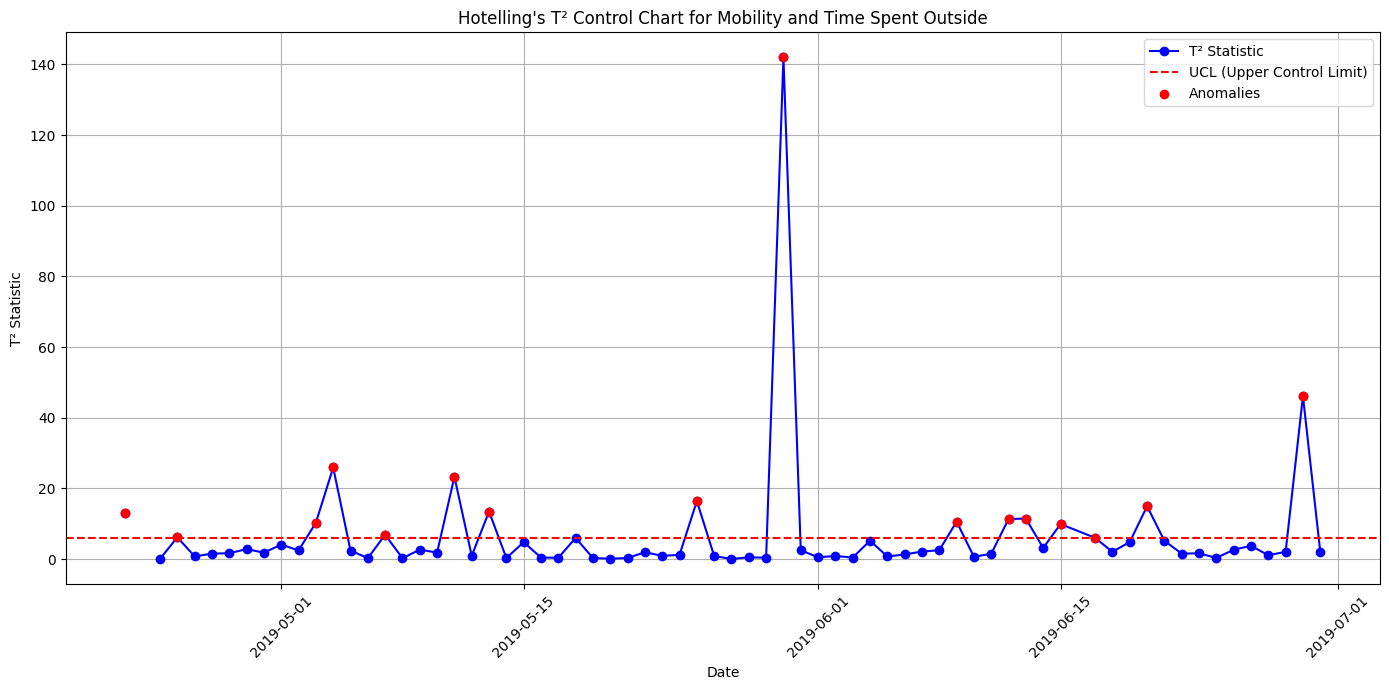

          date          T2  anomaly  \
50  2019-05-22    1.927676    False   
51  2019-05-23    0.899383    False   
52  2019-05-24    1.174555    False   
53  2019-05-25   16.401662     True   
54  2019-05-26    0.866934    False   
55  2019-05-27    0.010175    False   
56  2019-05-28    0.489659    False   
57  2019-05-29    0.382890    False   
58  2019-05-30  141.994108     True   
59  2019-05-31    2.479312    False   
60  2019-06-01    0.499512    False   
61  2019-06-02    0.862972    False   
62  2019-06-03    0.423400    False   
63  2019-06-04    5.190924    False   
64  2019-06-05    0.725419    False   
65  2019-06-06    1.289941    False   
66  2019-06-07    2.119679    False   
67  2019-06-08    2.487971    False   
68  2019-06-09   10.590745     True   
69  2019-06-10    0.637533    False   
70  2019-06-11    1.485554    False   
71  2019-06-12   11.320269     True   
72  2019-06-13   11.451961     True   
73  2019-06-14    3.116105    False   
74  2019-06-15    9.90580

In [ ]:
# regarding the same previous weekdays

# Add a column for the weekday
mobility_df['weekday'] = pd.to_datetime(mobility_df['date']).dt.day_name()

# Standardize the features
mobility_df[['mobility', 'time_spent_outside']] = (mobility_df[['mobility', 'time_spent_outside']] - mobility_df[['mobility', 'time_spent_outside']].mean()) / mobility_df[['mobility', 'time_spent_outside']].std(ddof=0)

# Initialize columns for T² statistic and anomalies
mobility_df['T2'] = np.nan
mobility_df['anomaly'] = False
mobility_df['anomaly_reason'] = ''

# Minimum number of observations required for analysis
min_obs = 3  # Adjust this value as needed

# Calculate T² statistic for each observation based on the same previous weekdays
for i in range(min_obs, len(mobility_df)):
    current_day = mobility_df.iloc[i]
    current_weekday = current_day['weekday']

    # Filter the dataframe for the same previous weekdays
    previous_days_df = mobility_df[(mobility_df['weekday'] == current_weekday) & (mobility_df.index < i)]

    # Skip calculation if there are not enough previous days
    if len(previous_days_df) < min_obs:
        continue

    mean_vector = previous_days_df[['mobility', 'time_spent_outside']].mean().values
    lw = LedoitWolf()
    cov_matrix = lw.fit(previous_days_df[['mobility', 'time_spent_outside']]).covariance_
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    x = current_day[['mobility', 'time_spent_outside']].values
    T2 = (x - mean_vector).dot(inv_cov_matrix).dot((x - mean_vector).T)
    mobility_df.at[i, 'T2'] = T2

# Control limit for T² statistic (Chi-square distribution)
alpha = 0.05
p = 2  # Number of variables
UCL = chi2.ppf(1 - alpha, p)

# Check for anomalies and investigate reasons
for i in range(min_obs, len(mobility_df)):
    if mobility_df.at[i, 'T2'] > UCL:
        mobility_df.at[i, 'anomaly'] = True
        anomalies = []
        for feature in ['mobility', 'time_spent_outside']:
            value = mobility_df.at[i, feature]
            mean = mobility_df.iloc[:i][feature].mean()
            std_dev = mobility_df.iloc[:i][feature].std()
            if value > mean + 1.5 * std_dev:
                anomalies.append(f"{feature} is high")
            elif value < mean - 1.5 * std_dev:
                anomalies.append(f"{feature} is low")
        mobility_df.at[i, 'anomaly_reason'] = ', '.join(anomalies)

# Plotting the results for T² statistic
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['T2'], marker='o', label='T² Statistic', color='blue')
plt.axhline(y=UCL, color='red', linestyle='--', label='UCL (Upper Control Limit)')

# Highlight anomalies
if mobility_df['anomaly'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly']],
                mobility_df['T2'][mobility_df['anomaly']],
                color='red', label='Anomalies', zorder=5)

# Adding labels and title
plt.title("Hotelling's T² Control Chart for Mobility and Time Spent Outside")
plt.xlabel('Date')
plt.ylabel('T² Statistic')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # Show the control chart

# Display the mobility_df with T² statistic, anomalies, and reasons
print(mobility_df[['date', 'T2', 'anomaly', 'anomaly_reason']][50:])

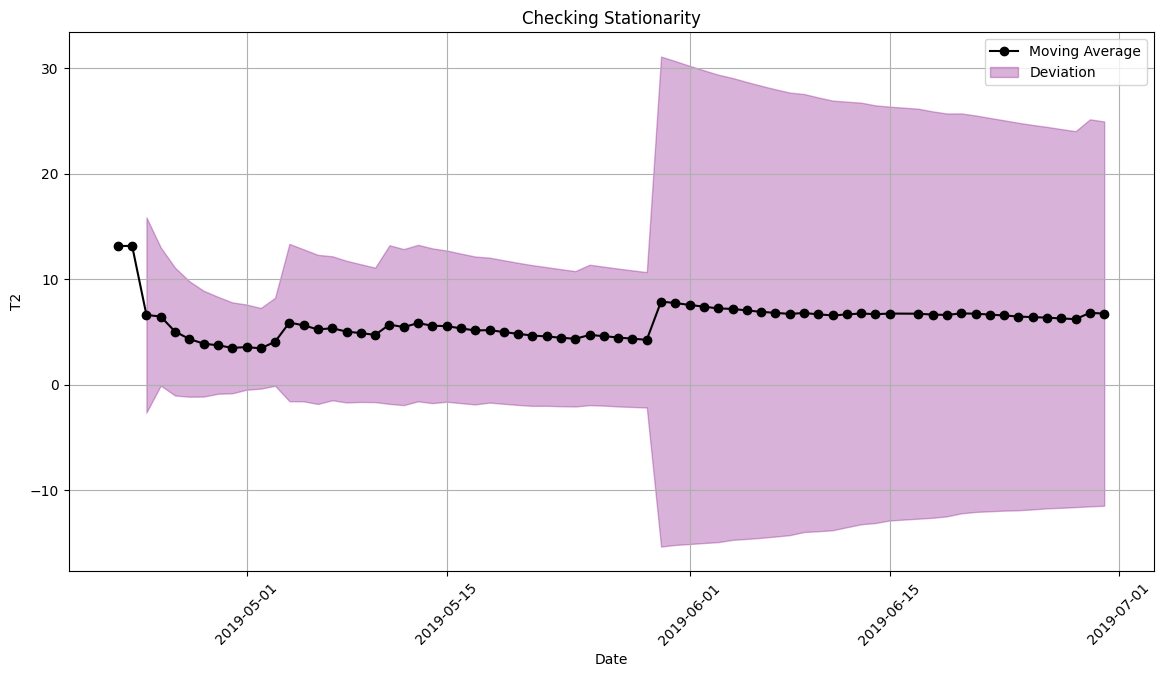

In [ ]:
# T2 values stationarity check regarding the previous days with the same weekday scenario
check_stationarity(mobility_df,'T2')


Hotelling's T^2 Control Chart for physiological parameters**

In [ ]:
id = '099bc'

id_physiology_df = filled_physiology_df[filled_physiology_df['patient_id']==id]

id_heart_rate_df = id_physiology_df[id_physiology_df['device_type'] == 'Heart rate']


# Pivot the DataFrame
id_physio_df = id_physiology_df.pivot_table(index='date', columns='device_type', values='value', aggfunc='mean')

# Reset index to make 'date' a column
id_physio_df.reset_index(inplace=True)

# Display the pivoted DataFrame
print(id_physio_df)

In [ ]:
# regarding previous days

# Standardize the features
id_physio_df.iloc[:, 1:] = (id_physio_df.iloc[:, 1:] - id_physio_df.iloc[:, 1:].mean()) / id_physio_df.iloc[:, 1:].std(ddof=0)

# Initialize columns for T² statistic and anomalies
id_physio_df['T2'] = np.nan
id_physio_df['anomaly'] = False
id_physio_df['anomaly_reason'] = ''

# Minimum number of observations required for analysis
min_obs = 3  # Adjust this value as needed

# Calculate T² statistic for each observation based on all previous days
for i in range(min_obs, len(id_physio_df)):
    previous_days_df = id_physio_df.iloc[:i]  # All previous days
    mean_vector = previous_days_df.iloc[:, 1:-3].mean().values
    lw = LedoitWolf()
    cov_matrix = lw.fit(previous_days_df.iloc[:, 1:-3]).covariance_
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    x = id_physio_df.iloc[i, 1:-3].values
    T2 = (x - mean_vector).dot(inv_cov_matrix).dot((x - mean_vector).T)
    id_physio_df.at[i, 'T2'] = T2

# Control limit for T² statistic (Chi-square distribution)
alpha = 0.05
p = len(id_physio_df.columns) - 4  # Number of variables (excluding 'date', 'T2', 'anomaly', and 'anomaly_reason')
UCL = chi2.ppf(1 - alpha, p)

# Check for anomalies and investigate reasons
for i in range(min_obs, len(id_physio_df)):
    if id_physio_df.at[i, 'T2'] > UCL:
        id_physio_df.at[i, 'anomaly'] = True
        anomalies = []
        for feature in id_physio_df.columns[1:-3]:
            value = id_physio_df.at[i, feature]
            mean = id_physio_df.iloc[:i][feature].mean()
            std_dev = id_physio_df.iloc[:i][feature].std()
            if value > mean + 1.5 * std_dev:
                anomalies.append(f"{feature} is high")
            elif value < mean - 1.5 * std_dev:
                anomalies.append(f"{feature} is low")
        id_physio_df.at[i, 'anomaly_reason'] = ', '.join(anomalies)

# Plotting the results for T² statistic
plt.figure(figsize=(14, 7))
plt.plot(id_physio_df['date'], id_physio_df['T2'], marker='o', label='T² Statistic', color='blue')
plt.axhline(y=UCL, color='red', linestyle='--', label='UCL (Upper Control Limit)')

# Highlight anomalies
if id_physio_df['anomaly'].any():
    plt.scatter(id_physio_df['date'][id_physio_df['anomaly']],
                id_physio_df['T2'][id_physio_df['anomaly']],
                color='red', label='Anomalies', zorder=5)

# Adding labels and title
plt.title("Hotelling's T² Control Chart for Physiology Measurements")
plt.xlabel('Date')
plt.ylabel('T² Statistic')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # Show the control chart

# Display the id_physio_df with T² statistic, anomalies, and reasons
print(id_physio_df[['date', 'T2', 'anomaly', 'anomaly_reason']])

NameError: name 'id_physio_df' is not defined

**Autoencoder for mobility**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

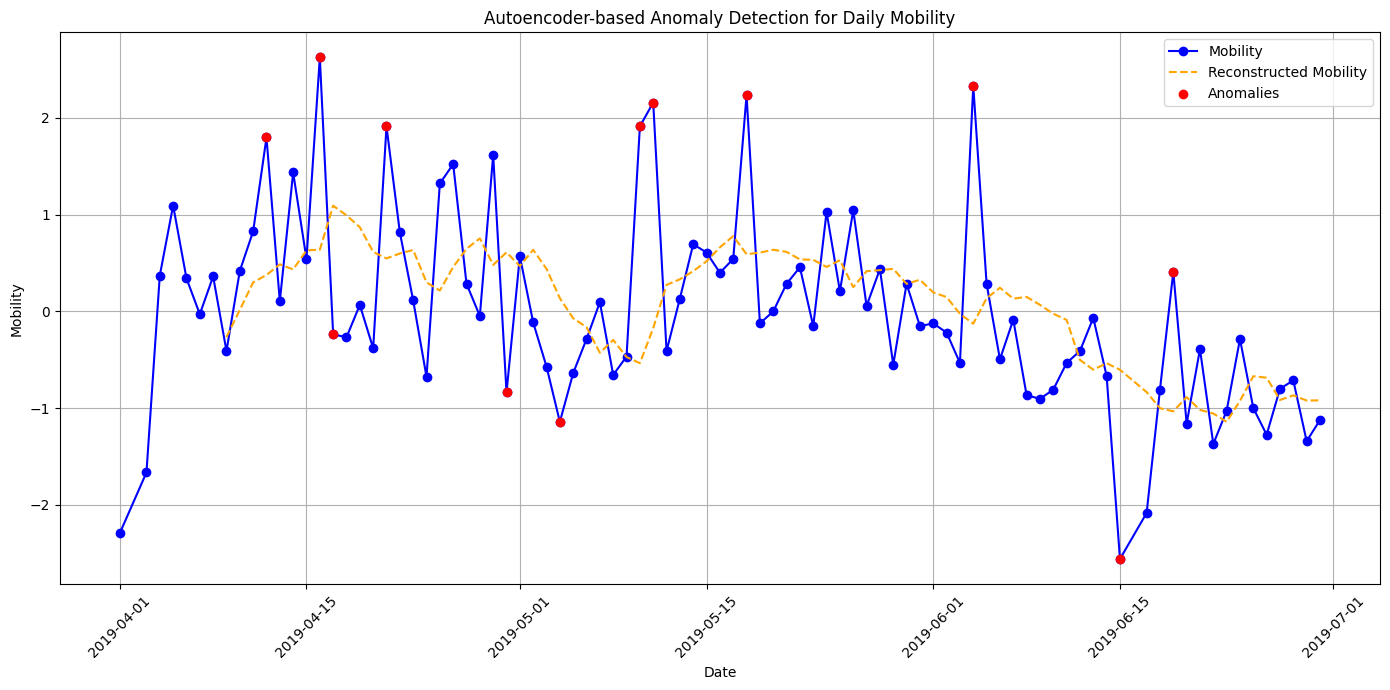

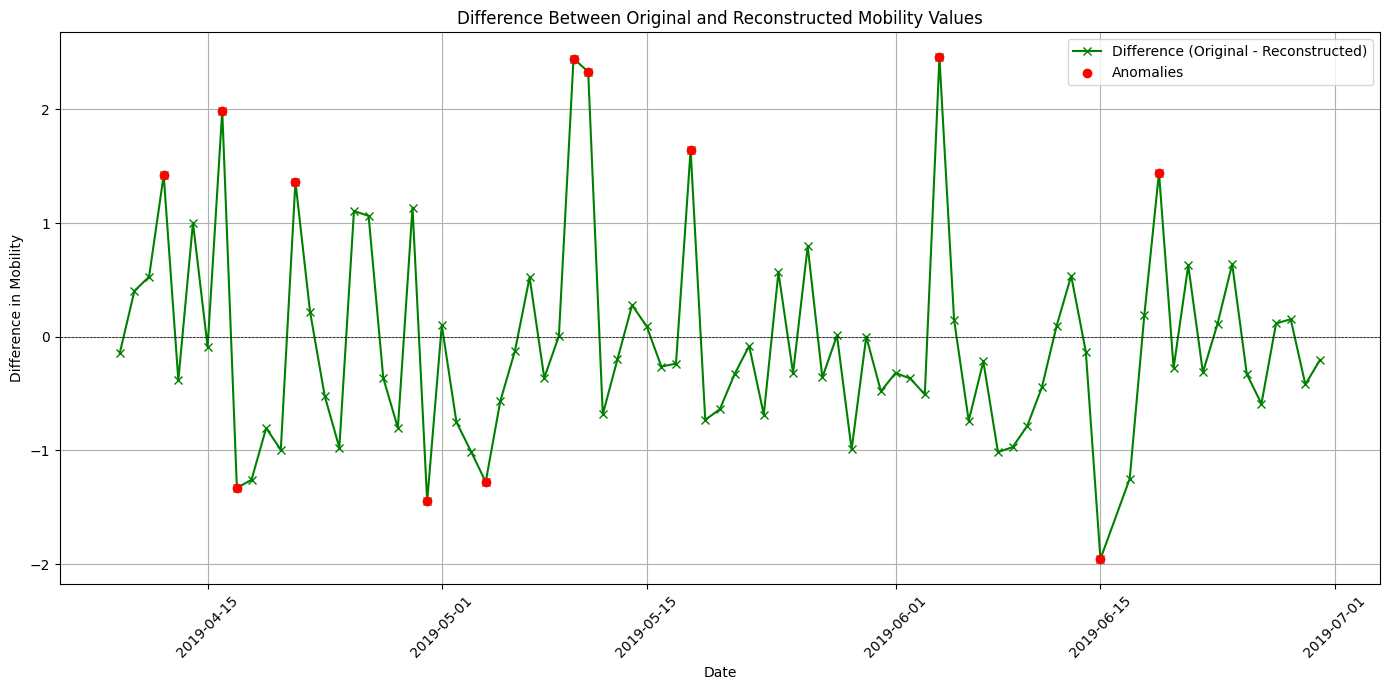

In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

# Normalize the mobility data using StandardScaler
scaler = StandardScaler()
mobility_scaled = scaler.fit_transform(mobility_df[['mobility']])

# Prepare the data for the autoencoder training with a fixed window size
window_size = 7
X_train = []
y_train = []

# Collect previous days for training using a sliding window approach
for i in range(window_size, len(mobility_scaled)):
    X_train.append(mobility_scaled[i-window_size:i].flatten())  # Use the last 'window_size' entries
    y_train.append(mobility_scaled[i][0])  # Use the current value as the output

# Convert to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

# Create the autoencoder model (input shape matches the window_size)
model = Sequential()
model.add(Dense(10, input_shape=(X_train.shape[1],), activation='relu'))  # Encoder
model.add(Dense(1, activation='linear'))  # Decoder
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
model.fit(X_train, X_train, epochs=100, batch_size=1, verbose=0)

# Calculate reconstruction and differences
mobility_df['reconstructed'] = np.nan
mobility_df['difference'] = np.nan

for i in range(window_size, len(mobility_df)):
    previous_data = mobility_scaled[i-window_size:i].flatten()  # Use only the last 'window_size' entries
    if len(previous_data) > 0:
        # Predict reconstruction for the flattened array
        reconstructed = model.predict(previous_data.reshape(1, -1))

        # Store reconstructed mobility and calculate difference
        mobility_df.at[i, 'reconstructed'] = scaler.inverse_transform(reconstructed.reshape(-1, 1)).flatten()[0]
        mobility_df.at[i, 'difference'] = mobility_df.at[i, 'mobility'] - mobility_df.at[i, 'reconstructed']

# Set a threshold for anomalies (e.g., mean + 3 * std dev of the differences)
threshold = np.mean(mobility_df['difference'].dropna()) + 1.5 * np.std(mobility_df['difference'].dropna())

# Detect anomalies based on the threshold
mobility_df['anomaly'] = mobility_df['difference'].abs() > threshold

# Plotting the results for mobility and anomalies
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['mobility'], marker='o', label='Mobility', color='blue')
plt.plot(mobility_df['date'], mobility_df['reconstructed'], linestyle='--', color='orange', label='Reconstructed Mobility')

# Highlight anomalies
if mobility_df['anomaly'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly']],
                mobility_df['mobility'][mobility_df['anomaly']],
                color='red', label='Anomalies', zorder=5)

# Adding labels and title
plt.title('Autoencoder-based Anomaly Detection for Daily Mobility')
plt.xlabel('Date')
plt.ylabel('Mobility')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # Show the plot

# Plotting the difference
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['difference'], marker='x', color='green', label='Difference (Original - Reconstructed)')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

# Highlight anomalies in the difference plot
if mobility_df['anomaly'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly']],
                mobility_df['difference'][mobility_df['anomaly']],
                color='red', label='Anomalies', zorder=5)

# Adding labels and title for the difference
plt.title('Difference Between Original and Reconstructed Mobility Values')
plt.xlabel('Date')
plt.ylabel('Difference in Mobility')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()  # Show the difference plot


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

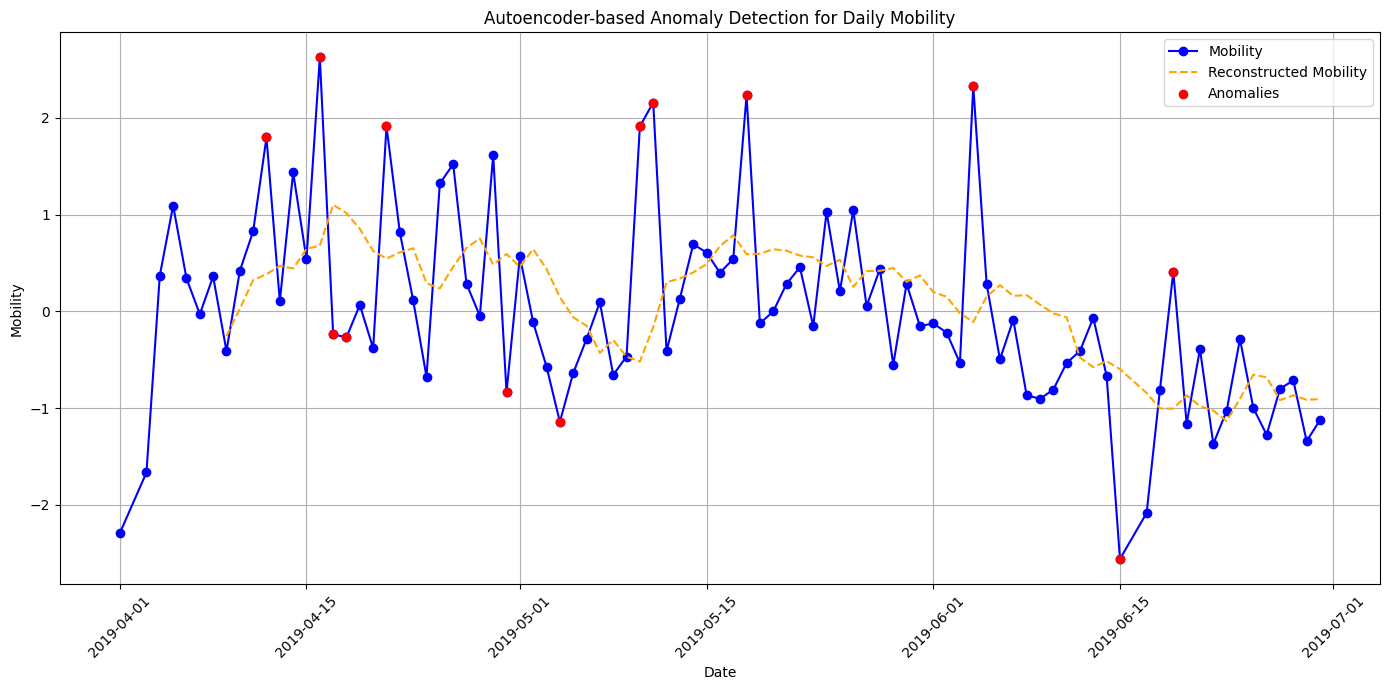

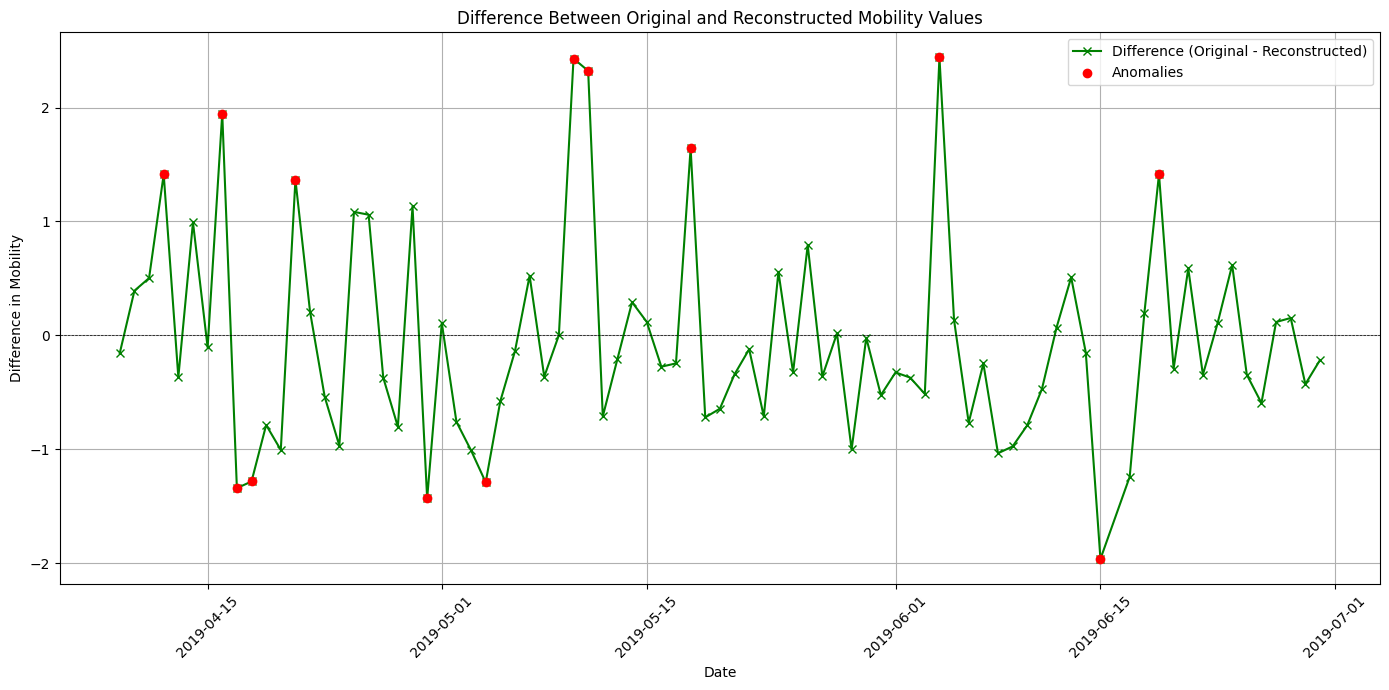

In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

# Normalize the mobility data using StandardScaler
scaler = StandardScaler()
mobility_scaled = scaler.fit_transform(mobility_df[['mobility']])

# Prepare the data for the autoencoder training with a fixed window size
window_size = 7
X_train = []
y_train = []

# Collect previous days for training using a sliding window approach
for i in range(window_size, len(mobility_scaled)):
    X_train.append(mobility_scaled[i-window_size:i])  # Use the last 'window_size' entries
    y_train.append(mobility_scaled[i][0])  # Use the current value as the output

# Convert to numpy array and reshape for LSTM
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Create the LSTM autoencoder model
model = Sequential()
model.add(LSTM(10, input_shape=(window_size, 1), activation='relu', return_sequences=False))  # Encoder
model.add(Dense(1, activation='linear'))  # Decoder
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
model.fit(X_train, X_train, epochs=100, batch_size=1, verbose=0)

# Calculate reconstruction and differences
mobility_df['reconstructed'] = np.nan
mobility_df['difference'] = np.nan

for i in range(window_size, len(mobility_df)):
    previous_data = mobility_scaled[i-window_size:i].reshape((1, window_size, 1))  # Use only the last 'window_size' entries
    if previous_data.size > 0:
        # Predict reconstruction for the sequence
        reconstructed = model.predict(previous_data)

        # Store reconstructed mobility and calculate difference
        mobility_df.at[i, 'reconstructed'] = scaler.inverse_transform(reconstructed.reshape(-1, 1)).flatten()[0]
        mobility_df.at[i, 'difference'] = mobility_df.at[i, 'mobility'] - mobility_df.at[i, 'reconstructed']

# Set a threshold for anomalies (e.g., mean + 3 * std dev of the differences)
threshold = np.mean(mobility_df['difference'].dropna()) + 1.5 * np.std(mobility_df['difference'].dropna())

# Detect anomalies based on the threshold
mobility_df['anomaly'] = mobility_df['difference'].abs() > threshold

# Plotting the results for mobility and anomalies
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['mobility'], marker='o', label='Mobility', color='blue')
plt.plot(mobility_df['date'], mobility_df['reconstructed'], linestyle='--', color='orange', label='Reconstructed Mobility')

# Highlight anomalies
if mobility_df['anomaly'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly']],
                mobility_df['mobility'][mobility_df['anomaly']],
                color='red', label='Anomalies', zorder=5)

# Adding labels and title
plt.title('Autoencoder-based Anomaly Detection for Daily Mobility')
plt.xlabel('Date')
plt.ylabel('Mobility')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # Show the plot

# Plotting the difference
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['difference'], marker='x', color='green', label='Difference (Original - Reconstructed)')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

# Highlight anomalies in the difference plot
if mobility_df['anomaly'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly']],
                mobility_df['difference'][mobility_df['anomaly']],
                color='red', label='Anomalies', zorder=5)

# Adding labels and title for the difference
plt.title('Difference Between Original and Reconstructed Mobility Values')
plt.xlabel('Date')
plt.ylabel('Difference in Mobility')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()  # Show the difference plot


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

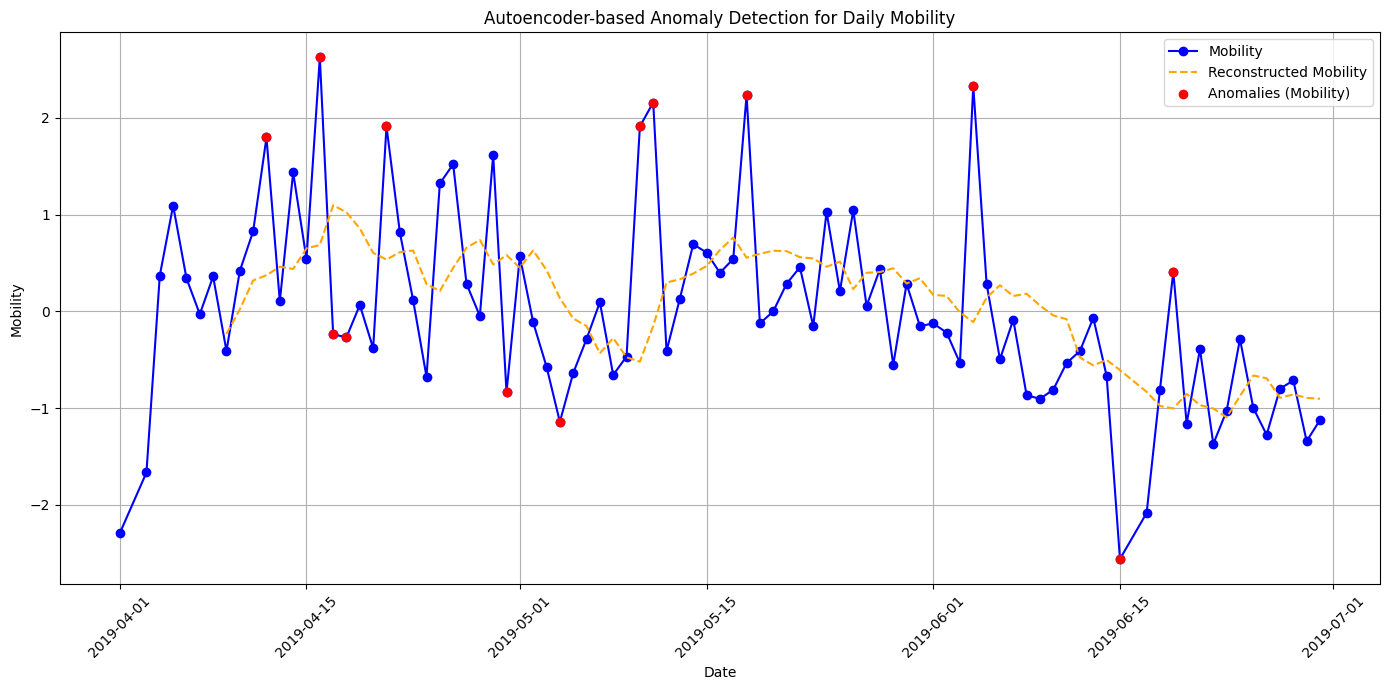

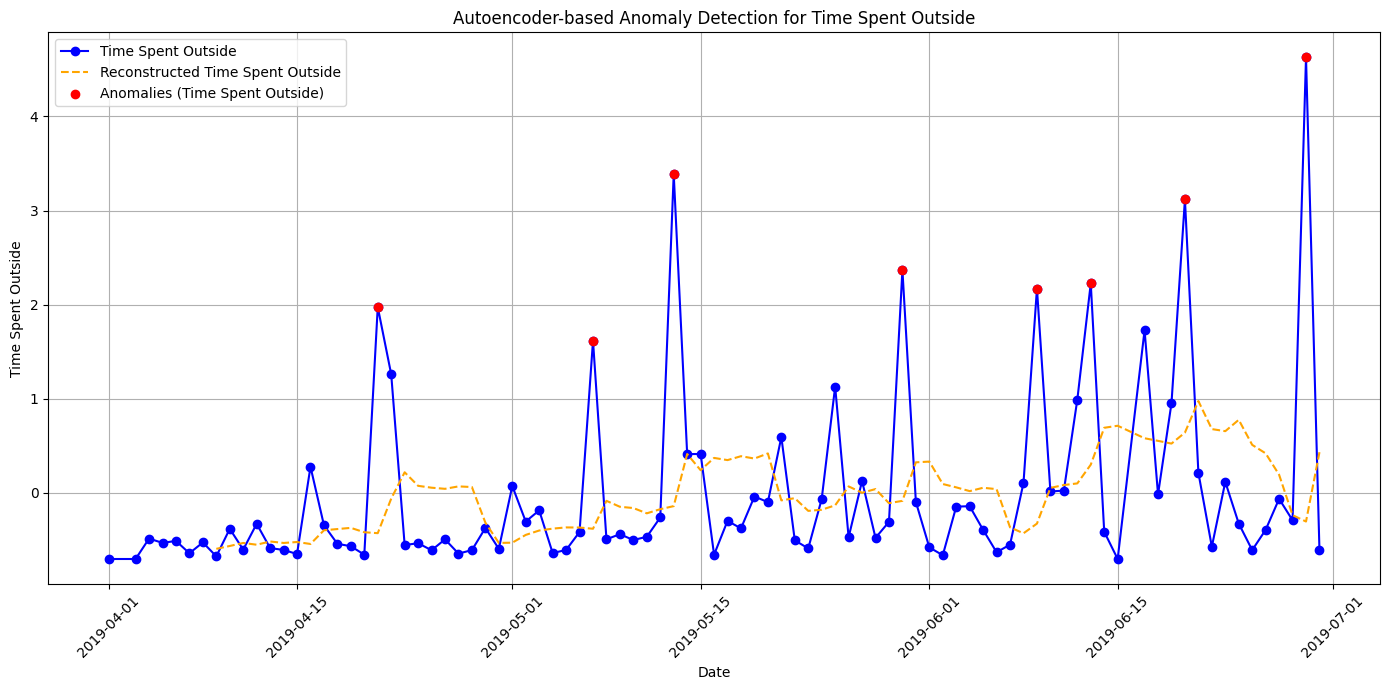

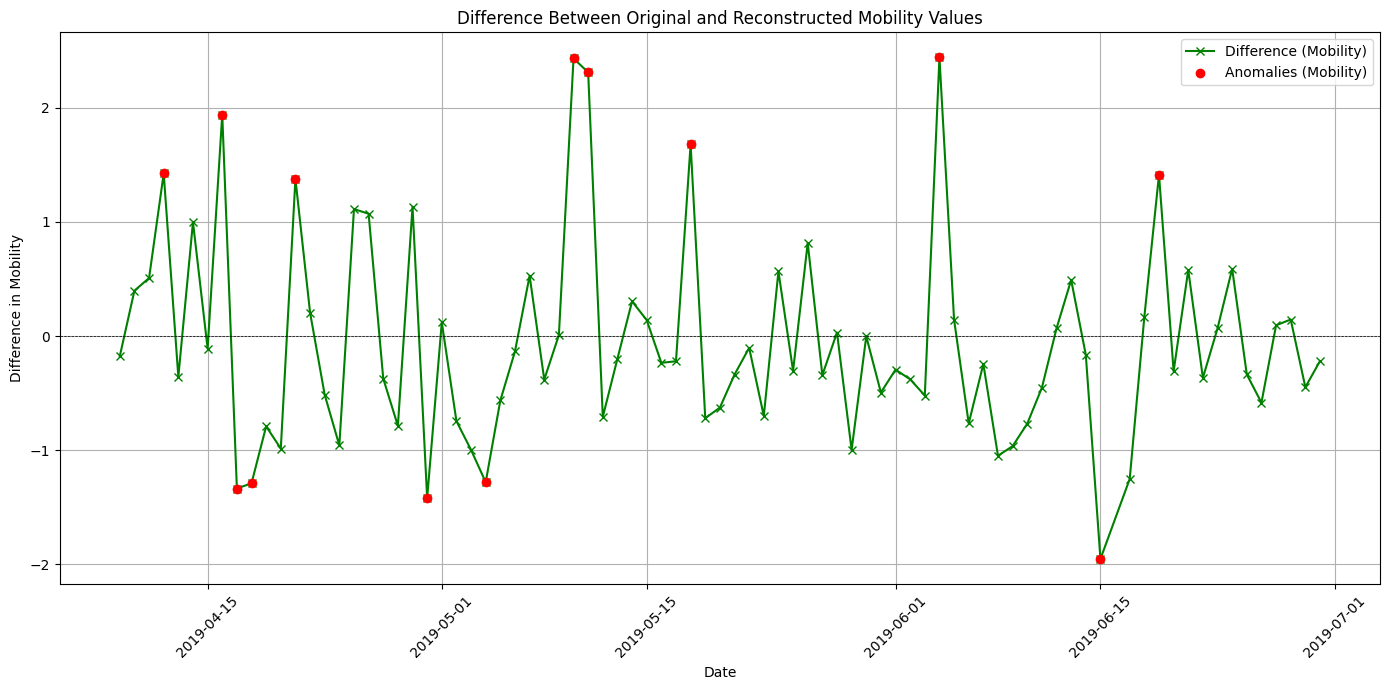

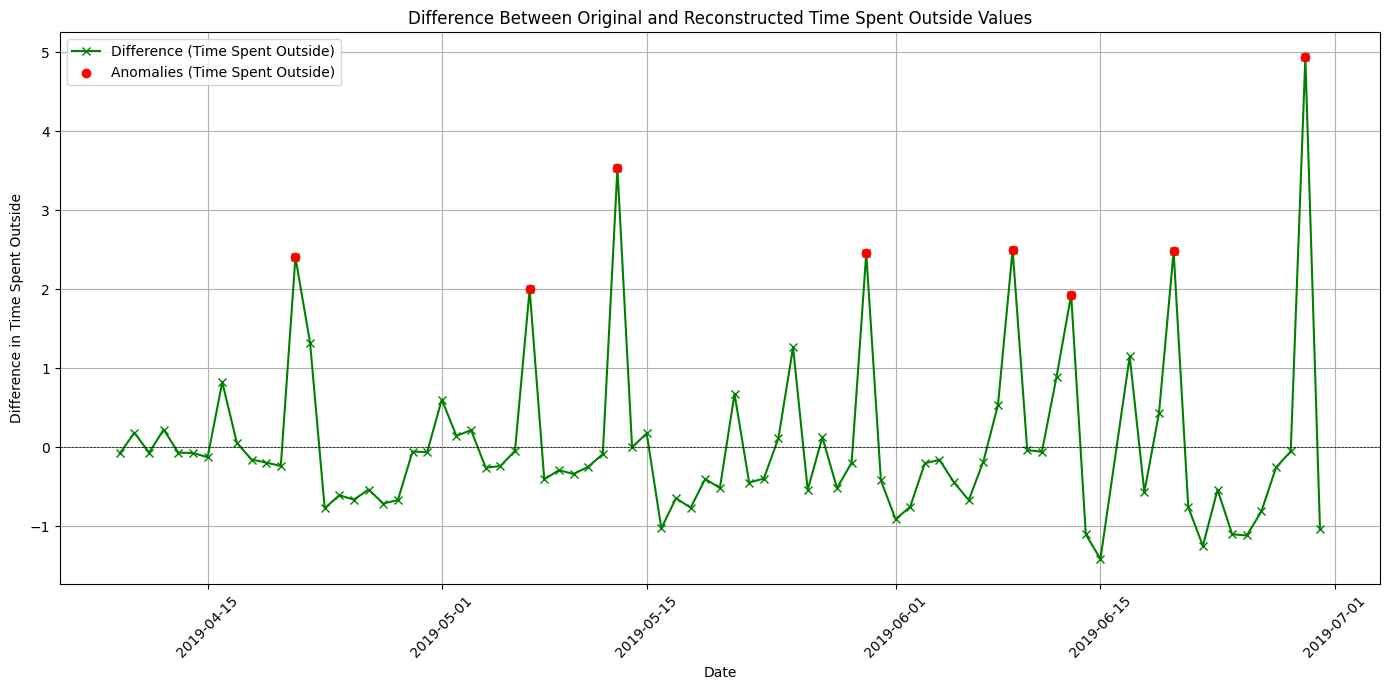

In [ ]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import matplotlib.pyplot as plt

# Normalize the mobility data and time_spent_outside using StandardScaler
scaler = StandardScaler()
mobility_scaled = scaler.fit_transform(mobility_df[['mobility', 'time_spent_outside']])

# Prepare the data for the autoencoder training with a fixed window size
window_size = 7
X_train = []

# Collect previous days for training using a sliding window approach
for i in range(window_size, len(mobility_scaled)):
    X_train.append(mobility_scaled[i-window_size:i])  # Use the last 'window_size' entries

# Convert to numpy array and reshape for LSTM
X_train = np.array(X_train)

# Create the LSTM autoencoder model
model = Sequential()
model.add(LSTM(10, input_shape=(window_size, X_train.shape[2]), activation='relu', return_sequences=False))  # Encoder
model.add(Dense(X_train.shape[2], activation='linear'))  # Decoder
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
model.fit(X_train, X_train, epochs=100, batch_size=1, verbose=0)

# Calculate reconstruction and differences for both features
mobility_df['reconstructed_mobility'] = np.nan
mobility_df['reconstructed_time_spent_outside'] = np.nan
mobility_df['difference_mobility'] = np.nan
mobility_df['difference_time_spent_outside'] = np.nan

for i in range(window_size, len(mobility_df)):
    previous_data = mobility_scaled[i-window_size:i].reshape((1, window_size, 2))  # Use only the last 'window_size' entries
    if previous_data.size > 0:
        # Predict reconstruction for the sequence
        reconstructed = model.predict(previous_data)

        # Store reconstructed values and calculate differences
        reconstructed_inverse = scaler.inverse_transform(reconstructed.reshape(-1, 2))
        mobility_df.at[i, 'reconstructed_mobility'] = reconstructed_inverse[0, 0]
        mobility_df.at[i, 'reconstructed_time_spent_outside'] = reconstructed_inverse[0, 1]
        mobility_df.at[i, 'difference_mobility'] = mobility_df.at[i, 'mobility'] - mobility_df.at[i, 'reconstructed_mobility']
        mobility_df.at[i, 'difference_time_spent_outside'] = mobility_df.at[i, 'time_spent_outside'] - mobility_df.at[i, 'reconstructed_time_spent_outside']

# Set thresholds for anomalies (e.g., mean + 3 * std dev of the differences)
threshold_mobility = np.mean(mobility_df['difference_mobility'].dropna()) + 1.5 * np.std(mobility_df['difference_mobility'].dropna())
threshold_time_spent_outside = np.mean(mobility_df['difference_time_spent_outside'].dropna()) + 1.5 * np.std(mobility_df['difference_time_spent_outside'].dropna())

# Detect anomalies based on the thresholds
mobility_df['anomaly_mobility'] = mobility_df['difference_mobility'].abs() > threshold_mobility
mobility_df['anomaly_time_spent_outside'] = mobility_df['difference_time_spent_outside'].abs() > threshold_time_spent_outside

# Plotting the results for mobility and anomalies
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['mobility'], marker='o', label='Mobility', color='blue')
plt.plot(mobility_df['date'], mobility_df['reconstructed_mobility'], linestyle='--', color='orange', label='Reconstructed Mobility')

# Highlight anomalies in mobility
if mobility_df['anomaly_mobility'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly_mobility']],
                mobility_df['mobility'][mobility_df['anomaly_mobility']],
                color='red', label='Anomalies (Mobility)', zorder=5)

# Adding labels and title
plt.title('Autoencoder-based Anomaly Detection for Daily Mobility')
plt.xlabel('Date')
plt.ylabel('Mobility')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # Show the plot

# Plotting the results for time_spent_outside and anomalies
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['time_spent_outside'], marker='o', label='Time Spent Outside', color='blue')
plt.plot(mobility_df['date'], mobility_df['reconstructed_time_spent_outside'], linestyle='--', color='orange', label='Reconstructed Time Spent Outside')

# Highlight anomalies in time_spent_outside
if mobility_df['anomaly_time_spent_outside'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly_time_spent_outside']],
                mobility_df['time_spent_outside'][mobility_df['anomaly_time_spent_outside']],
                color='red', label='Anomalies (Time Spent Outside)', zorder=5)

# Adding labels and title
plt.title('Autoencoder-based Anomaly Detection for Time Spent Outside')
plt.xlabel('Date')
plt.ylabel('Time Spent Outside')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()  # Show the plot

# Plotting the difference for mobility
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['difference_mobility'], marker='x', color='green', label='Difference (Mobility)')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

# Highlight anomalies in the difference plot for mobility
if mobility_df['anomaly_mobility'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly_mobility']],
                mobility_df['difference_mobility'][mobility_df['anomaly_mobility']],
                color='red', label='Anomalies (Mobility)', zorder=5)

# Adding labels and title for the difference
plt.title('Difference Between Original and Reconstructed Mobility Values')
plt.xlabel('Date')
plt.ylabel('Difference in Mobility')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()  # Show the difference plot

# Plotting the difference for time_spent_outside
plt.figure(figsize=(14, 7))
plt.plot(mobility_df['date'], mobility_df['difference_time_spent_outside'], marker='x', color='green', label='Difference (Time Spent Outside)')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

# Highlight anomalies in the difference plot for time_spent_outside
if mobility_df['anomaly_time_spent_outside'].any():
    plt.scatter(mobility_df['date'][mobility_df['anomaly_time_spent_outside']],
                mobility_df['difference_time_spent_outside'][mobility_df['anomaly_time_spent_outside']],
                color='red', label='Anomalies (Time Spent Outside)', zorder=5)

# Adding labels and title for the difference
plt.title('Difference Between Original and Reconstructed Time Spent Outside Values')
plt.xlabel('Date')
plt.ylabel('Difference in Time Spent Outside')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()  # Show the difference plot
